# 0. Importing Libraries

In [1]:
# Utilities
import os
import warnings
from collections import Counter
from itertools import combinations

# Data Wrangling
import numpy as np
import pandas as pd

# Statistics
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Feature Processing and Transformation
from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Sampling data
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN, SMOTE

# Modelling and Models Evaluation
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc, make_scorer, confusion_matrix, precision_recall_curve

# Inline plots in the notebook
%matplotlib inline
# No Warnings
warnings.filterwarnings('ignore')

# Set display options in pandas as per convenience
pd.set_option('display.max_colwidth',200)
pd.set_option('display.max_columns',100)

# 1. Utilities

In [2]:
# Utilities

RANDOM_SEED = 81

my_palette = plt.color_sequences.get('tab20b')
np.random.shuffle(my_palette, )
my_palette = sns.color_palette(my_palette)
my_palette

[(0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
 (0.4823529411764706, 0.2549019607843137, 0.45098039215686275),
 (0.7411764705882353, 0.6196078431372549, 0.2235294117647059),
 (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
 (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
 (0.8705882352941177, 0.6196078431372549, 0.8392156862745098),
 (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
 (0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
 (0.9058823529411765, 0.7294117647058823, 0.3215686274509804),
 (0.4196078431372549, 0.43137254901960786, 0.8117647058823529),
 (0.3215686274509804, 0.32941176470588235, 0.6392156862745098),
 (0.9058823529411765, 0.796078431372549, 0.5803921568627451),
 (0.5490196078431373, 0.42745098039215684, 0.19215686274509805),
 (0.807843137254902, 0.42745098039215684, 0.7411764705882353),
 (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
 (0.5490196078431373, 0.6352941176470588, 0.3215686274509804),
 (0.807843137254902, 0.8588235294117647, 0.611764705882353),
 (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
 (0.6470588235294118, 0.3176470588235294, 0.5803921568627451),
 (0.6784313725490196, 0.28627450980392155, 0.2901960784313726)]

In [3]:
def evaluate_model(model, feature_set, target_data):
    '''Measures the accuracy, recall and f1-score of the feature-set'''
    predictions = model.predict(feature_set)
    
    accuracy = accuracy_score(target_data, predictions)
    recall = recall_score(target_data, predictions)
    f1 = f1_score(target_data, predictions)
    
    print(f'The accuracy score is : {accuracy:.2}')
    print(f'The recall score is : {recall:.2}')
    print(f'The f1-score is : {f1:.2}')
    
    return accuracy, recall, f1

In [4]:
def feature_transformation_pipeline(dataframe, transformable_features, target_feature):
    # Extracting the subset to work on
    dummy = dataframe[transformable_features.__add__(target_variable)]

    # Final dataset to be returned ----> container shell
    final_transformed_dataframe = dummy[[target_feature]]

    # Feature Transformation
    for feature in transformable_features:
    #     print(feature)
        part_data = dummy[[feature].__add__([target_feature])]

        # Mathematical transformations of the transformable features
        part_data[f'{feature}_natural_log'] = np.log(part_data[feature])
        part_data[f'{feature}_log10'] = np.log10(part_data[feature])
        part_data[f'{feature}_exp'] = np.exp(part_data[feature])
        part_data[f'{feature}_sqrt'] = np.power(part_data[feature], 1/2)
        part_data[f'{feature}_cubrt'] = np.power(part_data[feature], 1/3)
        part_data[f'{feature}_cube'] = np.power(part_data[feature], 3)
        part_data[f'{feature}_square'] = np.power(part_data[feature], 2)
        # Box-Cox Transformation
        try:
            transformed_data, lambda_value = boxcox(part_data[feature])
            part_data[f'{feature}_Boxcox_{lambda_value:.2}'] = transformed_data
        except:
            pass
        # Yoe-Johnson Transformation
        try:
            transformed_data, lambda_value = yeojohnson(data)
            part_data[f'{feature}_YJ_{lambda_value:.2}'] = transformed_data
        except:
            pass

        # Replacing infinity values if any
        part_data_1 = part_data[~np.isinf(part_data)]

        # Keep the transformation or not
        transformed_features = [i for i in part_data_1.columns if not i == target_feature]
        # All correlation co-efficients
        correlations = {'Feature':[], 'Point Biserial Correlation Coefficient':[]}
        # Calculating the correlation co-efficients of the features
        for col in transformed_features:
    #         print(col)
            pb_corr = point_biserial_correlation_coefficient(part_data_1, col, target_feature, print_results = False)
            # Collating the correlations
            correlations['Feature'].append(col)
            correlations['Point Biserial Correlation Coefficient'].append(pb_corr)

        # Ordering the correlations as per their magnitudes
        correlations = pd.DataFrame(correlations).sort_values(by = ['Point Biserial Correlation Coefficient'], ascending = False, key = lambda x : abs(x)).reset_index(drop=True)
        # Fetching the best feature transformation
        best_feature_transformation = correlations.iloc[0].Feature
        # Extracting the new best correlation and the original correlation for comparison
        best_transformation_corr = correlations.loc[correlations.Feature == best_feature_transformation]['Point Biserial Correlation Coefficient'].values[0]
        og_corr = correlations.loc[correlations.Feature == feature]['Point Biserial Correlation Coefficient'].values[0]

        # Identifying if it is worth transforming the feature
        best_transformation_corr = abs(best_transformation_corr)
        og_corr = abs(og_corr)

        # Checking the improvement in the correlation
        if abs(best_transformation_corr-og_corr) > 0.05:
            final_feature = best_feature_transformation
        else:
            final_feature = feature
        # Collating the best feature versions

        final_transformed_dataframe = pd.concat((part_data[[final_feature]], final_transformed_dataframe), axis = 'columns')
    
    for col in final_transformed_dataframe.columns:
        final_transformed_dataframe[col] = np.where(np.isinf(final_transformed_dataframe[col]), np.nan, final_transformed_dataframe[col])
    final_transformed_dataframe = final_transformed_dataframe.fillna(method = 'bfill').fillna(method = 'ffill')
    
    return final_transformed_dataframe

In [5]:
def full_statistical_description(dataframe, sort = False):
    '''Generates the full descriptive statistical summary of the features of the Dataframe
    
    dataframe : pandas.DataFrame object
    
    returns : statistical summary of the dataframe'''

    # Getting the descriptive statistics
    stats = dataframe.describe().T
    
    # Calculating Skewness
    for col in dataframe.columns:
        try:
            skewness = dataframe[col].skew()
        except:
            skewness = np.nan
        stats.loc[col, 'Skewness'] = skewness
    
    # Calculating Kurtosis
    for col in dataframe.columns:
        try:
            kurt = dataframe[col].kurtosis()
        except:
            kurt = np.nan
        stats.loc[col, 'Kurtosis'] = kurt
    
    # Removing the count feature
    stats = stats.drop(columns = ['count'])
    
    # Re-ordering the stats as per their decreasing order of skewness
    if sort:
        stats = stats.sort_values(by = ['Skewness'], ascending = False, key = lambda x : abs(x))

    return stats

In [6]:
def calculate_woe_iv(df, feature, target):
    # Create a dataframe to store the results
    result_df = pd.DataFrame()

    # Calculate the total number of events and non-events
    total_events = df[target].sum()
    total_non_events = df.shape[0] - total_events

    # Calculate the total WOE and IV for the entire feature
    total_woe = np.log((total_non_events + 0.5) / (total_events + 0.5))
    total_iv = (total_non_events / (total_non_events + total_events)) - (total_events / (total_non_events + total_events))

    # Calculate WOE and IV for each unique value in the feature
    for value in df[feature].unique():
        subset = df[df[feature] == value]
        events = subset[target].sum()
        non_events = subset.shape[0] - events

        woe = np.log((non_events + 0.5) / (events + 0.5))
        iv = (non_events / (non_events + events)) - (events / (non_events + events))

        result_df = pd.concat((result_df,pd.DataFrame({'Value': [value],'Event': [events],'Non-Event': [non_events],
                                                       'WOE': [woe],'IV': [iv]})), axis = 'rows', ignore_index = True)

    result_df = result_df.sort_values(by = 'WOE', ascending = False).reset_index(drop=True)

    plt.figure(figsize = (15,5))
    plt.plot(result_df[~pd.isna(result_df.Value)].reset_index()['WOE'], marker = 'o', color = 'orange')
    plt.xticks(range(result_df.shape[0]))
    plt.title('WOE')
    plt.show()

#     result_df = pd.concat((result_df, pd.DataFrame({'Value': ['Total'], 'Event': total_events,
#                                                     'Non-Event': [total_non_events],'WOE': [total_woe],'IV': [total_iv]})),
#                          axis = 'rows', ignore_index = True)

    return result_df

In [7]:
def draw_ROC(model, feature_data, labels, is_train = True):
    '''Draws the AUC-ROC curves and calculates the area under the curve'''

    # Calculate the prediction probabilities
    probabilities = model.predict_proba(feature_data)[:, 1]
    
    # Compute ROC curve and ROC area
    FPR, TPR, thresholds = roc_curve(labels, probabilities)
    roc_auc = auc(FPR, TPR)

    # Plot the ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(FPR, TPR, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    if is_train:
        plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
    else:
        plt.title('Receiver Operating Characteristic (ROC) Curve - Testing Data')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

In [8]:
def point_biserial_correlation_coefficient(dataframe, numerical_feature, categorical_feature, significance_value = 0.05, print_results = True):
    '''Calculates the point biserial correlation co-efficient between a continuous and a categorical feature
    Removes the missing values before calculating the point-biserial correlation co-efficient
    
    dataframe: pandas.DataFrame object
    numerical_feature: str : the numerical feature to calculate the correlation of
    categorical_feature: str : the categorical feature to calculate the correlation of
    significance_value: float : the significance value for the hypothesis test : default = 0.05'''

    data = dataframe[[numerical_feature, categorical_feature]].copy()
    data = data.dropna()

    correlation_coefficient, p_value = pointbiserialr(data[numerical_feature], data[categorical_feature])

    if print_results:
        print(f'The p-value is : {p_value:.03}')
        if p_value<significance_value:
            print('The correlation is statistically significant !')
        else:
            print('The correlation is not statistically significant !')

        print(f'The point biserial correlation between {numerical_feature} and the {categorical_feature} is :{correlation_coefficient:.03}.')
    return correlation_coefficient

In [9]:
def point_biserial_categorical_correlation(dataframe, categorical_feature, dichotomous_target, significance_value = 0.05):
    '''Calculates the point biserial correlation co-efficient between two categorical features
    Removes the missing values before calculating the point-biserial correlation co-efficient

    dataframe: pandas.DataFrame object
    categorical_feature: str : the categorical feature to calculate the correlation of
    dichotomous_target: str : the dichotomous binary feature to calculate the correlation with
    significance_value: float : the significance value for the hypothesis test : default = 0.05'''

    # Generating a copy for local applications and ease of use
    data = dataframe[[categorical_feature, dichotomous_target]].copy().dropna()

    categorical_feature_mapper = {value:index for index, value in enumerate(data[categorical_feature].unique())}
    encoded_categorical_feature = data[categorical_feature].replace(categorical_feature_mapper)

    # Calculating the point-biserial correlation coefficient
    correl, p_val = pointbiserialr(encoded_categorical_feature, data[dichotomous_target])

    print(f'The p-value is {p_val:.05}.')

    if p_val<significance_value:
        print('The correlation is statistically significant !')
    else:
        print('The correlation is not statistically significant !')

    print(f'The point biserial correlation between {categorical_feature} and the {dichotomous_target} is :{correl:.03}.')
    
    return correl

In [10]:
def pairwise_point_biserial_correlations(features_dataframe, pairwise_correl_data_dict = None):
    '''Generates the pairwise correlation for each pair of features in the feature set been passed
    Uses point biserial correlation co-efficient for the pairwise correlation coefficient calculation
    
    Inputs:
    features_dataframe : pandas.DataFrame object
    
    returns:
    pairwise_correlations_dataframe : pandas.DataFrame object : A dataframe consisting of the feature pairs and the measurement of association between them'''
    
    # Initializing the correlations data collector dictionary
    if pairwise_correl_data_dict == None:
        pairwise_correl_data_dict = {'Feature_1':[], 'Feature_2':[], 'Point_Biserial_Correlation_Coefficient':[]}

    # Generating and arranging the feature pairs to calculating the correlations on
    feature_pairs = list(combinations(features_dataframe.columns, 2))
    feature_pairs = [sorted(pair) for pair in feature_pairs]

    # Calculating the pairwise correlations
    for pair in feature_pairs:
        # Point Biserial correlation calculation
        paired_pb_correl_coeff = point_biserial_correlation_coefficient(features_dataframe, pair[0], pair[1], print_results = False)
        # Collating data
        pairwise_correl_data_dict['Feature_1'].append(pair[0])
        pairwise_correl_data_dict['Feature_2'].append(pair[1])
        pairwise_correl_data_dict['Point_Biserial_Correlation_Coefficient'].append(paired_pb_correl_coeff)

    # Generating a dataframe from the dictionary of correlations
    pairwise_correl_df = pd.DataFrame(pairwise_correl_data_dict)
    # Arranging the correlations as per their decreasing magnitudes
    pairwise_correl_df = pairwise_correl_df.sort_values(by = 'Point_Biserial_Correlation_Coefficient', ascending = False, key = lambda x : abs(x))
    
    return pairwise_correl_df

In [11]:
def cat_to_cat_association_tests(data, categorical_feature_1, categorical_feature_2, significance_value = 0.05):
    '''Performs tests for estimating relationships between two categorical variables and quantify te association between the features
    data : pandas.DataFrame type object
    categorical_feature_1 : str : name of the categorical feature to test the association of
    categorical_feature_2 : str : name of the categorical feature {target feature} to measure the association with
    significance_value : The significance value for the hypothesis test {default = 0.05}
    
    This function runs a series of tests to identify and then quantify association. These are:
    1. chi2 contingency test: Determining whether there is a significant association between two categorical variables
    2. Understanding the chi2 discrepancies
    3. Cramers V measure of association: Measurement of association or correlation between two categorical variables
    4. Theils Uncertainity coefficient: Quantifies the uncertainty reduction in predicting the value of one variable based on the knowledge of another.
    
    Interpreting the results:
    1. Chi2 contingency test:
        Null Hypothesis (H0): The variables are independent; there is no association between them.
        Alternative Hypothesis (H1): The variables are dependent; there is a significant association between them.
    
        Returns: 
            chi2_discrepancy_value : measurement of the discrepancy between the observed and expected frequencies in the contingency table.
            p_values : The p-value associated with the chi-square test indicates the probability of observing the given value (or a more extreme one) if the variables were independent. A smaller p-value suggests we can reject the null hypothesis and `there is significant association between the features.`
            expected_frequencies : Represents the values that would be expected in each cell of a contingency table under the assumption that the variables are independent.


    2. Understanding the chi2 discrepancies : 
        When comparing observed and expected frequencies to understand where the discrepancies contribute to the chi-square value, we can visualize the differences
        One common way to do this is to create a heatmap that shows the standardized residuals (observed - expected) / sqrt(expected)
        
        Interpretation of the Heatmap:
            - Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in these cells.
            - Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in these cells.


    3. Cramers V measure of association:
        Cramérs V is a measure of association between two categorical variables. It is based on the chi-square statistic from a contingency table and ranges from 0 to 1
        
        Interpreting Cramers V measure:
            V==0 :==> No Association
            0<V<0.1 :==> Weak Association
            0.1<V<0.3 :==> Moderate Association
            0.3<V<0.5 :==> Moderately Strong Association
            V>=0.5 :==> Very Strong Association
        
    4. Theils Uncertainity coefficient:
        Quantifies the uncertainty reduction in predicting the value of one variable based on the knowledge of another.
        
        Interpretation:
            theils u value == 0 : No association or complete independence
            theils u value == 1 : Perfect association or complete dependence

            u==0 :==> No association
            0<u<0.3 :==> Weak association
            0.3<u<0.7 :==> Moderate association
            0.7<u<1 :==> Strong Association
            u==1 :==> Perfect association
    '''
    
#-----------------------------------Chi2 Test for Discrepancy
    print()
    print('*'*114)
    print('1. Chi2 Test.')
    contingency_table = pd.crosstab(data[categorical_feature_1], data[categorical_feature_2])
    chi2_discrepancy, chi2_p_value, chi2_dof, expected_frequencies = chi2_contingency(contingency_table)
    print(f'- The p-value calculated is : {chi2_p_value:.05}')
    print(f'- The chi2 discrepancy is : {chi2_discrepancy:.05}')
    if chi2_p_value <= significance_value:
        print('\t- We can reject the Null Hypothesis')
        print(f'\t- The features {categorical_feature_1} and {categorical_feature_2} are not independent of each other.')
    else:
        print('\t- We failed to reject the Null Hypothesis')
        print(f'\t- The features {categorical_feature_1} and {categorical_feature_2} are independent of each other.')
    print('*'*114)
    print()
#-----------------------------------Chi2 Test for Discrepancy

#-----------------------------------Chi2 Discrepancy distribution
    print('2. Understanding the chi2 discrepancies distribution.')
    # Calculate standardized residuals
    residuals = (contingency_table - expected_frequencies) / expected_frequencies
    residuals = residuals.dropna()  # Drop any NaN values that might be present

    # Plot a heatmap
    sns.heatmap(residuals, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5)
    plt.title('Standardized Residuals Heatmap for chi2 Test')
    plt.show()

    print('\t- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.')
    print('\t- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.')
    print('\t- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.')
    print('*'*114)
    print()
#-----------------------------------Chi2 Discrepancy distribution

#-----------------------------------Cramers V measure
    print('3. Cramers V measure of association.')
    cramers_v = np.sqrt(chi2_discrepancy / (sum(contingency_table.sum()) * (min(contingency_table.shape) - 1)))
    print(f'- The cramers v measure is : {cramers_v:.03}')
    if cramers_v==0:
        print(f'\t- There is no association between {categorical_feature_1} and {categorical_feature_2}')
    elif ((cramers_v > 0)&(cramers_v<0.1)):
        print(f'\t- There is a very weak association between {categorical_feature_1} and {categorical_feature_2}')
    elif ((cramers_v>0.1)&(cramers_v<0.3)):
        print(f'\t- There is a moderate association between {categorical_feature_1} and {categorical_feature_2}')
    elif ((cramers_v>0.3)&(cramers_v<0.5)):
        print(f'\t- There is a moderately strong association between {categorical_feature_1} and {categorical_feature_2}')
    elif cramers_v>=0.5:
        print(f'\t- There is a very strong association between {categorical_feature_1} and {categorical_feature_2}')    
    print('*'*114)
    print()
#-----------------------------------Cramers V measure    

#-----------------------------------Theil-u measure of association
    print('4. Theils Uncertainity measurement of association.')
    # Extracting the categorical variables data
    categorical_feature_1_data = data[categorical_feature_1]
    categorical_feature_2_data = data[categorical_feature_2]

    # Create a DataFrame with the two categorical variables
    df_categorical = pd.DataFrame({'Variable_1': categorical_feature_1_data, 'Variable_2': categorical_feature_2_data})

    # Function to calculate entropy for a given variable ---> theil uncertainity
    def calculate_entropy(series):
        value_counts = series.value_counts(normalize=True)
        entropy = -np.sum(value_counts * np.log2(value_counts))
        return entropy

    # Function to calculate conditional entropy given two variables ---> theil uncertainity
    def calculate_conditional_entropy(variable_1, variable_2):
        entropy_conditional = 0
        for category_2 in variable_2.unique():
            subset_variable_1 = variable_1[variable_2 == category_2]
            entropy_conditional += len(subset_variable_1) / len(variable_1) * calculate_entropy(subset_variable_1)
        return entropy_conditional

    # Calculate entropy for each variable
    entropy_variable_1 = calculate_entropy(df_categorical['Variable_1'])
    entropy_variable_2 = calculate_entropy(df_categorical['Variable_2'])

    # Calculate conditional entropy
    conditional_entropy = calculate_conditional_entropy(df_categorical['Variable_1'], df_categorical['Variable_2'])

    # Calculate Theil's U
    theils_u = (entropy_variable_1 - conditional_entropy) / entropy_variable_1
    
    print(f'- The Theils uncertainity measurement of association is : {theils_u:.03}.')
    if theils_u==0:
        print(f'\t- There is no association between {categorical_feature_1} and {categorical_feature_2}')
    elif ((theils_u > 0)&(theils_u<0.3)):
        print(f'\t- There is a very weak association between {categorical_feature_1} and {categorical_feature_2}')
    elif ((theils_u>0.3)&(theils_u<0.7)):
        print(f'\t- There is a moderate association between {categorical_feature_1} and {categorical_feature_2}')
    elif ((theils_u>0.7)&(theils_u<1)):
        print(f'\t- There is a strong association between {categorical_feature_1} and {categorical_feature_2}')
    elif theils_u==1:
        print(f'\t- There is perfect association between {categorical_feature_1} and {categorical_feature_2}')
    print('*'*114)
    print()

In [12]:
def numerical_data_plots(data, numerical_feature, categorical_feature=None):
    '''Plots the data into four quadrants:
    1. Histogram with kde
    2. Scatter plot
    3. Box plot
    4. Boxen plot
    
    if categorical feature is provided, it is used in hue for the applicable plots
    
    data: pandas.DataFrame object
    numerical_feature: str: numerical feature to perform visual analysis on
    categorical_feature: str: categorical feature to perform the bi-variate analysis with the numerical feature : default = None'''
    
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))

    sns.histplot(data = data, x = numerical_feature, hue = categorical_feature, kde = True, ax = ax[0,0])
    sns.scatterplot(data = data, x = data.index, y = numerical_feature, hue = categorical_feature, ax = ax[1,0])
    sns.boxplot(data = data,y = numerical_feature, hue = categorical_feature, color = 'orange', ax = ax[0,1])
    sns.boxenplot(data = data,y = numerical_feature, hue = categorical_feature, color = 'orange', ax = ax[1,1])

    plt.tight_layout()
    plt.show()

In [13]:
def univariate_class_distribution_bar(data, feature_name):
    '''Plots the univariate distributions of the different classes in the dataset in terms of count distributive and proportional barplots'''
    # per class counts
    summarized_counts = data[feature_name].value_counts()

    # count distribution plot
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4))
    sns.barplot(x = summarized_counts.index, y = summarized_counts.values, palette = my_palette, ax = ax[0])
    ax[0].tick_params(axis='x', rotation=90)

    # proportional distribution plot
    summarized_counts = round(100*(summarized_counts/data.shape[0]),2)
    sns.barplot(x = summarized_counts.index, y = summarized_counts.values, palette = my_palette, ax = ax[1])
    ax[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

# 2. Reading the data and metadata

In [14]:
# Metadata ---> Data Dictionary
meta = pd.read_excel('../0. Data/Leads Data DIctionary.xlsx')
meta

Variables  \
0                                        Prospect ID   
1                                        Lead Number   
2                                        Lead Origin   
3                                        Lead Source   
4                                       Do Not Email   
5                                        Do Not Call   
6                                          Converted   
7                                        TotalVisits   
8                        Total Time Spent on Website   
9                               Page Views Per Visit   
10                                     Last Activity   
11                                           Country   
12                                    Specialization   
13                How did you hear about X Education   
14                   What is your current occupation   
15  What matters most to you in choosing this course   
16                                            Search   
17                                          Magazine   
18                                 Newspaper Article   
19                                X Education Forums   
20                                         Newspaper   
21                             Digital Advertisement   
22                           Through Recommendations   
23            Receive More Updates About Our Courses   
24                                              Tags   
25                                      Lead Quality   
26                 Update me on Supply Chain Content   
27                         Get updates on DM Content   
28                                      Lead Profile   
29                                              City   
30                       Asymmetrique Activity Index   
31                        Asymmetrique Profile Index   
32                       Asymmetrique Activity Score   
33                        Asymmetrique Profile Score   
34          I agree to pay the amount through cheque   
35            a free copy of Mastering The Interview   
36                             Last Notable Activity   

                                                                                                                                                                          Description  
0                                                                                                                                  A unique ID with which the customer is identified.  
1                                                                                                                                       A lead number assigned to each lead procured.  
2                                                              The origin identifier with which the customer was identified to be a lead. Includes API, Landing Page Submission, etc.  
3                                                                                                           The source of the lead. Includes Google, Organic Search, Olark Chat, etc.  
4                                                  An indicator variable selected by the customer wherein they select whether of not they want to be emailed about the course or not.  
5                                                   An indicator variable selected by the customer wherein they select whether of not they want to be called about the course or not.  
6                                                                                               The target variable. Indicates whether a lead has been successfully converted or not.  
7                                                                                                                     The total number of visits made by the customer on the website.  
8                                                                                                                                The total time spent by the customer on the website.  
9                                                                         

In [15]:
# Data
data = pd.read_csv('../0. Data/Leads.csv')
data.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization How did you hear about X Education  \
0     NaN                   Select                             Select   
1   India                   Select                             Select   
2   India  Business Administration                             Select   
3   India    Media and Advertising                      Word Of Mouth   
4   India                   Select                              Other   

  What is your current occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   
3                      Unemployed   
4                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    Lead Profile  \
0                                No                        No          Select   
1                                No                        No          Select   
2                                No                        No  Potential Lead   
3                            

In [16]:
# Normalizing the feature names
data.columns = data.columns.str.strip().str.lower().str.replace(' ','_')
data.head(3)

prospect_id  lead_number              lead_origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   

      lead_source do_not_email do_not_call  converted  totalvisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   

   total_time_spent_on_website  page_views_per_visit            last_activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   

  country           specialization how_did_you_hear_about_x_education  \
0     NaN                   Select                             Select   
1   India                   Select                             Select   
2   India  Business Administration                             Select   

  what_is_your_current_occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   

  what_matters_most_to_you_in_choosing_a_course search magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   

  newspaper_article x_education_forums newspaper digital_advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   

  through_recommendations receive_more_updates_about_our_courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   

                                  tags      lead_quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   

  update_me_on_supply_chain_content get_updates_on_dm_content    lead_profile  \
0                                No                        No          Select   
1                                No                        No          Select   
2                                No                        No  Potential Lead   

     city asymmetrique_activity_index asymmetrique_profile_index  \
0  Select                   02.Medium                  02.Medium   
1  Select                   02.Medium                  02.Medium   
2  Mumbai                   02.Medium                    01.High   

   asymmetrique_activity_score  asymmetrique_profile_score  \
0                         15.0                        15.0   
1                         15.0                        15.0   
2                         14.0                        20.0   

  i_agree_to_pay_the_amount_through_cheque  \
0                                       No   
1                                       No   
2                                       No   

  a_free_copy_of_mastering_the_interview last_notable_activity  
0                                     No              Modified  
1                                     No          Email Opened  
2                                    Yes          Email Opened

#### Note:
- From the metadata there are twp special groups in the dataset
1. The features `Search, Magazine, Newspaper Article, X Education Forums, Newspaper, Digital Advertisement` can be clubbed under a single categorical feature say `advertisement source`
    - We will be generating a new feature named `advertisement_source`
2. The features `'asymmetrique_activity_index', 'asymmetrique_profile_index', 'asymmetrique_activity_score', 'asymmetrique_profile_score'` comprises of another group, we will have to analyse the same as well

### 2.1. Dealing with special groups

#### 2.1.1 Advertisement source

In [17]:
# Segregating the advertisement source data features
advertisement_source_features = ['search', 'magazine', 'newspaper_article', 'x_education_forums', 'newspaper', 'digital_advertisement']
advertisement_source_data = data[['prospect_id','lead_number', 'converted'].__add__(advertisement_source_features)]
advertisement_source_data.head(3)

prospect_id  lead_number  converted search  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0     No   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0     No   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1     No   

  magazine newspaper_article x_education_forums newspaper  \
0       No                No                 No        No   
1       No                No                 No        No   
2       No                No                 No        No   

  digital_advertisement  
0                    No  
1                    No  
2                    No

In [18]:
# Encoding the advertisement source data feature flags : Yes = 1, No = 0
advertisement_source_data[advertisement_source_features] = advertisement_source_data[advertisement_source_features].replace({'Yes':1, 'No':0})
advertisement_source_data.head(3)

prospect_id  lead_number  converted  search  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0       0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0       0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1       0   

   magazine  newspaper_article  x_education_forums  newspaper  \
0         0                  0                   0          0   
1         0                  0                   0          0   
2         0                  0                   0          0   

   digital_advertisement  
0                      0  
1                      0  
2                      0

In [19]:
# Analysing if any row falls under more than one type
advertisement_source_data['All_Channels'] = advertisement_source_data[advertisement_source_features].sum(axis = 'columns')
advertisement_source_data[advertisement_source_data.All_Channels>1]

prospect_id  lead_number  converted  search  \
5193  6a8950c8-bc33-4bd0-a998-5ec260f4da03       610092          0       1   

      magazine  newspaper_article  x_education_forums  newspaper  \
5193         0                  1                   1          0   

      digital_advertisement  All_Channels  
5193                      1             4

##### Note:
- There is only one record that falls under multiple advertisement sources
- for ease of calculations, we will simply remove this record and would mark the same under the `unknown` category

In [20]:
# Assigning the sources to missing if the all channels is more than 1
advertisement_source_data[advertisement_source_data.All_Channels>1][advertisement_source_features] = np.nan

In [21]:
# Generating the new categorical feature  - `advertisement_channel`
advertisement_source_data['advertisement_channel'] = np.where(advertisement_source_data.search==1, 'search', 
                                                              np.where(advertisement_source_data.magazine==1, 'magazine', 
                                                                       np.where(advertisement_source_data.newspaper_article==1, 'newspaper', 
                                                                                np.where(advertisement_source_data.x_education_forums==1, 'x_education_forums', 
                                                                                         np.where(advertisement_source_data.newspaper==1, 'newspaper', 
                                                                                                  np.where(advertisement_source_data.digital_advertisement==1, 'digital_advertisement', 
                                                                                                           'unknown'))))))

In [22]:
# Removing the Advertisement sources flag features
data = data.drop(columns = advertisement_source_features)

# mapping the newly generated `advertisement channel` categorical feature to the original dataframe
data = pd.merge(left = data, right = advertisement_source_data[['prospect_id','lead_number', 'converted'].__add__(['advertisement_channel'])], on = ['prospect_id','lead_number', 'converted'], how = 'outer')

data.head(3)

prospect_id  lead_number              lead_origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   

      lead_source do_not_email do_not_call  converted  totalvisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   

   total_time_spent_on_website  page_views_per_visit            last_activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   

  country           specialization how_did_you_hear_about_x_education  \
0     NaN                   Select                             Select   
1   India                   Select                             Select   
2   India  Business Administration                             Select   

  what_is_your_current_occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   

  what_matters_most_to_you_in_choosing_a_course through_recommendations  \
0                       Better Career Prospects                      No   
1                       Better Career Prospects                      No   
2                       Better Career Prospects                      No   

  receive_more_updates_about_our_courses                                 tags  \
0                                     No          Interested in other courses   
1                                     No                              Ringing   
2                                     No  Will revert after reading the email   

       lead_quality update_me_on_supply_chain_content  \
0  Low in Relevance                                No   
1               NaN                                No   
2          Might be                                No   

  get_updates_on_dm_content    lead_profile    city  \
0                        No          Select  Select   
1                        No          Select  Select   
2                        No  Potential Lead  Mumbai   

  asymmetrique_activity_index asymmetrique_profile_index  \
0                   02.Medium                  02.Medium   
1                   02.Medium                  02.Medium   
2                   02.Medium                    01.High   

   asymmetrique_activity_score  asymmetrique_profile_score  \
0                         15.0                        15.0   
1                         15.0                        15.0   
2                         14.0                        20.0   

  i_agree_to_pay_the_amount_through_cheque  \
0                                       No   
1                                       No   
2                                       No   

  a_free_copy_of_mastering_the_interview last_notable_activity  \
0                                     No              Modified   
1                                     No          Email Opened   
2                                    Yes          Email Opened   

  advertisement_channel  
0               unknown  
1               unknown  
2               unknown

#### 2.1.2 Asymmetrique features

In [23]:
asym_features = ['asymmetrique_activity_index', 'asymmetrique_profile_index', 'asymmetrique_activity_score', 'asymmetrique_profile_score']
asym_data = data[['prospect_id','lead_number', 'converted'].__add__(asym_features)]
asym_data.head()

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719          0   
4  3256f628-e534-4826-9d63-4a8b88782852       660681          1   

  asymmetrique_activity_index asymmetrique_profile_index  \
0                   02.Medium                  02.Medium   
1                   02.Medium                  02.Medium   
2                   02.Medium                    01.High   
3                   02.Medium                    01.High   
4                   02.Medium                    01.High   

   asymmetrique_activity_score  asymmetrique_profile_score  
0                         15.0                        15.0  
1                         15.0                        15.0  
2                         14.0                        20.0  
3                         13.0                        17.0  
4                         15.0                        18.0

In [24]:
asym_data.isna().sum()

prospect_id                       0
lead_number                       0
converted                         0
asymmetrique_activity_index    4218
asymmetrique_profile_index     4218
asymmetrique_activity_score    4218
asymmetrique_profile_score     4218
dtype: int64

In [25]:
round(100*(asym_data.isna().sum()/asym_data.shape[0]),2)

prospect_id                     0.00
lead_number                     0.00
converted                       0.00
asymmetrique_activity_index    45.65
asymmetrique_profile_index     45.65
asymmetrique_activity_score    45.65
asymmetrique_profile_score     45.65
dtype: float64

##### Note:
- About 45% of the data is missing in these features
- These features are better be dropped

In [26]:
data = data.drop(columns = asym_features)
data.head(3)

prospect_id  lead_number              lead_origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   

      lead_source do_not_email do_not_call  converted  totalvisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   

   total_time_spent_on_website  page_views_per_visit            last_activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   

  country           specialization how_did_you_hear_about_x_education  \
0     NaN                   Select                             Select   
1   India                   Select                             Select   
2   India  Business Administration                             Select   

  what_is_your_current_occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   

  what_matters_most_to_you_in_choosing_a_course through_recommendations  \
0                       Better Career Prospects                      No   
1                       Better Career Prospects                      No   
2                       Better Career Prospects                      No   

  receive_more_updates_about_our_courses                                 tags  \
0                                     No          Interested in other courses   
1                                     No                              Ringing   
2                                     No  Will revert after reading the email   

       lead_quality update_me_on_supply_chain_content  \
0  Low in Relevance                                No   
1               NaN                                No   
2          Might be                                No   

  get_updates_on_dm_content    lead_profile    city  \
0                        No          Select  Select   
1                        No          Select  Select   
2                        No  Potential Lead  Mumbai   

  i_agree_to_pay_the_amount_through_cheque  \
0                                       No   
1                                       No   
2                                       No   

  a_free_copy_of_mastering_the_interview last_notable_activity  \
0                                     No              Modified   
1                                     No          Email Opened   
2                                    Yes          Email Opened   

  advertisement_channel  
0               unknown  
1               unknown  
2               unknown

In [27]:
data.shape

(9240, 28)

### 2.2 Identifying the various feature types by observing for better further operations

In [28]:
# Various types of features
unique_ids = ['prospect_id','lead_number']
numerical_features = ['totalvisits','total_time_spent_on_website','page_views_per_visit']
categorical_features = ['advertisement_channel', 'lead_origin','lead_source','last_activity','country','specialization',
                        'how_did_you_hear_about_x_education','what_is_your_current_occupation','last_notable_activity',
                        'what_matters_most_to_you_in_choosing_a_course','tags','lead_quality','lead_profile','city']
flags = ['do_not_email','do_not_call', 'through_recommendations','receive_more_updates_about_our_courses',
         'update_me_on_supply_chain_content','get_updates_on_dm_content','i_agree_to_pay_the_amount_through_cheque',
         'a_free_copy_of_mastering_the_interview']
target_variable = ['converted']

In [29]:
data.shape

(9240, 28)

In [30]:
len(flags)

8

##### Observations:
- There are 28 features comprising of flag-like features, categorical features and numerical type features
- There are 2 unique identifiers
- There are 3 numerical features
- There are 14 categorical features
- There are 8 flag features
- 'converted' is the target feature

# 3. EDA

In [31]:
# Checking the size of the dataset
data.shape

(9240, 28)

## 3.1 Analysing the target variable

In [32]:
# Extracting the target data exclusively for ease of univariate analysis
target_data = data[target_variable]
target_data.head(3)

converted
0          0
1          0
2          1

In [33]:
# Checking for the missing values
target_data.isna().sum()

converted    0
dtype: int64

In [34]:
# Checking the proportion of the classes - I
target_data.value_counts()

converted
0            5679
1            3561
Name: count, dtype: int64

In [35]:
# Checking the proportion of the classes - II
round(100*((target_data.value_counts()/target_data.shape[0])),2)

converted
0            61.46
1            38.54
Name: count, dtype: float64

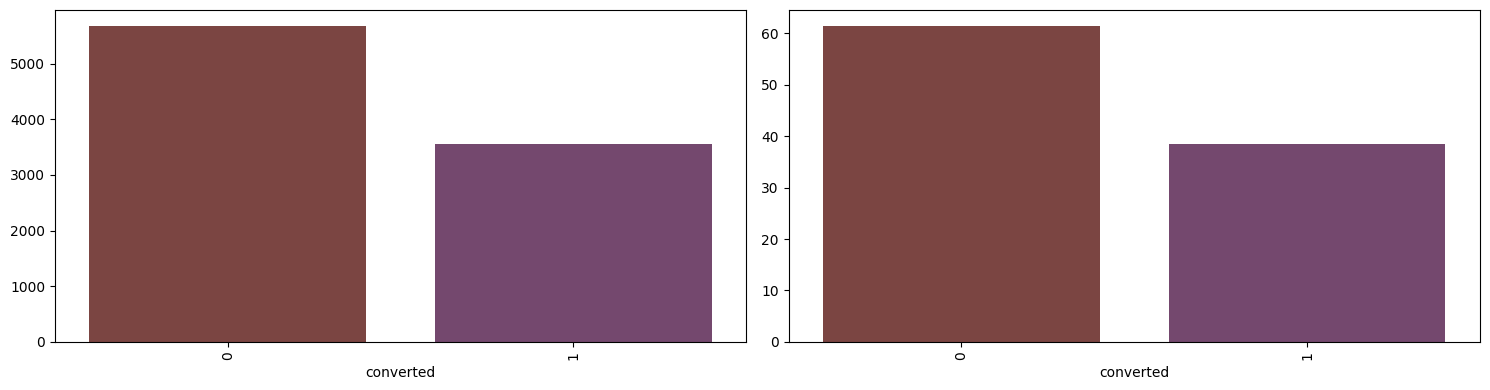

In [36]:
univariate_class_distribution_bar(target_data, target_variable[0])

In [37]:
# Calculating the probability of conversion
round(100*(sum(target_data[target_variable[0]])/target_data.shape[0]),2)

38.54

#### Observations:
- The data is imbalanced in nature
- Most of the data belongs to the non converting class
- There is only `38.54%` chance that a given lead would be converted

## 3.2 Analyzing the flag features

In [38]:
flags

['do_not_email',
 'do_not_call',
 'through_recommendations',
 'receive_more_updates_about_our_courses',
 'update_me_on_supply_chain_content',
 'get_updates_on_dm_content',
 'i_agree_to_pay_the_amount_through_cheque',
 'a_free_copy_of_mastering_the_interview']

In [39]:
# Separating the flag features distinctly
flag_data = data[unique_ids.__add__(target_variable).__add__(flags)]
flag_data.head(3)

prospect_id  lead_number  converted do_not_email  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0           No   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0           No   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1           No   

  do_not_call through_recommendations receive_more_updates_about_our_courses  \
0          No                      No                                     No   
1          No                      No                                     No   
2          No                      No                                     No   

  update_me_on_supply_chain_content get_updates_on_dm_content  \
0                                No                        No   
1                                No                        No   
2                                No                        No   

  i_agree_to_pay_the_amount_through_cheque  \
0                                       No   
1                                       No   
2                                       No   

  a_free_copy_of_mastering_the_interview  
0                                     No  
1                                     No  
2                                    Yes

do_not_email
Missing data count in ferature do_not_email : 0
Missing data percentage in ferature do_not_email : 0

Categories distribution : do_not_email
No     92.06
Yes     7.94
Name: count, dtype: float64


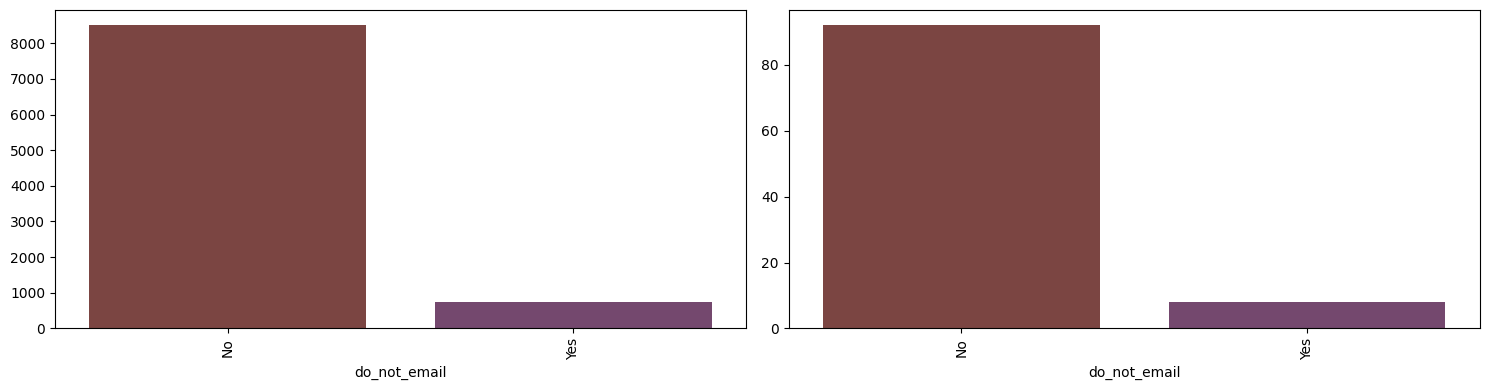


do_not_call
Missing data count in ferature do_not_call : 0
Missing data percentage in ferature do_not_call : 0

Categories distribution : do_not_call
No     99.98
Yes     0.02
Name: count, dtype: float64


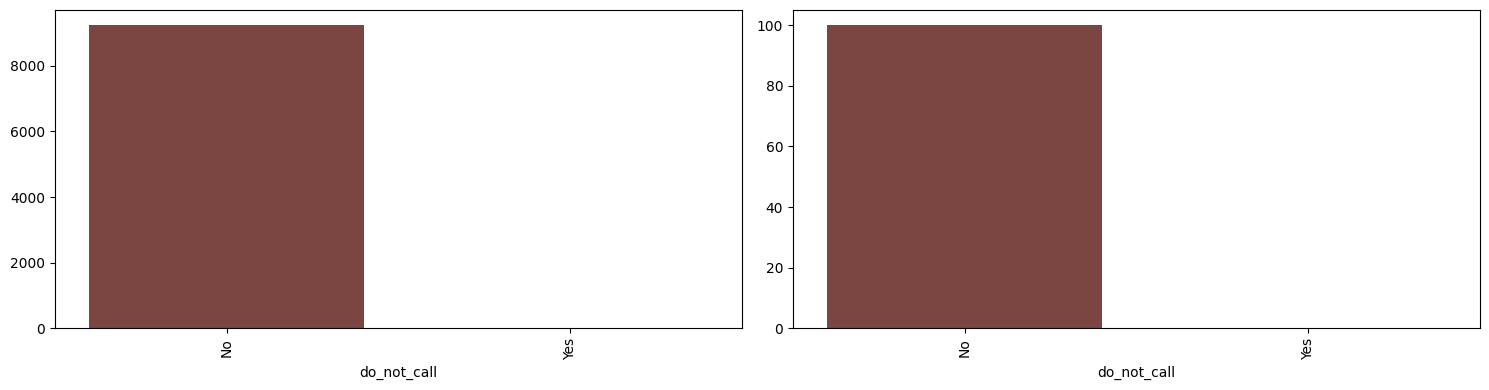


through_recommendations
Missing data count in ferature through_recommendations : 0
Missing data percentage in ferature through_recommendations : 0

Categories distribution : through_recommendations
No     99.92
Yes     0.08
Name: count, dtype: float64


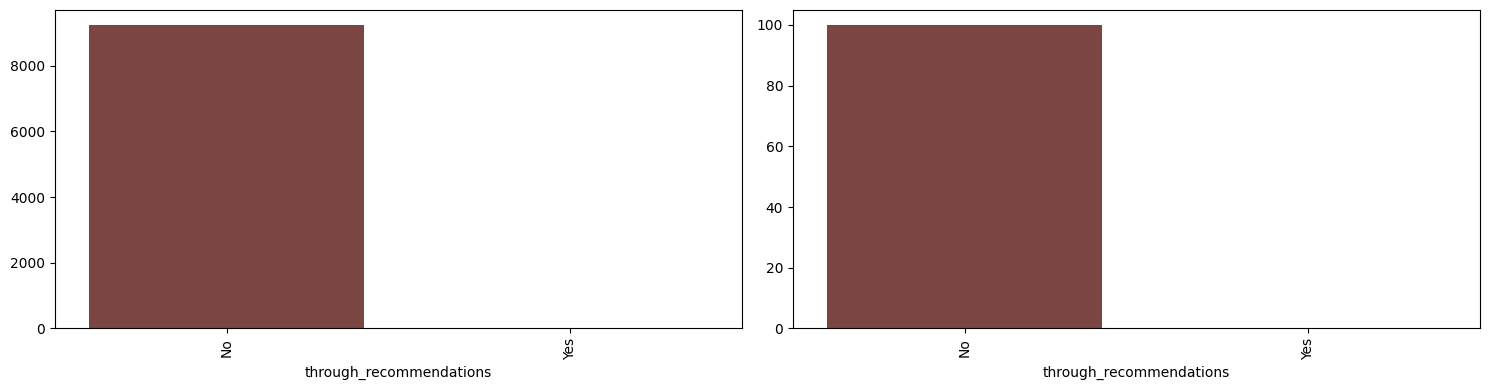


receive_more_updates_about_our_courses
Missing data count in ferature receive_more_updates_about_our_courses : 0
Missing data percentage in ferature receive_more_updates_about_our_courses : 0

Categories distribution : receive_more_updates_about_our_courses
No    100.0
Name: count, dtype: float64


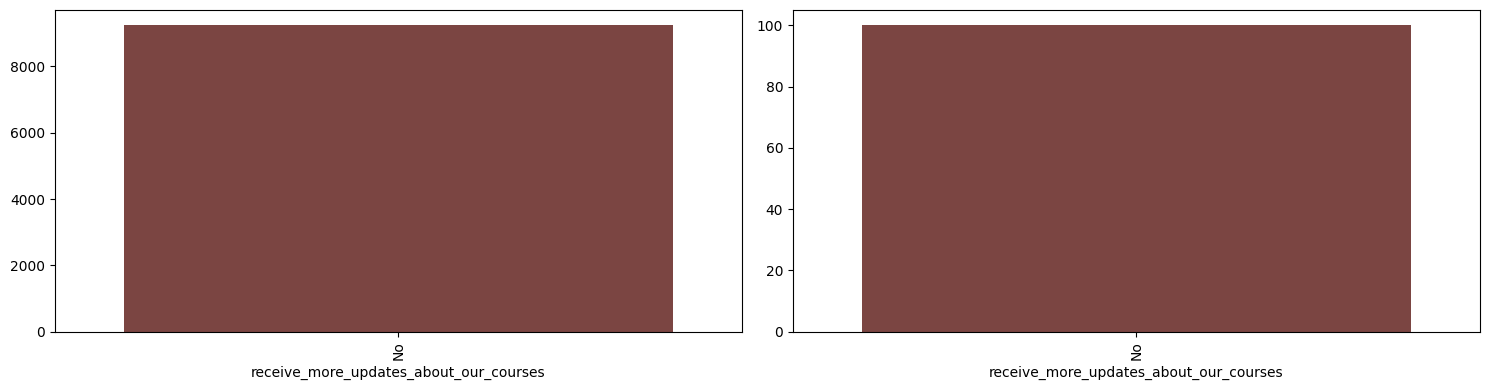


update_me_on_supply_chain_content
Missing data count in ferature update_me_on_supply_chain_content : 0
Missing data percentage in ferature update_me_on_supply_chain_content : 0

Categories distribution : update_me_on_supply_chain_content
No    100.0
Name: count, dtype: float64


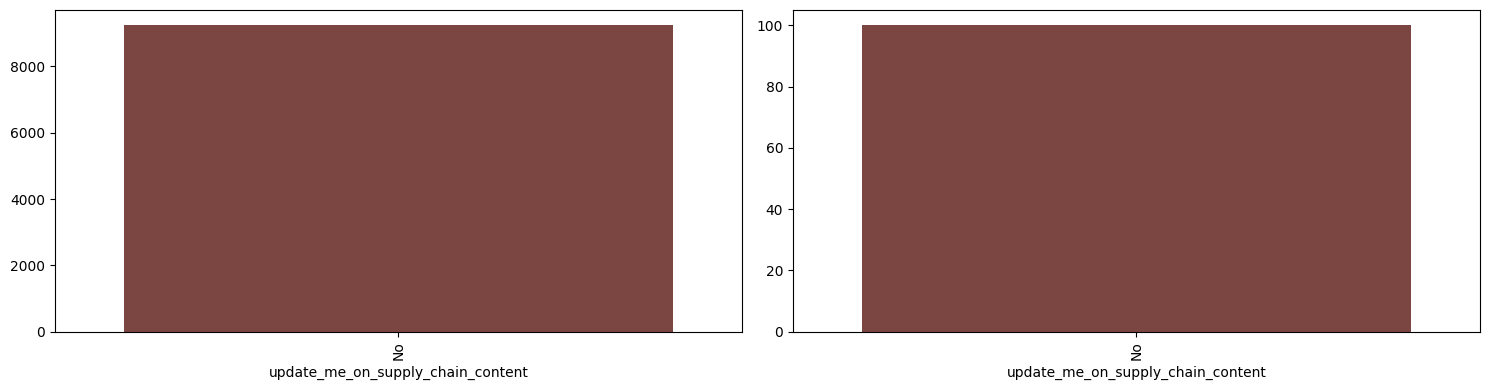


get_updates_on_dm_content
Missing data count in ferature get_updates_on_dm_content : 0
Missing data percentage in ferature get_updates_on_dm_content : 0

Categories distribution : get_updates_on_dm_content
No    100.0
Name: count, dtype: float64


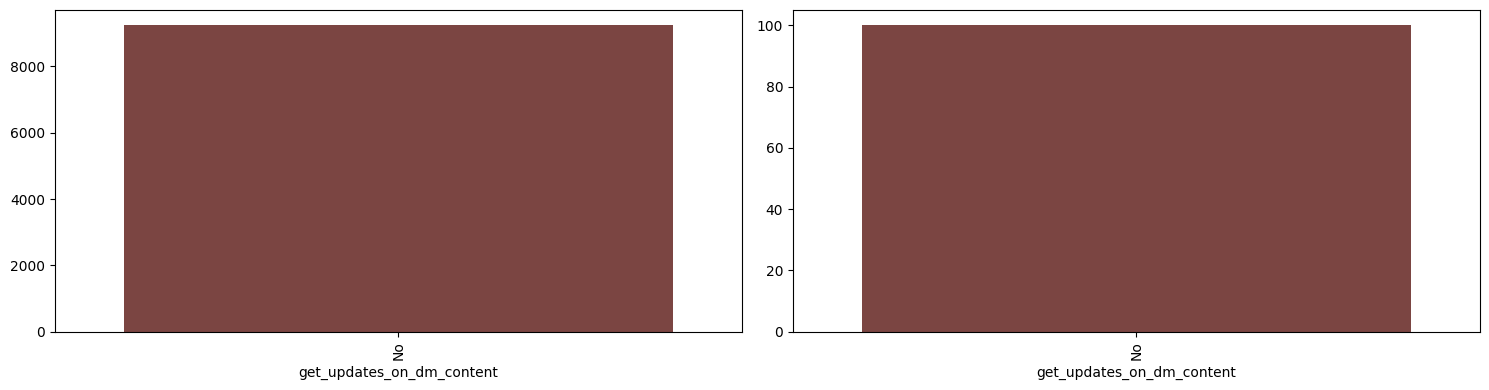


i_agree_to_pay_the_amount_through_cheque
Missing data count in ferature i_agree_to_pay_the_amount_through_cheque : 0
Missing data percentage in ferature i_agree_to_pay_the_amount_through_cheque : 0

Categories distribution : i_agree_to_pay_the_amount_through_cheque
No    100.0
Name: count, dtype: float64


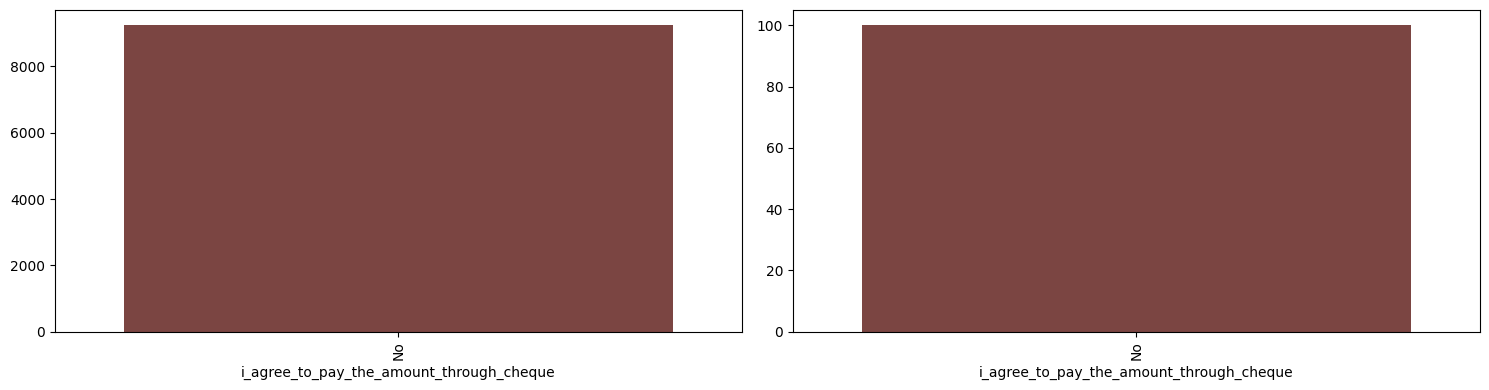


a_free_copy_of_mastering_the_interview
Missing data count in ferature a_free_copy_of_mastering_the_interview : 0
Missing data percentage in ferature a_free_copy_of_mastering_the_interview : 0

Categories distribution : a_free_copy_of_mastering_the_interview
No     68.74
Yes    31.26
Name: count, dtype: float64


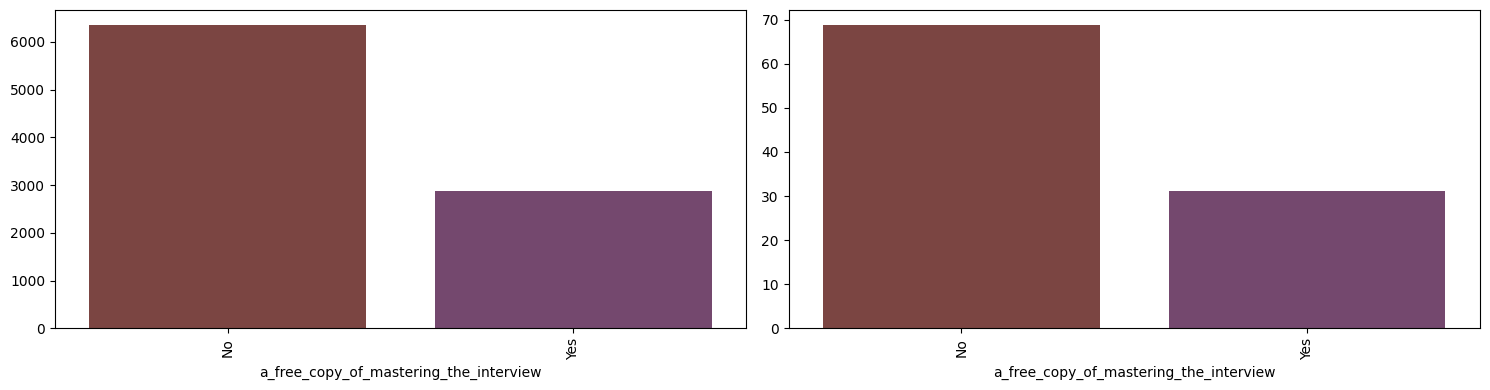

In [40]:
# checking for the distribution of the flags accross the classes
for feature in flags:
    print(feature)
    print(f'Missing data count in ferature {feature} : {flag_data[feature].isna().sum()}')
    print(f'Missing data percentage in ferature {feature} : {round(100*(flag_data[feature].isna().sum()),2)}')
    print()
    print(f'Categories distribution : {round(100*(flag_data[feature].value_counts()/flag_data.shape[0]),2)}')
    univariate_class_distribution_bar(flag_data, feature)
    print()

#### Note:
- As we can see from the plots there are numerous flag features that have significantly lower proportional distributions
- There are only one feature that has a good enough distribution to be counted for i.e `a_free_copy_of_mastering_the_interview`
- We can drop all other flag features except this

In [41]:
# Final flag data that can be considered
flag_data = flag_data[unique_ids.__add__(target_variable).__add__(['a_free_copy_of_mastering_the_interview'])]
flag_data

prospect_id  lead_number  converted  \
0     7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1     2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2     8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   
3     0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719          0   
4     3256f628-e534-4826-9d63-4a8b88782852       660681          1   
...                                    ...          ...        ...   
9235  19d6451e-fcd6-407c-b83b-48e1af805ea9       579564          1   
9236  82a7005b-7196-4d56-95ce-a79f937a158d       579546          0   
9237  aac550fe-a586-452d-8d3c-f1b62c94e02c       579545          0   
9238  5330a7d1-2f2b-4df4-85d6-64ca2f6b95b9       579538          1   
9239  571b5c8e-a5b2-4d57-8574-f2ffb06fdeff       579533          1   

     a_free_copy_of_mastering_the_interview  
0                                        No  
1                                        No  
2                                       Yes  
3                                        No  
4                                        No  
...                                     ...  
9235                                     No  
9236                                    Yes  
9237                                    Yes  
9238                                     No  
9239                                    Yes  

[9240 rows x 4 columns]

In [42]:
flag_data['a_free_copy_of_mastering_the_interview'] = flag_data['a_free_copy_of_mastering_the_interview'].replace({'Yes':1, 'No':0})
flag_data.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

   a_free_copy_of_mastering_the_interview  
0                                       0  
1                                       0  
2                                       1

In [43]:
flag_data.isna().sum()

prospect_id                               0
lead_number                               0
converted                                 0
a_free_copy_of_mastering_the_interview    0
dtype: int64

## 3.3 Analyzing the numerical features

In [44]:
numerical_features

['totalvisits', 'total_time_spent_on_website', 'page_views_per_visit']

In [45]:
# Getting the numerical data subset
numerical_data = data[unique_ids.__add__(target_variable).__add__(numerical_features)]
numerical_data.head(3)

prospect_id  lead_number  converted  totalvisits  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0          0.0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0          5.0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1          2.0   

   total_time_spent_on_website  page_views_per_visit  
0                            0                   0.0  
1                          674                   2.5  
2                         1532                   2.0

In [46]:
# Missing values count lookup
numerical_data.isna().sum()

prospect_id                      0
lead_number                      0
converted                        0
totalvisits                    137
total_time_spent_on_website      0
page_views_per_visit           137
dtype: int64

In [47]:
# Missing values proportion lookup
round(100*(numerical_data.isna().sum()/numerical_data.shape[0]),2)

prospect_id                    0.00
lead_number                    0.00
converted                      0.00
totalvisits                    1.48
total_time_spent_on_website    0.00
page_views_per_visit           1.48
dtype: float64

### 3.3.1 totalvisits

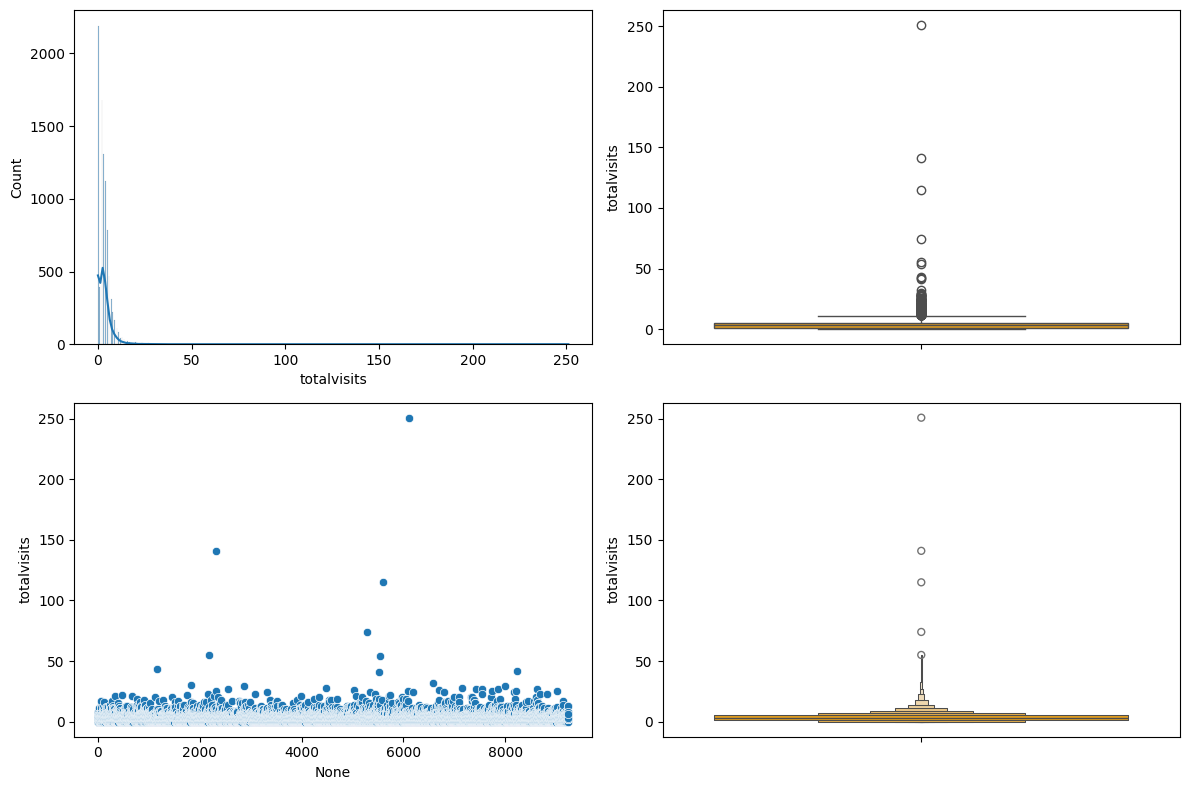

In [48]:
# Univariate analysis
numerical_data_plots(numerical_data, 'totalvisits')

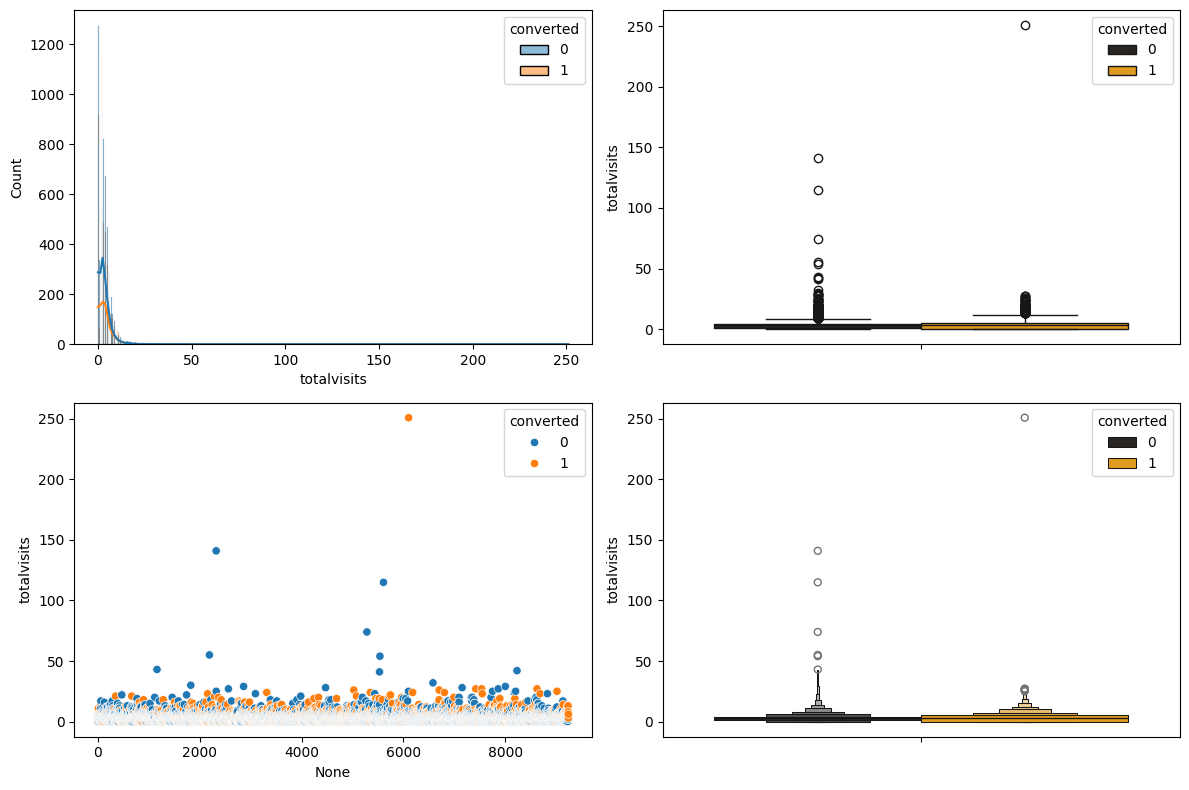

In [49]:
# Bivariate analysis
numerical_data_plots(numerical_data, 'totalvisits', 'converted')

In [50]:
point_biserial_correlation_coefficient(numerical_data, 'totalvisits', 'converted')

The p-value is : 0.00373
The correlation is statistically significant !
The point biserial correlation between totalvisits and the converted is :0.0304.


0.03039479882934876

##### Observations:
- Statistically significant relationship between `totalvisits` and `converted` has been found
- From the above graphs, it is evident that there are a lot of outliers in the `totalvisits` feature
- Highly skewed data
- The means across both the groups of the target variable does not differ very much
- The non-converted segment has considerably more outliers than the converted segment

##### Conclusions:
- The converted segment data usually lies within the lower ranges; typically below 200
- The highest `totalvisits` belong to the non-converted segment; such entries might be pointing towards the web-crawlers or people who are indecisive

##### Possible Solutions:
- We can opt to clean up the outliers using IQR
- We can opt to replace the values of the feature by the woe obtained by discretizing the feature

### 3.3.2 total_time_spent_on_website

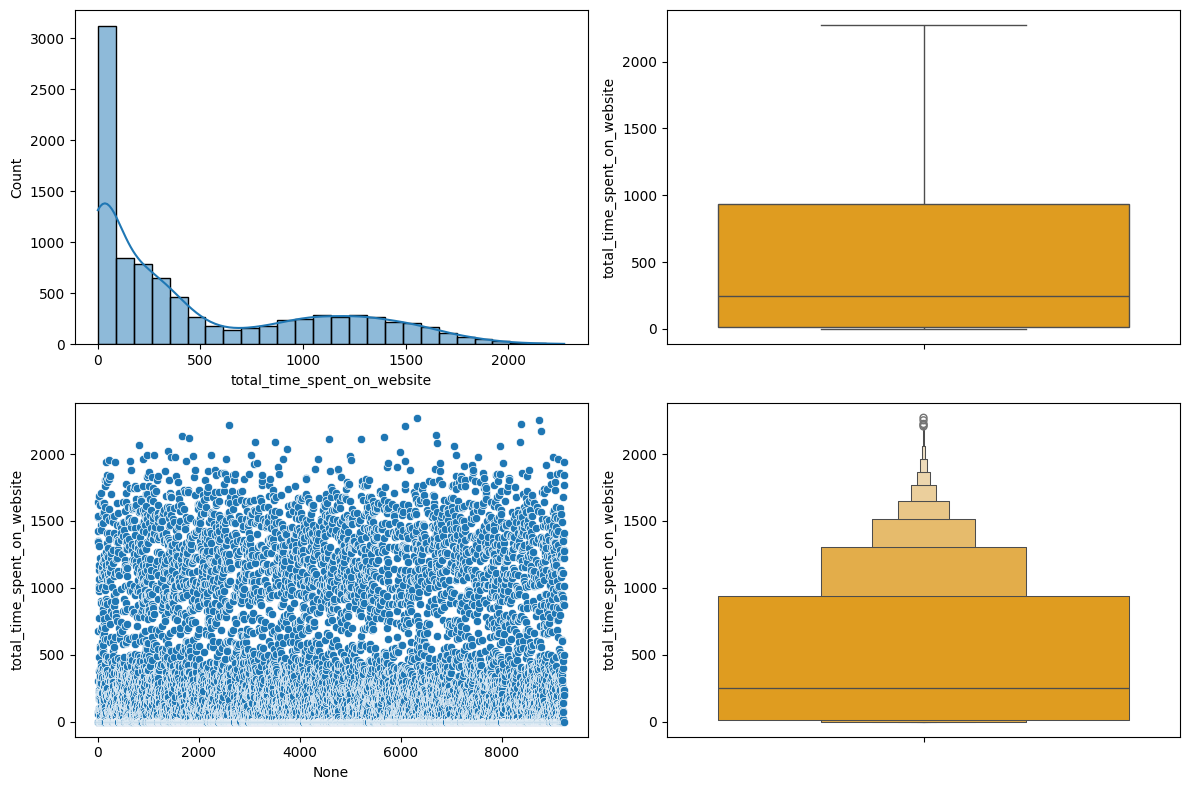

In [51]:
# Univariate analysis
numerical_data_plots(numerical_data, 'total_time_spent_on_website')

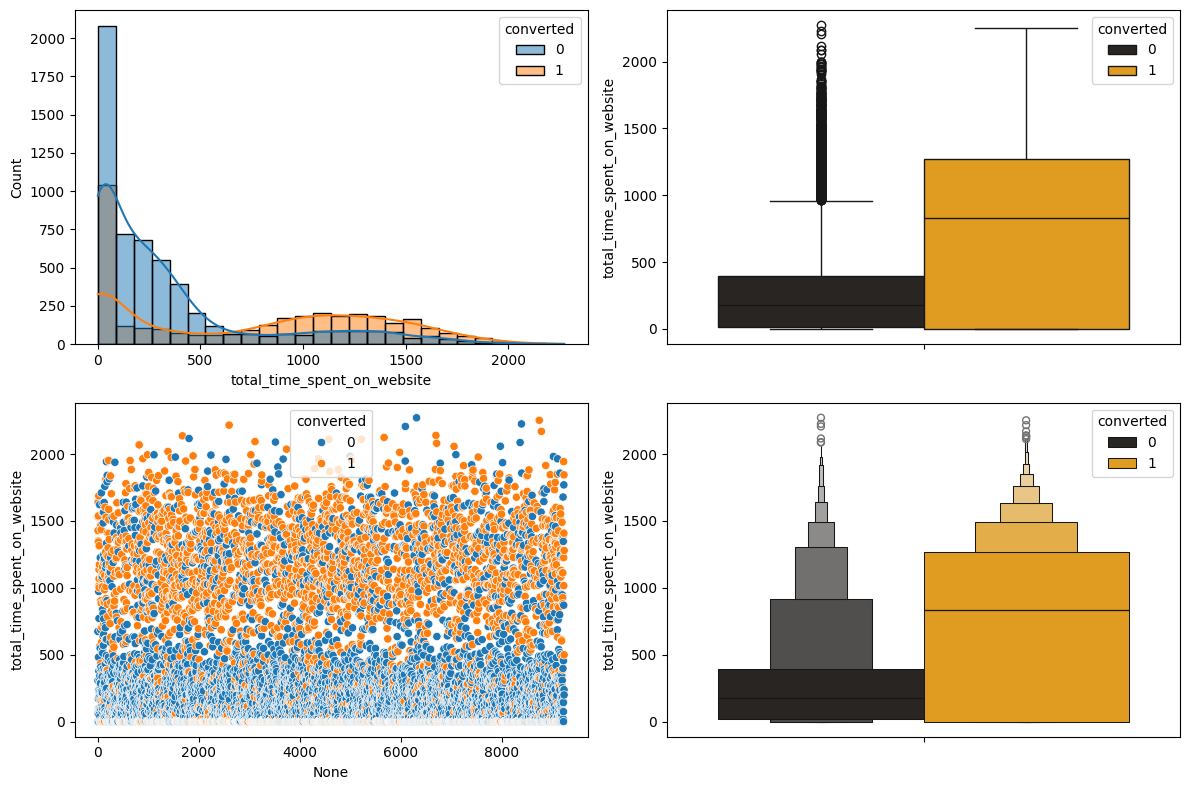

In [52]:
# Bivariate analysis
numerical_data_plots(numerical_data, 'total_time_spent_on_website', 'converted')

In [53]:
point_biserial_correlation_coefficient(numerical_data, 'total_time_spent_on_website', 'converted')

The p-value is : 6.06e-285
The correlation is statistically significant !
The point biserial correlation between total_time_spent_on_website and the converted is :0.362.


0.36248285688957554

##### Observations:
- While the data is skewed, there are some prominent patterns that can be found

##### Conclusions:
- The average time that a candidate from the converted segment spends on the website is much more than that of one in the non-converted segment
- Most of the candidates from the non-converted segment spend no time on the website
- There is a significant chunk of non-converted's that spend a lot of time on the website; might be web crawlers or indecisive candidates

##### Possible Solutions:
- Outlier treatment
- Discretization or replacement by WOE

### 3.3.3 page_views_per_visit

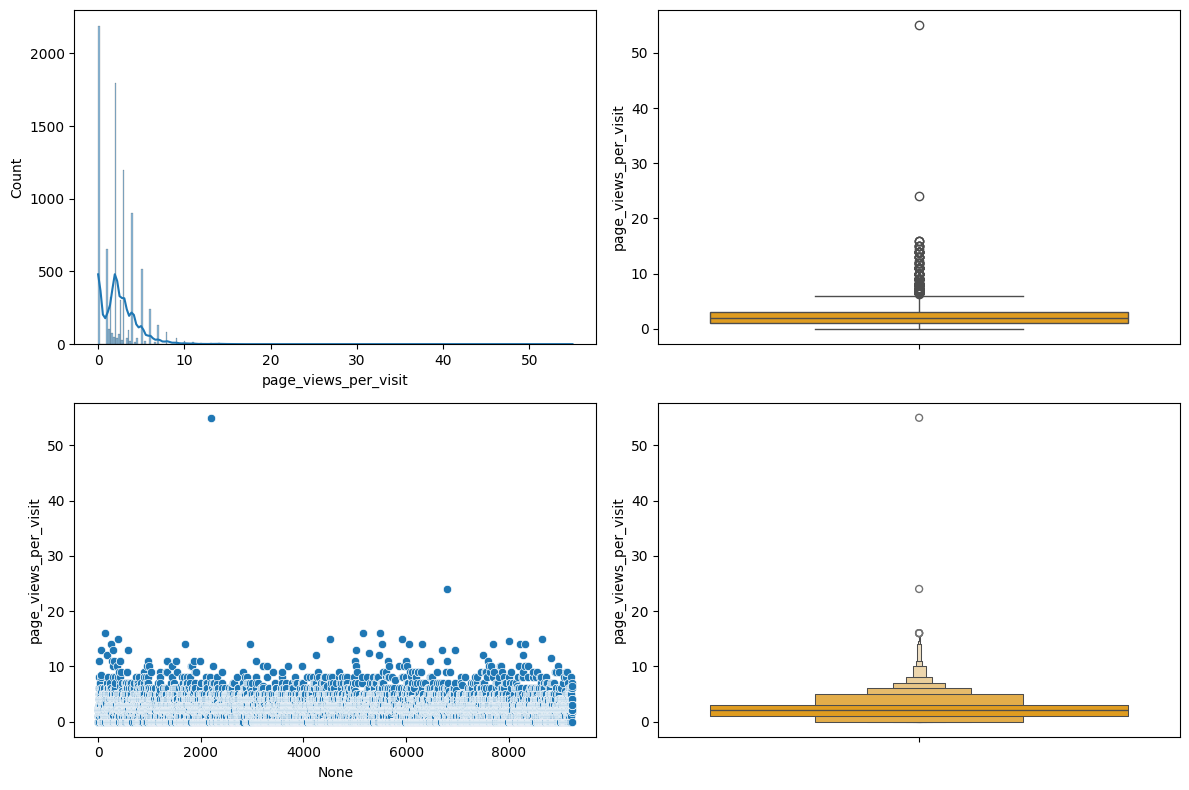

In [54]:
# Univariate analysis
numerical_data_plots(numerical_data, 'page_views_per_visit')

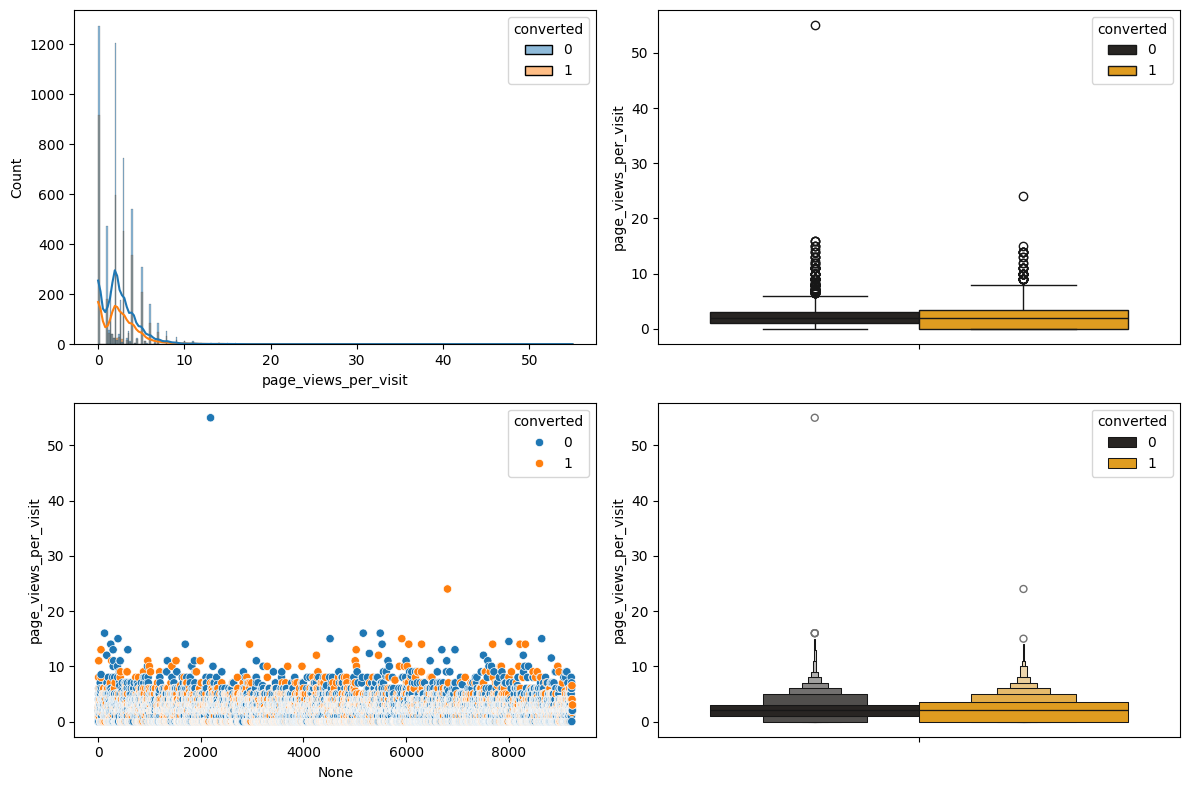

In [55]:
# Bivariate analysis
numerical_data_plots(numerical_data, 'page_views_per_visit', 'converted')

In [56]:
point_biserial_correlation_coefficient(numerical_data, 'page_views_per_visit', 'converted')

The p-value is : 0.751
The correlation is not statistically significant !
The point biserial correlation between page_views_per_visit and the converted is :-0.00333.


-0.003327511589634418

##### Observations:
- The distribution seems almost random in nature
- The means for both the converted and the non-converteds almost collide and mimics each other depicting no such differences amongst both
- The point-biserial correlation also suggests an insignificant relationship

##### Possible Solutions:
- Can try to clean the data up and improve the correlation with the target

## 3.4 Analyzing the categorical features

In [57]:
categorical_features

['advertisement_channel',
 'lead_origin',
 'lead_source',
 'last_activity',
 'country',
 'specialization',
 'how_did_you_hear_about_x_education',
 'what_is_your_current_occupation',
 'last_notable_activity',
 'what_matters_most_to_you_in_choosing_a_course',
 'tags',
 'lead_quality',
 'lead_profile',
 'city']

In [58]:
# Getting the categorical data subset
categorical_data = data[unique_ids.__add__(target_variable).__add__(categorical_features)]
categorical_data.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

  advertisement_channel              lead_origin     lead_source  \
0               unknown                      API      Olark Chat   
1               unknown                      API  Organic Search   
2               unknown  Landing Page Submission  Direct Traffic   

             last_activity country           specialization  \
0  Page Visited on Website     NaN                   Select   
1             Email Opened   India                   Select   
2             Email Opened   India  Business Administration   

  how_did_you_hear_about_x_education what_is_your_current_occupation  \
0                             Select                      Unemployed   
1                             Select                      Unemployed   
2                             Select                         Student   

  last_notable_activity what_matters_most_to_you_in_choosing_a_course  \
0              Modified                       Better Career Prospects   
1          Email Opened                       Better Career Prospects   
2          Email Opened                       Better Career Prospects   

                                  tags      lead_quality    lead_profile  \
0          Interested in other courses  Low in Relevance          Select   
1                              Ringing               NaN          Select   
2  Will revert after reading the email          Might be  Potential Lead   

     city  
0  Select  
1  Select  
2  Mumbai

In [59]:
categorical_data.isna().sum()

prospect_id                                         0
lead_number                                         0
converted                                           0
advertisement_channel                               0
lead_origin                                         0
lead_source                                        36
last_activity                                     103
country                                          2461
specialization                                   1438
how_did_you_hear_about_x_education               2207
what_is_your_current_occupation                  2690
last_notable_activity                               0
what_matters_most_to_you_in_choosing_a_course    2709
tags                                             3353
lead_quality                                     4767
lead_profile                                     2709
city                                             1420
dtype: int64

In [60]:
percent_missing = round(100*(categorical_data.isna().sum()/categorical_data.shape[0]), 2)

print('*'*114)
print('Data with missing data less than 25%')
print()
print(percent_missing[percent_missing<25])
print('*'*114)

print()
print('Data with missing data more than 25%')
print()
print(percent_missing[percent_missing>25])
print('*'*114)

******************************************************************************************************************
Data with missing data less than 25%

prospect_id                            0.00
lead_number                            0.00
converted                              0.00
advertisement_channel                  0.00
lead_origin                            0.00
lead_source                            0.39
last_activity                          1.11
specialization                        15.56
how_did_you_hear_about_x_education    23.89
last_notable_activity                  0.00
city                                  15.37
dtype: float64
******************************************************************************************************************

Data with missing data more than 25%

country                                          26.63
what_is_your_current_occupation                  29.11
what_matters_most_to_you_in_choosing_a_course    29.32
tags                         

##### Observations:
- There are several features with missing data more than 50%
- We can put on a threshold in the permissible percentage of missing values in order to improvise the quality of the dataset
- The features with high proportions of misisng data can either be dropped or be imputed as per the requirements

### 3.4.1 advertisement_channel

In [61]:
categorical_data.advertisement_channel.isna().sum()

0

In [62]:
categorical_data.advertisement_channel.value_counts()

advertisement_channel
unknown                  9221
search                     14
digital_advertisement       3
newspaper                   2
Name: count, dtype: int64

In [63]:
round(100*(categorical_data.advertisement_channel.value_counts()/categorical_data.shape[0]), 2)

advertisement_channel
unknown                  99.79
search                    0.15
digital_advertisement     0.03
newspaper                 0.02
Name: count, dtype: float64

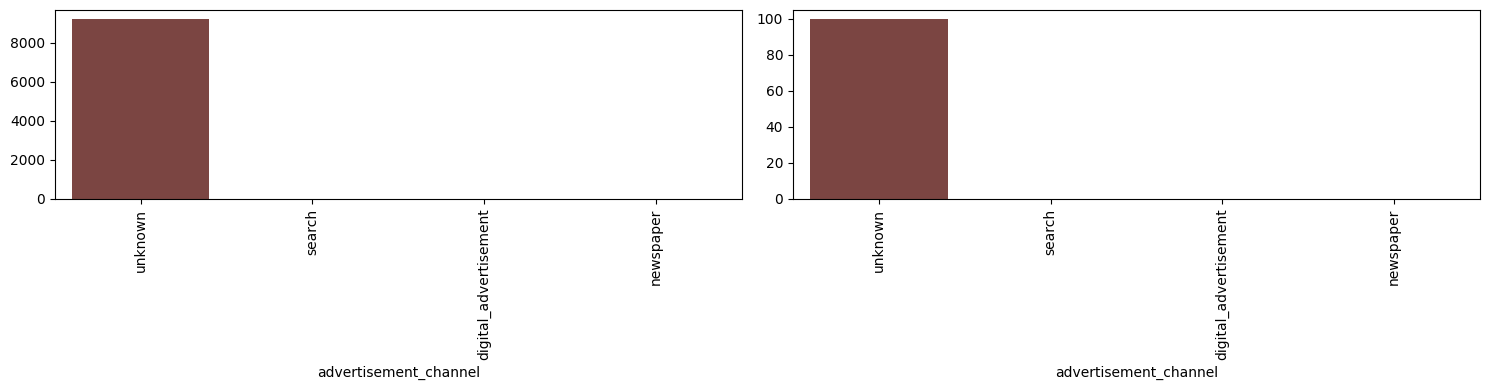

In [64]:
univariate_class_distribution_bar(categorical_data, 'advertisement_channel')

<Axes: xlabel='advertisement_channel'>

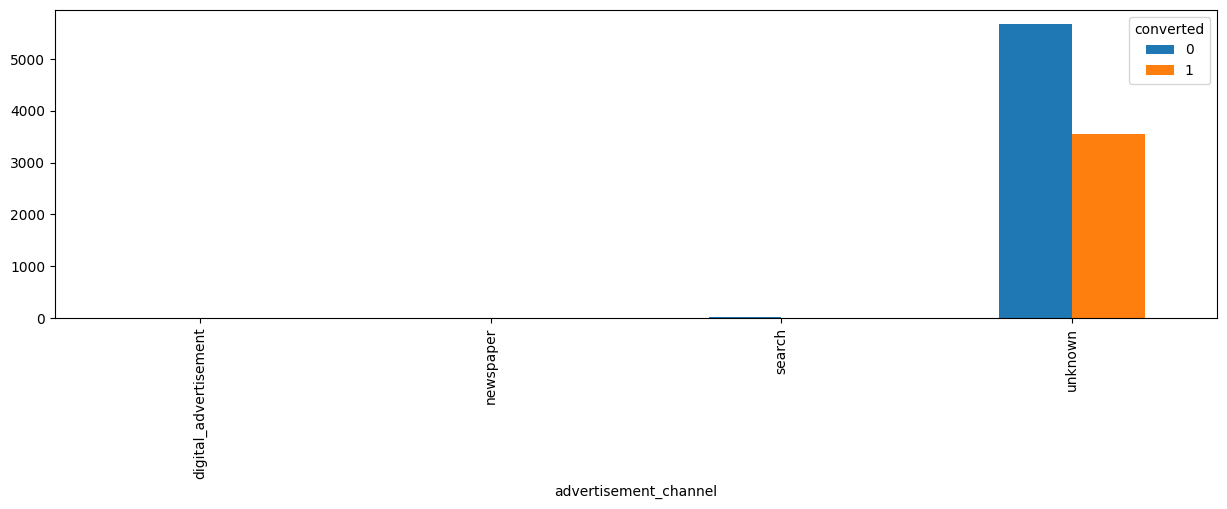

In [65]:
crs = pd.crosstab(index = categorical_data.advertisement_channel, columns = categorical_data.converted)
crs.plot.bar(figsize = (15,4))


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 0.9788
- The chi2 discrepancy is : 0.19244
	- We failed to reject the Null Hypothesis
	- The features advertisement_channel and converted are independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


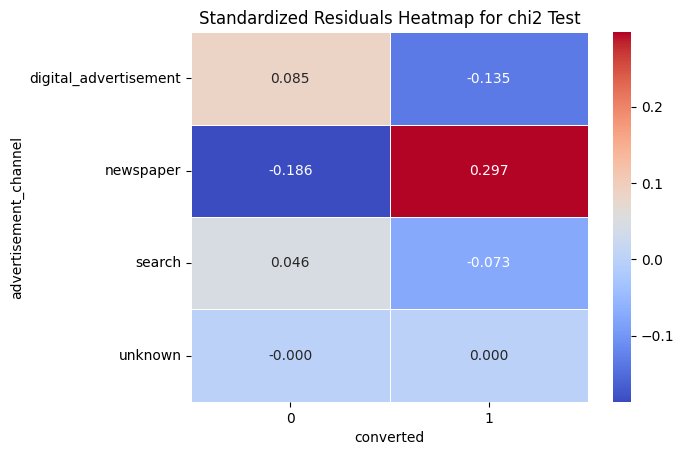

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.00456
	- There is a very weak association between advertisement_channel and converted
************************************************************************************************************

In [66]:
# Analyzing the relationship between `advertisement_channel` and the target feature `converted`
cat_to_cat_association_tests(categorical_data, 'advertisement_channel', 'converted')

In [67]:
# Point Biserial correlation coefficient
point_biserial_categorical_correlation(categorical_data, 'advertisement_channel', 'converted')

The p-value is 0.90519.
The correlation is not statistically significant !
The point biserial correlation between advertisement_channel and the converted is :-0.00124.


-0.0012393034599357455

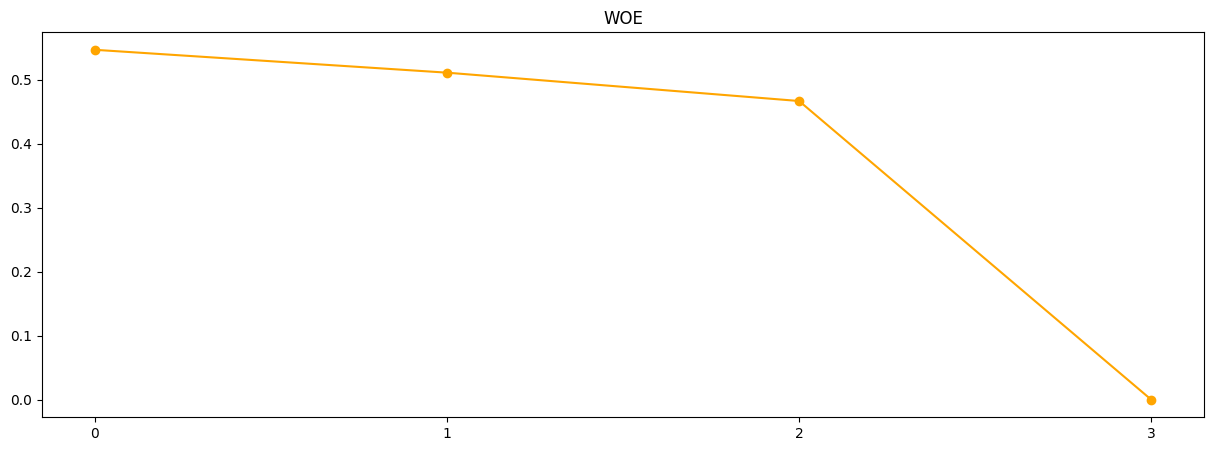

Value  Event  Non-Event       WOE        IV
0                 search      5          9  0.546544  0.285714
1  digital_advertisement      1          2  0.510826  0.333333
2                unknown   3554       5667  0.466534  0.229151
3              newspaper      1          1  0.000000  0.000000

In [68]:
# WOE
calculate_woe_iv(categorical_data, 'advertisement_channel', 'converted')

##### Observations:
- There is a very huge imbalance of sources in the `advertisements channels`
- 99.79% of the observations advertisement source is unknown
- As per the chi2 test, crammers v and theils uncertainity values, the association of `advertisement_channel` with the `target` is very weak
- The same is also concluded by the point biserial correlation coefficient with the target

In [69]:
# Removing the advertisement channel
categorical_data = categorical_data.drop(columns = ['advertisement_channel'])
categorical_data.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

               lead_origin     lead_source            last_activity country  \
0                      API      Olark Chat  Page Visited on Website     NaN   
1                      API  Organic Search             Email Opened   India   
2  Landing Page Submission  Direct Traffic             Email Opened   India   

            specialization how_did_you_hear_about_x_education  \
0                   Select                             Select   
1                   Select                             Select   
2  Business Administration                             Select   

  what_is_your_current_occupation last_notable_activity  \
0                      Unemployed              Modified   
1                      Unemployed          Email Opened   
2                         Student          Email Opened   

  what_matters_most_to_you_in_choosing_a_course  \
0                       Better Career Prospects   
1                       Better Career Prospects   
2                       Better Career Prospects   

                                  tags      lead_quality    lead_profile  \
0          Interested in other courses  Low in Relevance          Select   
1                              Ringing               NaN          Select   
2  Will revert after reading the email          Might be  Potential Lead   

     city  
0  Select  
1  Select  
2  Mumbai

### 3.4.2 lead_origin

In [70]:
categorical_data.lead_origin.isna().sum()

0

In [71]:
categorical_data.lead_origin.value_counts()

lead_origin
Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: count, dtype: int64

In [72]:
round(100*(categorical_data.lead_origin.value_counts()/categorical_data.shape[0]), 2)

lead_origin
Landing Page Submission    52.88
API                        38.74
Lead Add Form               7.77
Lead Import                 0.60
Quick Add Form              0.01
Name: count, dtype: float64

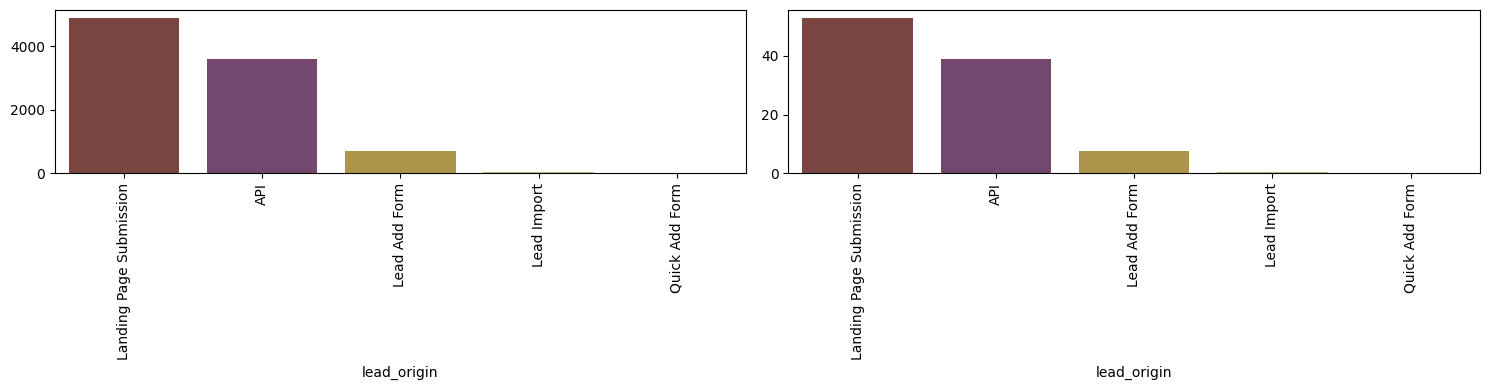

In [73]:
univariate_class_distribution_bar(categorical_data, 'lead_origin')

<Axes: xlabel='lead_origin'>

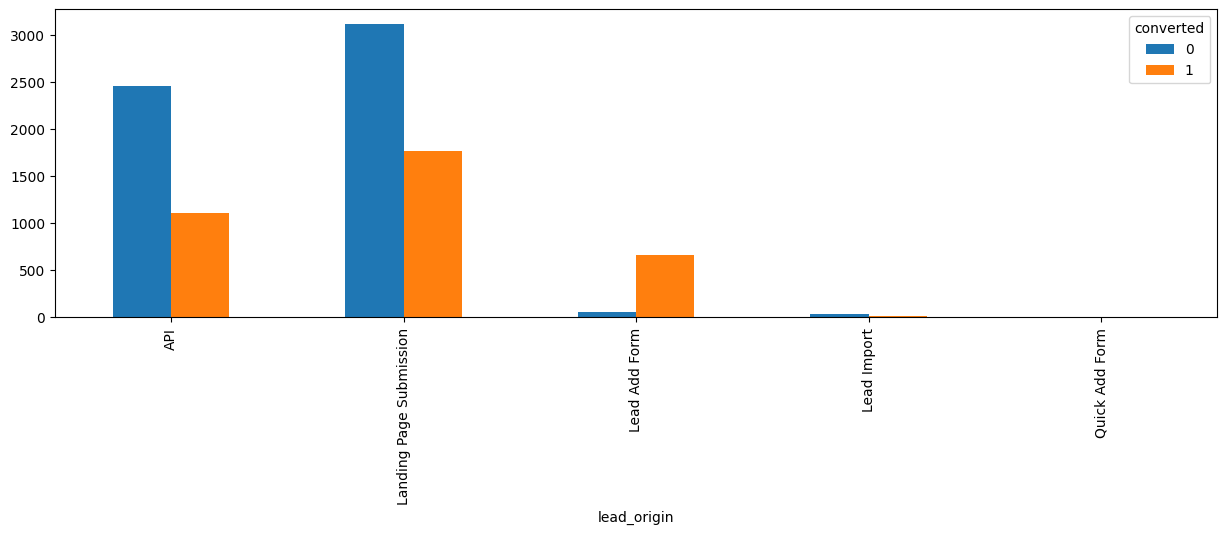

In [74]:
crs = pd.crosstab(index = categorical_data.lead_origin, columns = categorical_data.converted)
crs.plot.bar(figsize = (15,4))


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 1.9383e-211
- The chi2 discrepancy is : 982.77
	- We can reject the Null Hypothesis
	- The features lead_origin and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


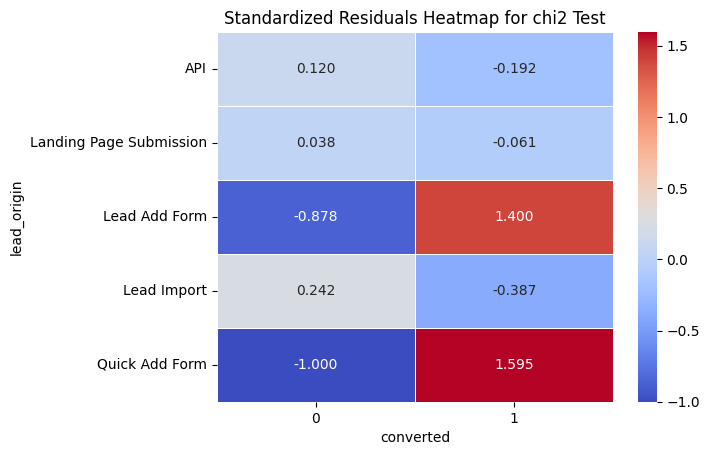

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.326
	- There is a moderately strong association between lead_origin and converted
****************************************************************************************************************

In [75]:
cat_to_cat_association_tests(categorical_data, 'lead_origin', 'converted')

In [76]:
# Point Biserial Correlation
point_biserial_categorical_correlation(categorical_data, 'lead_origin', 'converted')

The p-value is 3.6519e-105.
The correlation is statistically significant !
The point biserial correlation between lead_origin and the converted is :0.224.


0.2237246844698888

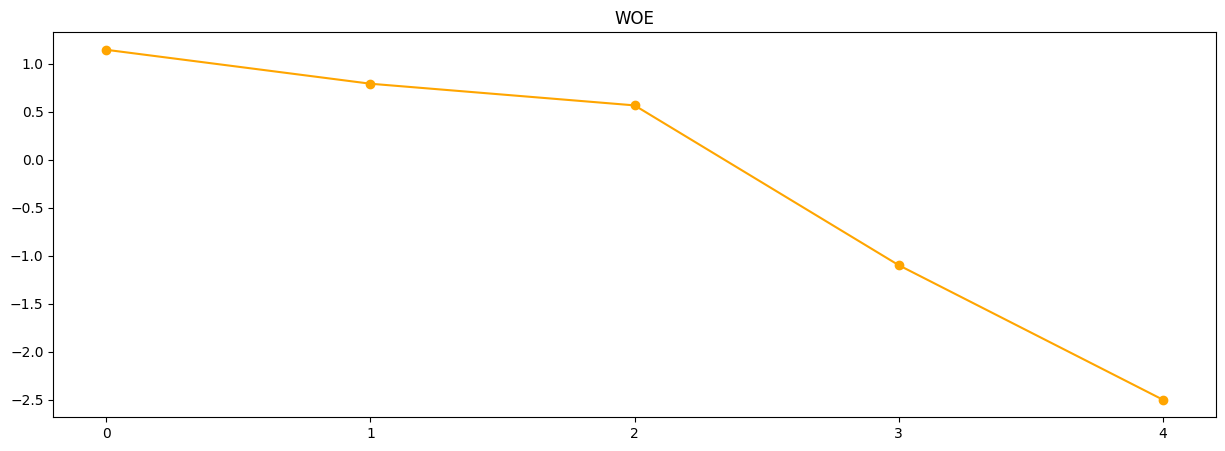

Value  Event  Non-Event       WOE        IV
0              Lead Import     13         42  1.146814  0.527273
1                      API   1115       2465  0.793092  0.377095
2  Landing Page Submission   1768       3118  0.567220  0.276300
3           Quick Add Form      1          0 -1.098612 -1.000000
4            Lead Add Form    664         54 -2.500834 -0.849582

In [77]:
# WOE
calculate_woe_iv(categorical_data, 'lead_origin', 'converted')

In [78]:
dummy = categorical_data[unique_ids.__add__(target_variable).__add__(['lead_origin'])]
dummy.head()

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719          0   
4  3256f628-e534-4826-9d63-4a8b88782852       660681          1   

               lead_origin  
0                      API  
1                      API  
2  Landing Page Submission  
3  Landing Page Submission  
4  Landing Page Submission

In [79]:
dummy['lead_origin_2'] = np.where(dummy.lead_origin.isin(['API', 'Landing Page Submission']), 'api or landing page submission', dummy.lead_origin)
dummy.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

               lead_origin                   lead_origin_2  
0                      API  api or landing page submission  
1                      API  api or landing page submission  
2  Landing Page Submission  api or landing page submission


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 6.3062e-208
- The chi2 discrepancy is : 960.61
	- We can reject the Null Hypothesis
	- The features lead_origin_2 and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


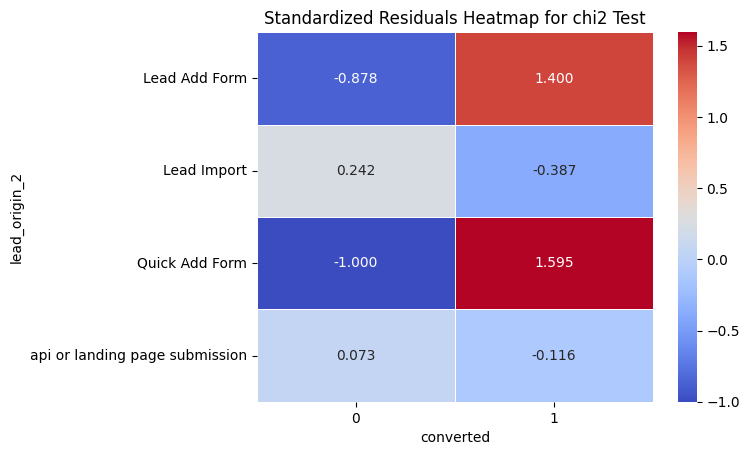

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.322
	- There is a moderately strong association between lead_origin_2 and converted
**************************************************************************************************************

In [80]:
cat_to_cat_association_tests(dummy, 'lead_origin_2', 'converted')

In [81]:
# Point Biserial Correlation
point_biserial_categorical_correlation(dummy, 'lead_origin_2', 'converted')

The p-value is 8.1472e-154.
The correlation is statistically significant !
The point biserial correlation between lead_origin_2 and the converted is :0.27.


0.26977241401757224

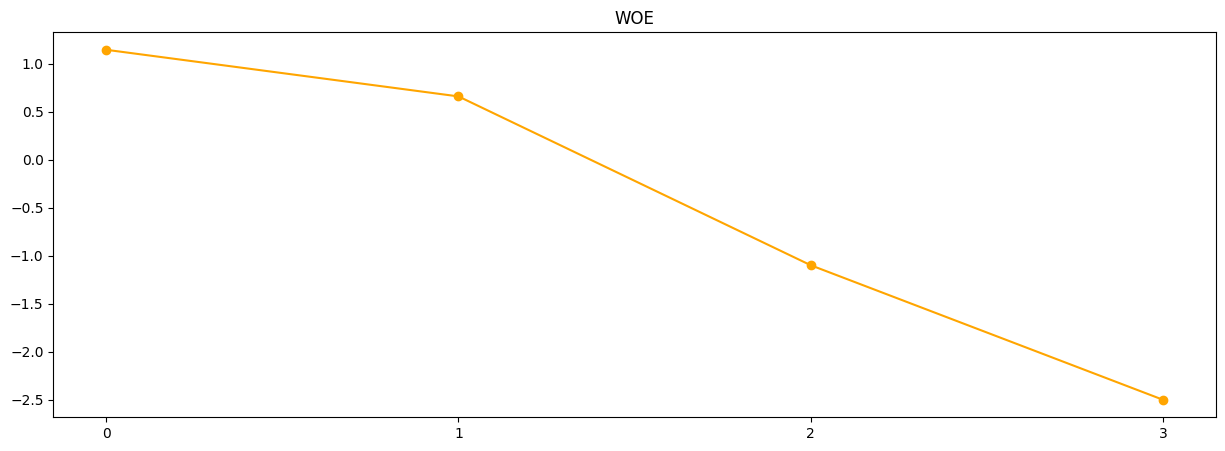

Value  Event  Non-Event       WOE        IV
0                     Lead Import     13         42  1.146814  0.527273
1  api or landing page submission   2883       5583  0.660811  0.318923
2                  Quick Add Form      1          0 -1.098612 -1.000000
3                   Lead Add Form    664         54 -2.500834 -0.849582

In [82]:
# WOE
calculate_woe_iv(dummy, 'lead_origin_2', 'converted')

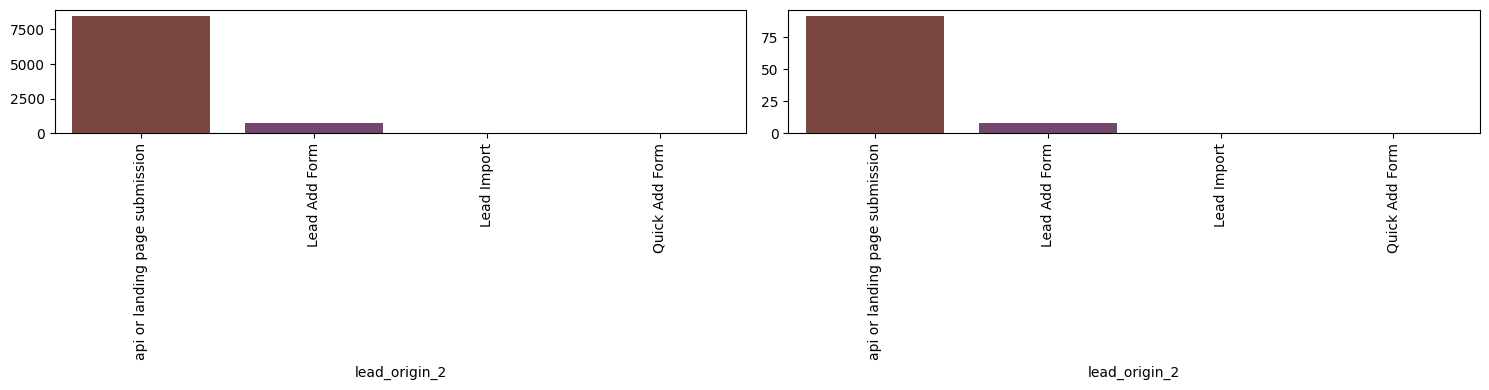

In [83]:
univariate_class_distribution_bar(dummy, 'lead_origin_2')

##### Observations:
- Out of all the categories, `Landing page submission` and `api` contribute to most of the leads but their conversion rate is not too high
- Lead add form has a very high conversion rate but it comprises of only 7% of the entire data
- The stats state that the feature `lead_origin` is statistically correlated with the target
- The correlation is moderate

- On combining the `api` and the `landing page submission` categories, improvements in the correlations and measurements of associations can be observed but the differences are not very significant

### 3.4.3 lead_source

In [84]:
categorical_data.lead_source.value_counts()

lead_source
Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: count, dtype: int64

##### Note:
- There are several discrepancies in the category
- Rectifying the same

In [85]:
# Normalizing the case
categorical_data['lead_source'] = categorical_data.lead_source.str.lower()

# Rectifying the categories
lead_source_mapper = {'welearnblog_home':'welearn'}
categorical_data['lead_source'] = categorical_data.lead_source.replace(lead_source_mapper)
categorical_data.lead_source.value_counts()

lead_source
google               2873
direct traffic       2543
olark chat           1755
organic search       1154
reference             534
welingak website      142
referral sites        125
facebook               55
bing                    6
click2call              4
press_release           2
social media            2
welearn                 2
live chat               2
testone                 1
pay per click ads       1
youtubechannel          1
blog                    1
nc_edm                  1
Name: count, dtype: int64

In [86]:
round(100*(categorical_data.lead_source.value_counts()/categorical_data.shape[0]),2)

lead_source
google               31.09
direct traffic       27.52
olark chat           18.99
organic search       12.49
reference             5.78
welingak website      1.54
referral sites        1.35
facebook              0.60
bing                  0.06
click2call            0.04
press_release         0.02
social media          0.02
welearn               0.02
live chat             0.02
testone               0.01
pay per click ads     0.01
youtubechannel        0.01
blog                  0.01
nc_edm                0.01
Name: count, dtype: float64

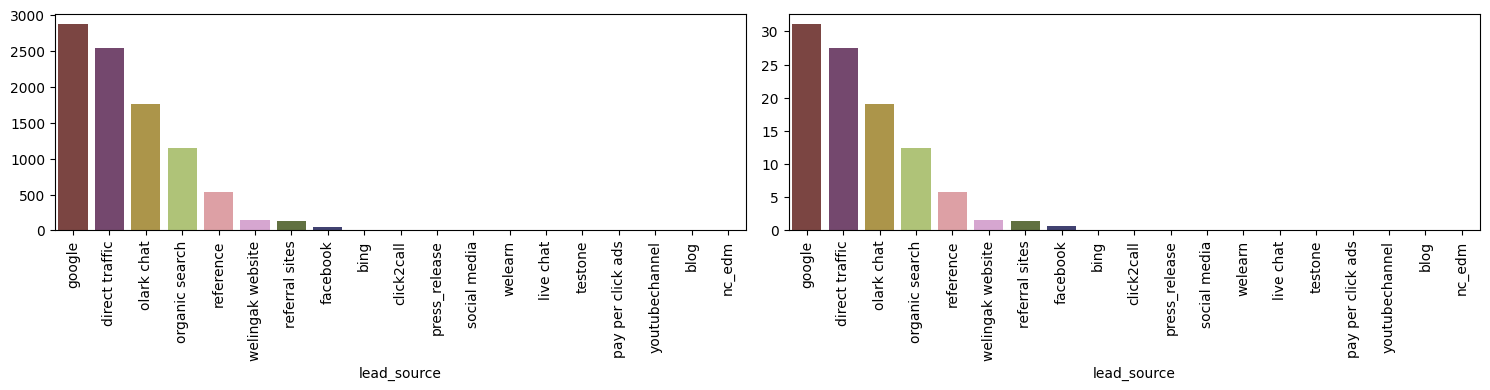

In [87]:
univariate_class_distribution_bar(categorical_data, 'lead_source')

<Axes: xlabel='lead_source'>

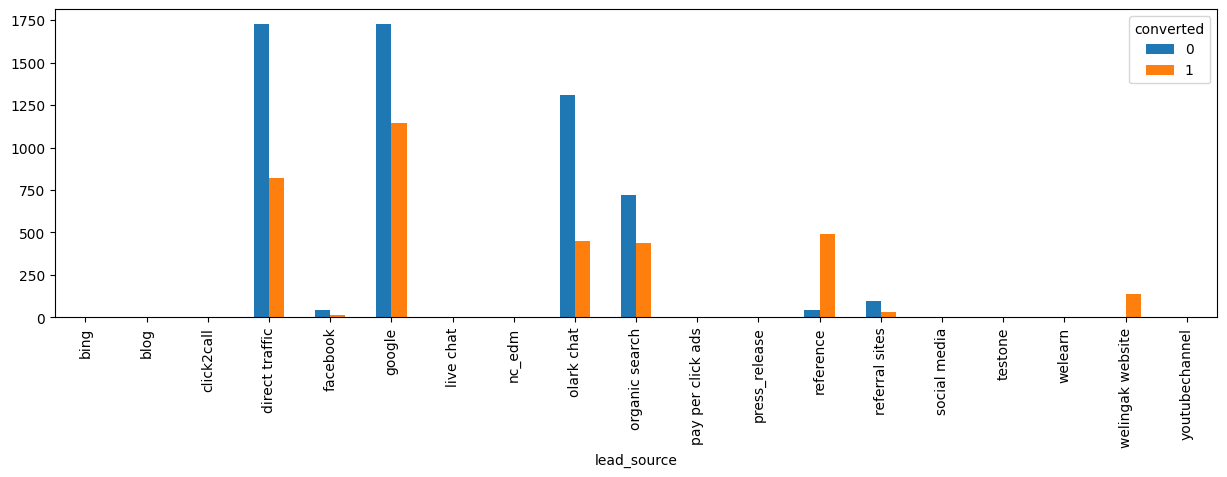

In [88]:
crs = pd.crosstab(index = categorical_data.lead_source, columns = categorical_data.converted)
crs.plot.bar(figsize = (15,4))


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 1.0327e-212
- The chi2 discrepancy is : 1055.3
	- We can reject the Null Hypothesis
	- The features lead_source and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


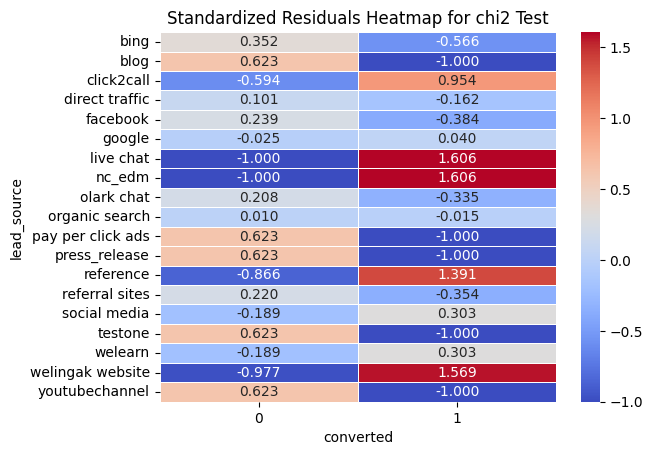

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.339
	- There is a moderately strong association between lead_source and converted
****************************************************************************************************************

In [89]:
# Analysing the relationship with target
cat_to_cat_association_tests(categorical_data, 'lead_source', 'converted')

In [90]:
# Point Biserial Correlation
point_biserial_categorical_correlation(categorical_data, 'lead_source', 'converted')

The p-value is 1.2011e-128.
The correlation is statistically significant !
The point biserial correlation between lead_source and the converted is :0.248.


0.24762799138467265

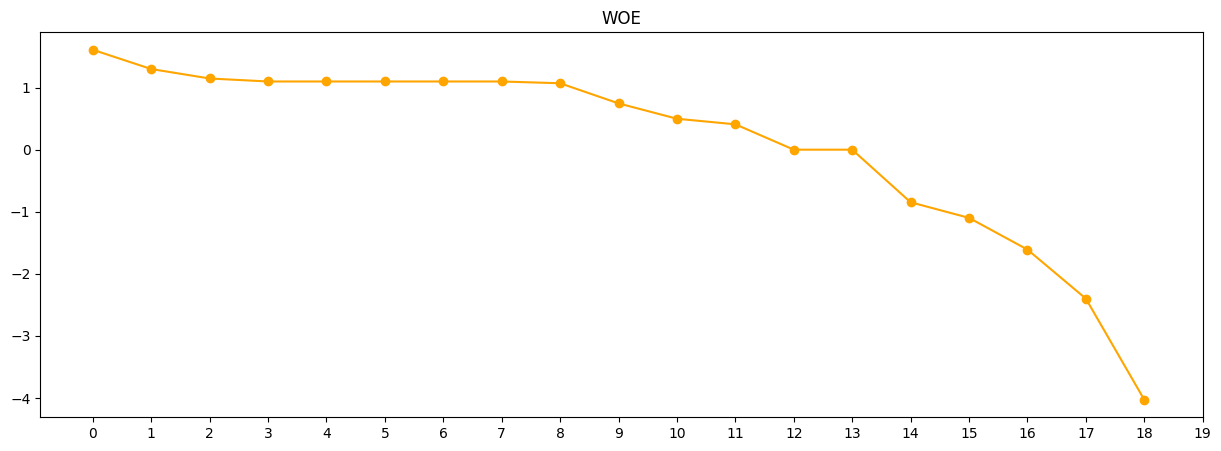

Value  Event  Non-Event       WOE        IV
0       press_release      0          2  1.609438  1.000000
1                bing      1          5  1.299283  0.666667
2            facebook     13         42  1.146814  0.527273
3   pay per click ads      0          1  1.098612  1.000000
4                blog      0          1  1.098612  1.000000
5             testone      0          1  1.098612  1.000000
6      referral sites     31         94  1.098612  0.504000
7      youtubechannel      0          1  1.098612  1.000000
8          olark chat    448       1307  1.069964  0.489459
9      direct traffic    818       1725  0.745799  0.356665
10     organic search    436        718  0.498377  0.244367
11             google   1147       1726  0.408511  0.201532
12                NaN      0          0  0.000000       NaN
13       social media      1          1  0.000000  0.000000
14            welearn      1          1  0.000000  0.000000
15         click2call      3          1 -0.847298 -0.500000
16             nc_edm      1          0 -1.098612 -1.000000
17          live chat      2          0 -1.609438 -1.000000
18          reference    490         44 -2.399936 -0.835206
19   welingak website    140          2 -4.028917 -0.971831

In [91]:
calculate_woe_iv(categorical_data, 'lead_source', 'converted')

##### Observations:
- Most of the data points fall in these 4 categories only : ['google','direct traffic','olark chat','organic search']
- The cardinality can be reduced by:
    - keeping the top frequency categories and marking everything else as others
    - using woe to identify and group similar categories and finally mapping them all to their respective woe values
- The relationship is statistically significant with the target
- Moderate correlation can be observed in the feature and the target

#### 3.4.3.0 Keeping all major categories and marking everything else as others

In [92]:
# Checking if reducing cardinality helps
dummy = categorical_data[unique_ids.__add__(target_variable).__add__(['lead_source'])]
dummy.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

      lead_source  
0      olark chat  
1  organic search  
2  direct traffic

In [93]:
dummy['lead_source_2'] = np.where(dummy.lead_source.isin(['google','direct traffic','olark chat','organic search', np.nan]), dummy.lead_source, 'others')
dummy.isna().sum()

prospect_id       0
lead_number       0
converted         0
lead_source      36
lead_source_2    36
dtype: int64

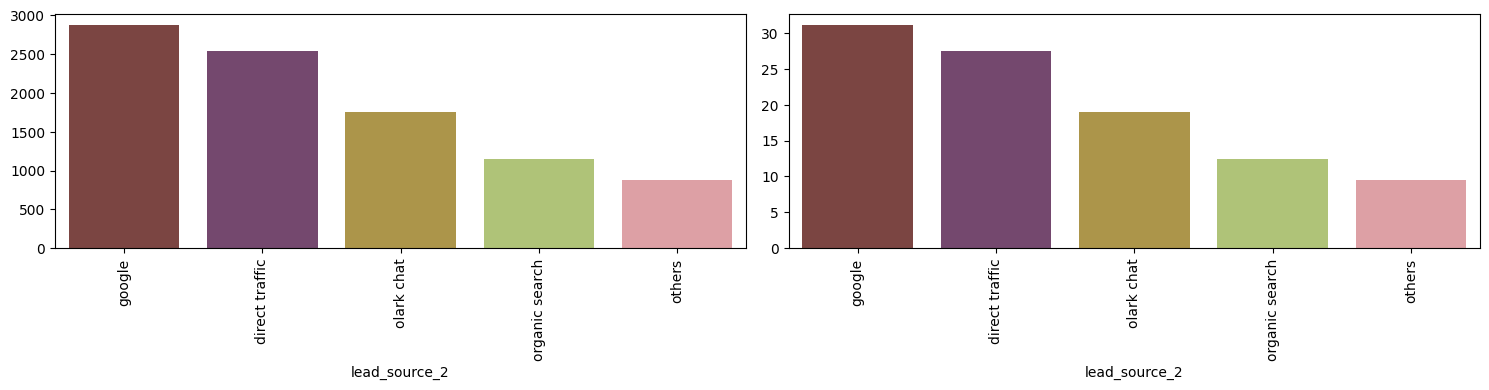

In [94]:
univariate_class_distribution_bar(dummy, 'lead_source_2')


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 2.9497e-159
- The chi2 discrepancy is : 741.9
	- We can reject the Null Hypothesis
	- The features lead_source_2 and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


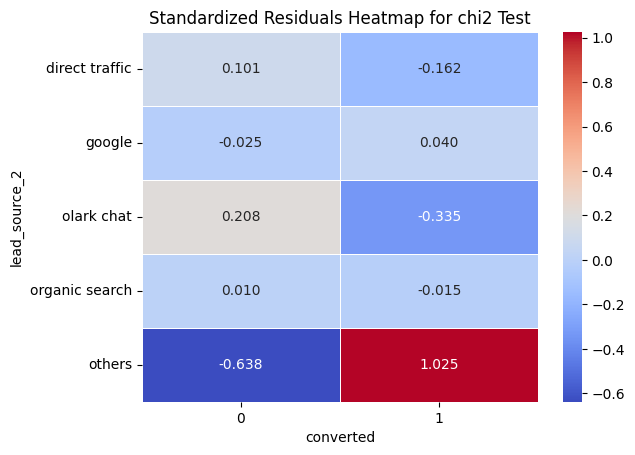

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.284
	- There is a moderate association between lead_source_2 and converted
******************************************************************************************************************

4. 

In [95]:
cat_to_cat_association_tests(dummy, 'lead_source_2', 'converted')

In [96]:
# Point Biserial Correlation
point_biserial_categorical_correlation(dummy, 'lead_source_2', 'converted')

The p-value is 4.9127e-94.
The correlation is statistically significant !
The point biserial correlation between lead_source_2 and the converted is :0.212.


0.21201576018389806

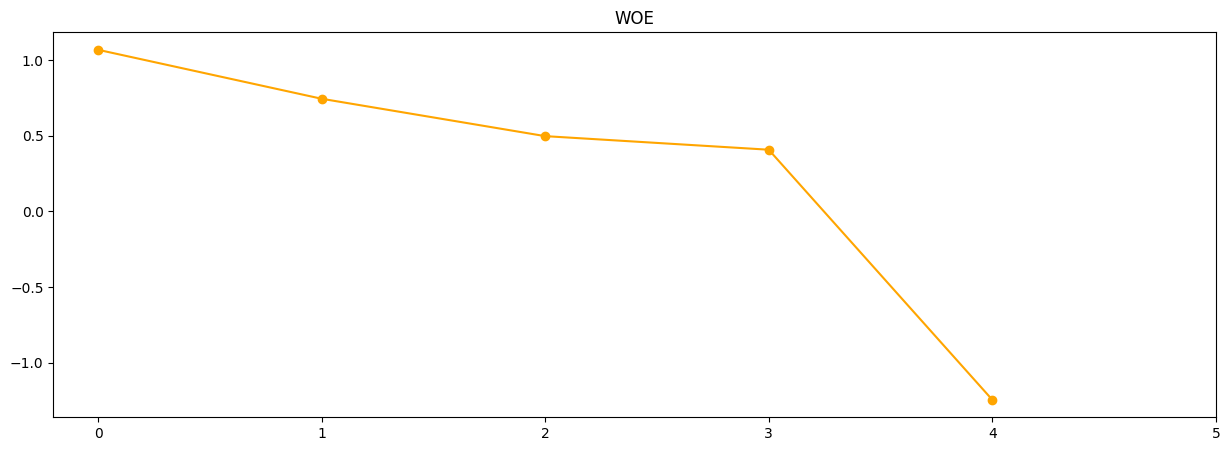

Value  Event  Non-Event       WOE        IV
0      olark chat    448       1307  1.069964  0.489459
1  direct traffic    818       1725  0.745799  0.356665
2  organic search    436        718  0.498377  0.244367
3          google   1147       1726  0.408511  0.201532
4             NaN      0          0  0.000000       NaN
5          others    683        196 -1.246564 -0.554039

In [97]:
calculate_woe_iv(dummy, 'lead_source_2', 'converted')

In [98]:
dummy['lead_source_3'] = np.where(dummy.lead_source_2.isin(['organic search', 'google']), 'organic or google search', dummy.lead_source_2)
dummy.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

      lead_source   lead_source_2             lead_source_3  
0      olark chat      olark chat                olark chat  
1  organic search  organic search  organic or google search  
2  direct traffic  direct traffic            direct traffic

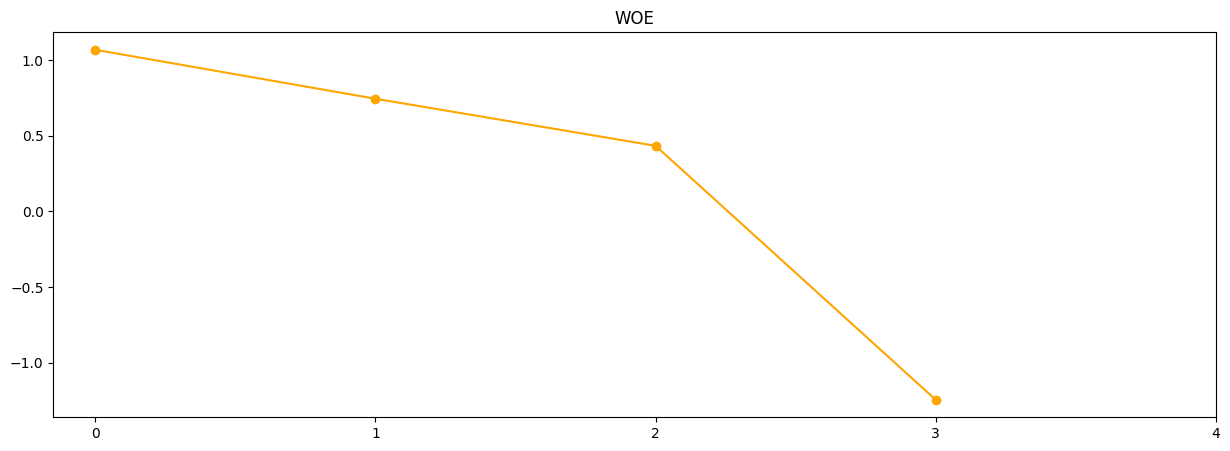

Value  Event  Non-Event       WOE        IV
0                olark chat    448       1307  1.069964  0.489459
1            direct traffic    818       1725  0.745799  0.356665
2  organic or google search   1583       2444  0.434203  0.213807
3                       NaN      0          0  0.000000       NaN
4                    others    683        196 -1.246564 -0.554039

In [99]:
calculate_woe_iv(dummy, 'lead_source_3', 'converted')


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 3.831e-160
- The chi2 discrepancy is : 740.3
	- We can reject the Null Hypothesis
	- The features lead_source_3 and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


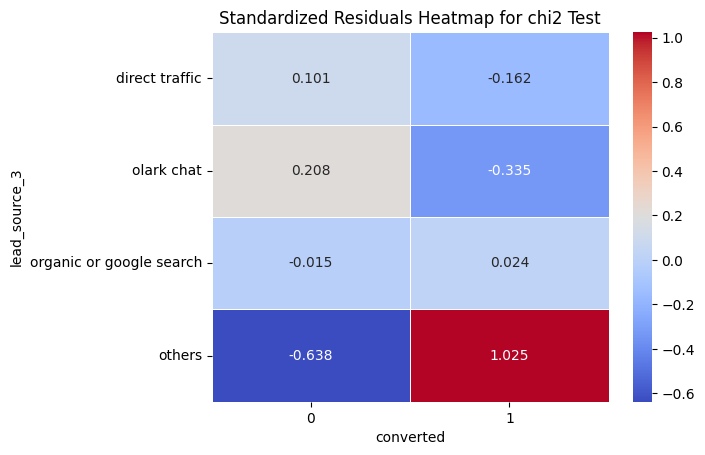

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.284
	- There is a moderate association between lead_source_3 and converted
******************************************************************************************************************

4. 

In [100]:
cat_to_cat_association_tests(dummy, 'lead_source_3', 'converted')

In [101]:
# Point Biserial Correlation
point_biserial_categorical_correlation(dummy, 'lead_source_3', 'converted')

The p-value is 6.7897e-78.
The correlation is statistically significant !
The point biserial correlation between lead_source_3 and the converted is :0.193.


0.19293673378511447

#### 3.4.3.1 Reducing cardinality using woe

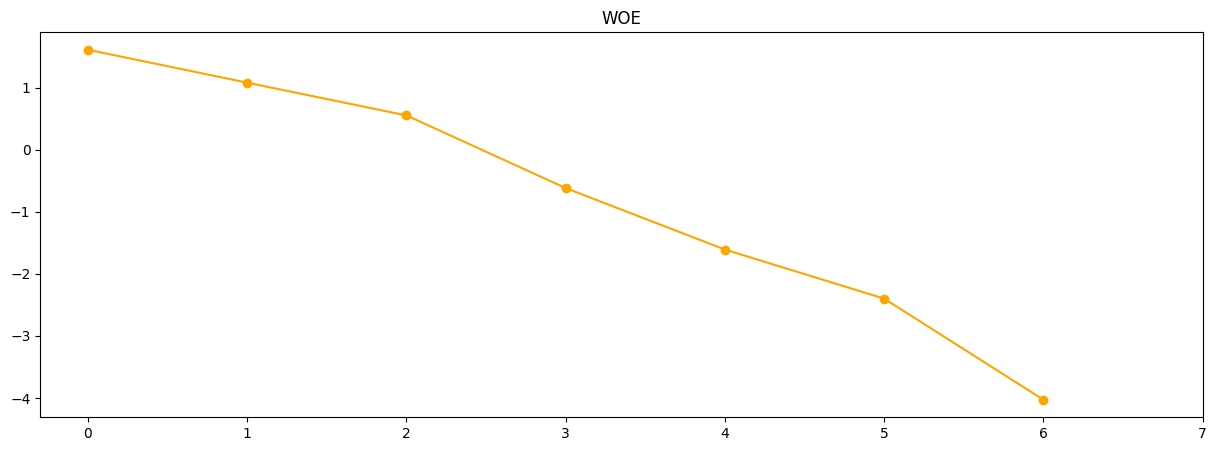

Value  Event  Non-Event       WOE        IV
0     press_release      0          2  1.609438  1.000000
1        category_1    493       1452  1.079519  0.493059
2        category_3   2401       4169  0.551703  0.269102
3               NaN      0          0  0.000000       NaN
4        category_4      6          3 -0.619039 -0.333333
5         live chat      2          0 -1.609438 -1.000000
6         reference    490         44 -2.399936 -0.835206
7  welingak website    140          2 -4.028917 -0.971831

In [102]:
# Checking if reducing cardinality helps
dummy = categorical_data[unique_ids.__add__(target_variable).__add__(['lead_source'])]

lead_source_mapper = {('bing', 'facebook','pay per click ads', 'blog', 'testone', 'referral sites', 'youtubechannel', 'olark chat'):'category_1', 
                      ('social media','welearn'):'category_2', 
                      ('organic search','google', 'direct traffic'):'category_3', 
                      ('click2call','nc_edm', 'category_2'):'category_4'}
dummy['lead_source_1'] = dummy['lead_source'].copy()

for collection_ in lead_source_mapper:
    dummy['lead_source_1'] = np.where(dummy.lead_source_1.isin(collection_), lead_source_mapper.get(collection_), dummy.lead_source_1)
calculate_woe_iv(dummy, 'lead_source_1', 'converted')


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 1.3411e-216
- The chi2 discrepancy is : 1017.7
	- We can reject the Null Hypothesis
	- The features lead_source_1 and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


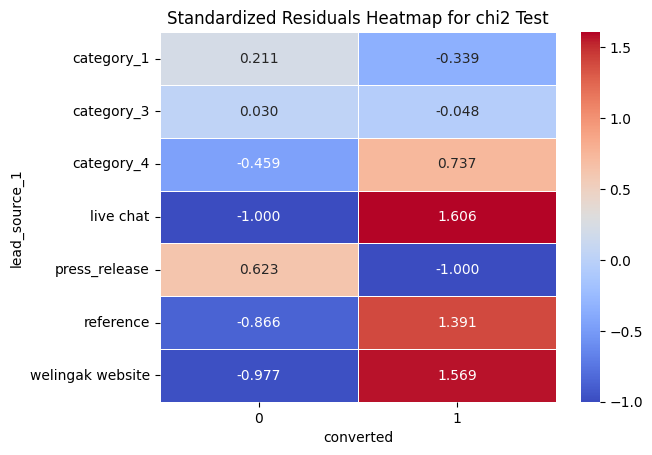

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.333
	- There is a moderately strong association between lead_source_1 and converted
**************************************************************************************************************

In [103]:
cat_to_cat_association_tests(dummy, 'lead_source_1', 'converted')

In [104]:
# Point Biserial Correlation
point_biserial_categorical_correlation(dummy, 'lead_source_1', 'converted')

The p-value is 3.6299e-189.
The correlation is statistically significant !
The point biserial correlation between lead_source_1 and the converted is :0.299.


0.2988082868467472

##### Observations:
- It can be observed that using WOE to reduce cardinality yields better results
- The categories can now be replaced by their respective woe values

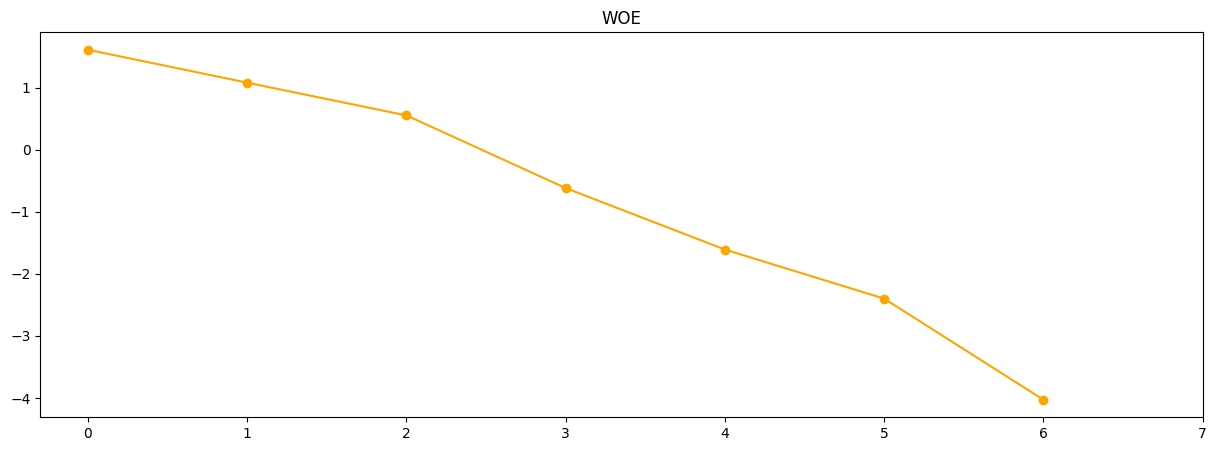

Value  Event  Non-Event       WOE        IV
0     press_release      0          2  1.609438  1.000000
1        category_1    493       1452  1.079519  0.493059
2        category_3   2401       4169  0.551703  0.269102
3               NaN      0          0  0.000000       NaN
4        category_4      6          3 -0.619039 -0.333333
5         live chat      2          0 -1.609438 -1.000000
6         reference    490         44 -2.399936 -0.835206
7  welingak website    140          2 -4.028917 -0.971831

In [105]:
# Replacing the categories by woe values
woe_iv_values = calculate_woe_iv(dummy, 'lead_source_1', 'converted')
woe_iv_values

In [106]:
# Mapping the woe and iv values to the categories
dummy = pd.merge(left = dummy, right = woe_iv_values[['Value', 'WOE', 'IV']], left_on = ['lead_source_1'], right_on = 'Value', how = 'left')
dummy.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

      lead_source lead_source_1       Value       WOE        IV  
0      olark chat    category_1  category_1  1.079519  0.493059  
1  organic search    category_3  category_3  0.551703  0.269102  
2  direct traffic    category_3  category_3  0.551703  0.269102

In [107]:
point_biserial_correlation_coefficient(dummy, 'WOE', 'converted')

The p-value is : 7.32e-232
The correlation is statistically significant !
The point biserial correlation between WOE and the converted is :-0.329.


-0.32881794012414356

In [108]:
point_biserial_correlation_coefficient(dummy, 'IV', 'converted')

The p-value is : 1.83e-236
The correlation is statistically significant !
The point biserial correlation between IV and the converted is :-0.333.


-0.33251962190901607

In [109]:
point_biserial_categorical_correlation(dummy, 'lead_source_1', 'converted')

The p-value is 3.6299e-189.
The correlation is statistically significant !
The point biserial correlation between lead_source_1 and the converted is :0.299.


0.2988082868467472

In [110]:
dummy

prospect_id  lead_number  converted  \
0     7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1     2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2     8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   
3     0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719          0   
4     3256f628-e534-4826-9d63-4a8b88782852       660681          1   
...                                    ...          ...        ...   
9235  19d6451e-fcd6-407c-b83b-48e1af805ea9       579564          1   
9236  82a7005b-7196-4d56-95ce-a79f937a158d       579546          0   
9237  aac550fe-a586-452d-8d3c-f1b62c94e02c       579545          0   
9238  5330a7d1-2f2b-4df4-85d6-64ca2f6b95b9       579538          1   
9239  571b5c8e-a5b2-4d57-8574-f2ffb06fdeff       579533          1   

         lead_source lead_source_1       Value       WOE        IV  
0         olark chat    category_1  category_1  1.079519  0.493059  
1     organic search    category_3  category_3  0.551703  0.269102  
2     direct traffic    category_3  category_3  0.551703  0.269102  
3     direct traffic    category_3  category_3  0.551703  0.269102  
4             google    category_3  category_3  0.551703  0.269102  
...              ...           ...         ...       ...       ...  
9235  direct traffic    category_3  category_3  0.551703  0.269102  
9236  direct traffic    category_3  category_3  0.551703  0.269102  
9237  direct traffic    category_3  category_3  0.551703  0.269102  
9238          google    category_3  category_3  0.551703  0.269102  
9239  direct traffic    category_3  category_3  0.551703  0.269102  

[9240 rows x 8 columns]

In [111]:
# Mapping the lead source iv values in the original categorical features
dummy = dummy[unique_ids.__add__(target_variable).__add__(['IV'])]
dummy = dummy.rename({'IV':'lead_source_IV'}, axis = 'columns')


categorical_data = pd.merge(left = categorical_data.drop(columns = ['lead_source']), right = dummy, on = unique_ids.__add__(target_variable), how = 'outer')
categorical_data

prospect_id  lead_number  converted  \
0     7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1     2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2     8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   
3     0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719          0   
4     3256f628-e534-4826-9d63-4a8b88782852       660681          1   
...                                    ...          ...        ...   
9235  19d6451e-fcd6-407c-b83b-48e1af805ea9       579564          1   
9236  82a7005b-7196-4d56-95ce-a79f937a158d       579546          0   
9237  aac550fe-a586-452d-8d3c-f1b62c94e02c       579545          0   
9238  5330a7d1-2f2b-4df4-85d6-64ca2f6b95b9       579538          1   
9239  571b5c8e-a5b2-4d57-8574-f2ffb06fdeff       579533          1   

                  lead_origin            last_activity       country  \
0                         API  Page Visited on Website           NaN   
1                         API             Email Opened         India   
2     Landing Page Submission             Email Opened         India   
3     Landing Page Submission              Unreachable         India   
4     Landing Page Submission        Converted to Lead         India   
...                       ...                      ...           ...   
9235  Landing Page Submission        Email Marked Spam  Saudi Arabia   
9236  Landing Page Submission                 SMS Sent         India   
9237  Landing Page Submission                 SMS Sent         India   
9238  Landing Page Submission                 SMS Sent         India   
9239  Landing Page Submission                 SMS Sent    Bangladesh   

                 specialization how_did_you_hear_about_x_education  \
0                        Select                             Select   
1                        Select                             Select   
2       Business Administration                             Select   
3         Media and Advertising                      Word Of Mouth   
4                        Select                              Other   
...                         ...                                ...   
9235     IT Projects Management                             Select   
9236      Media and Advertising                             Select   
9237    Business Administration                             Select   
9238  Human Resource Management                      Online Search   
9239    Supply Chain Management                             Select   

     what_is_your_current_occupation last_notable_activity  \
0                         Unemployed              Modified   
1                         Unemployed          Email Opened   
2                            Student          Email Opened   
3                         Unemployed              Modified   
4                         Unemployed              Modified   
...                              ...                   ...   
9235                      Unemployed     Email Marked Spam   
9236                      Unemployed              SMS Sent   
9237                      Unemployed              SMS Sent   
9238                             NaN              SMS Sent   
9239                      Unemployed              Modified   

     what_matters_most_to_you_in_choosing_a_course  \
0                          Better Career Prospects   
1                          Better Career Prospects   
2                          Better Career Prospects   
3                          Better Career Prospects   
4                          Better Career Prospects   
...                                            ...   
9235                       Better Career Prospects   
9236                       Better Career Prospects   
9237                       Better Career Prospects   
9238                                           NaN   
9239                       Better Career Prospects   

                                     tags       lead_quality    lead_profile  \
0         


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 1.3411e-216
- The chi2 discrepancy is : 1017.7
	- We can reject the Null Hypothesis
	- The features lead_source_IV and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


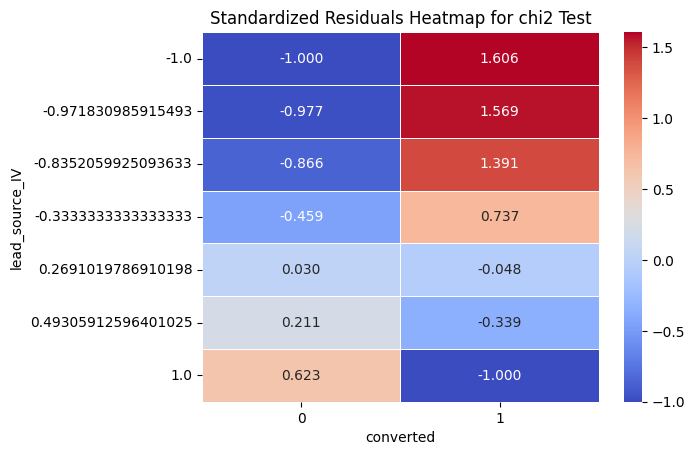

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.333
	- There is a moderately strong association between lead_source_IV and converted
*************************************************************************************************************

In [112]:
cat_to_cat_association_tests(categorical_data, 'lead_source_IV', 'converted')

In [113]:
point_biserial_correlation_coefficient(categorical_data, 'lead_source_IV', 'converted')

The p-value is : 1.83e-236
The correlation is statistically significant !
The point biserial correlation between lead_source_IV and the converted is :-0.333.


-0.33251962190901607

##### Conclusions:
- The feature `lead_source` is moderately associated to the target
- The feature can better be transformed using iv values of the most suitable categories

### 3.4.4 last_activity

In [114]:
categorical_data.last_activity.isna().sum()

103

In [115]:
categorical_data.last_activity.value_counts()

last_activity
Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Received                     2
Email Marked Spam                  2
Visited Booth in Tradeshow         1
Resubscribed to emails             1
Name: count, dtype: int64

In [116]:
round(100*(categorical_data.last_activity.value_counts()/categorical_data.shape[0]),2)

last_activity
Email Opened                    37.20
SMS Sent                        29.71
Olark Chat Conversation         10.53
Page Visited on Website          6.93
Converted to Lead                4.63
Email Bounced                    3.53
Email Link Clicked               2.89
Form Submitted on Website        1.26
Unreachable                      1.01
Unsubscribed                     0.66
Had a Phone Conversation         0.32
Approached upfront               0.10
View in browser link Clicked     0.06
Email Received                   0.02
Email Marked Spam                0.02
Visited Booth in Tradeshow       0.01
Resubscribed to emails           0.01
Name: count, dtype: float64

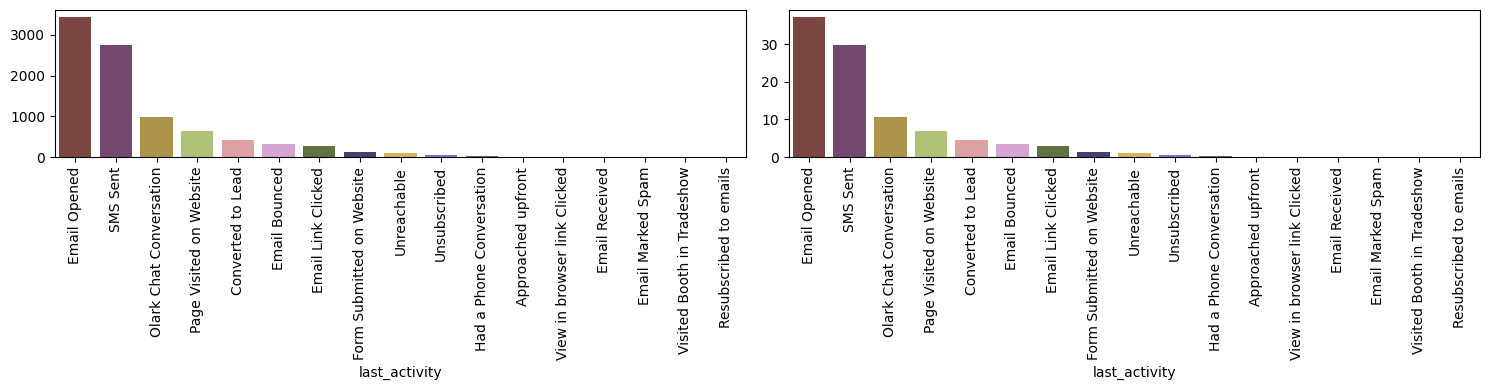

In [117]:
# Distribution plots
univariate_class_distribution_bar(categorical_data,'last_activity')

<Axes: xlabel='last_activity'>

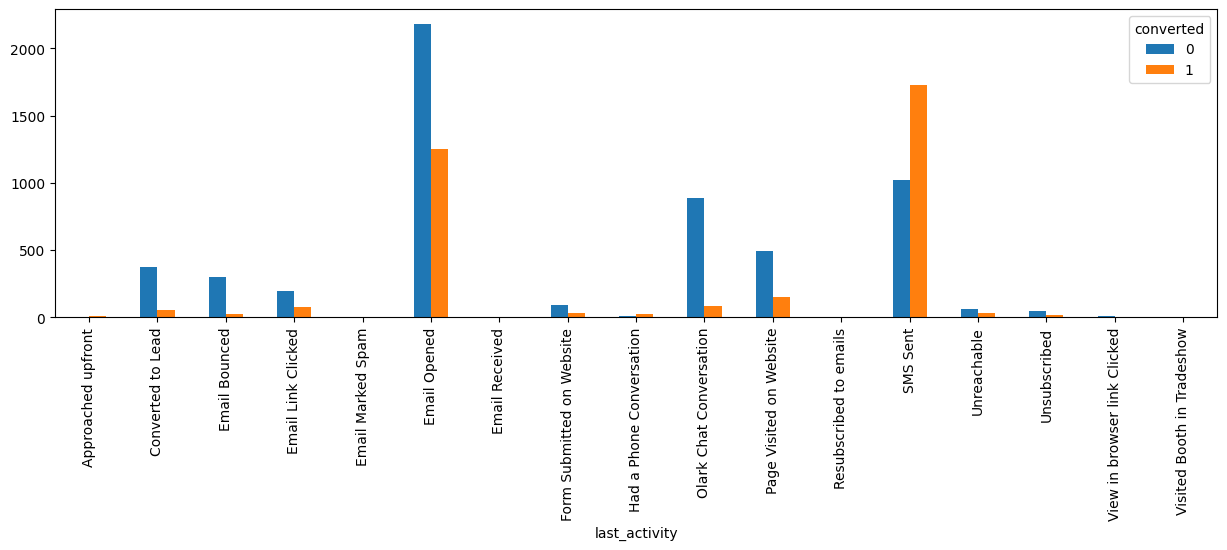

In [118]:
# Distribution plots as per the categories
crs = pd.crosstab(index = categorical_data.last_activity, columns = categorical_data.converted)
crs.plot.bar(figsize = (15,4))


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 1.2694e-298
- The chi2 discrepancy is : 1447.0
	- We can reject the Null Hypothesis
	- The features last_activity and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


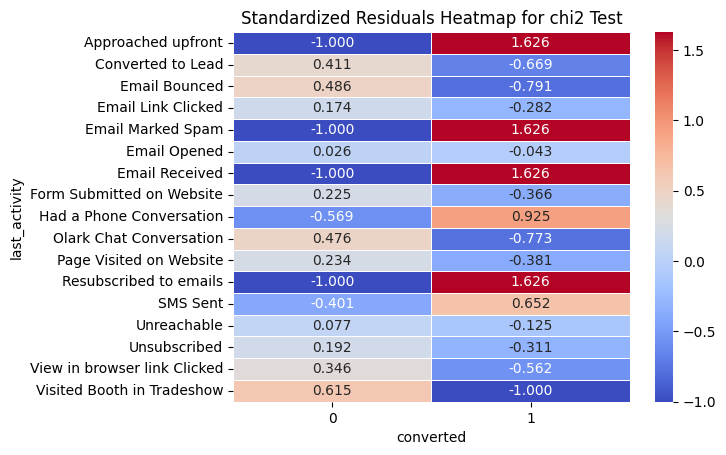

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.398
	- There is a moderately strong association between last_activity and converted
**************************************************************************************************************

In [119]:
# Detailed analysis of last_activity with the target
cat_to_cat_association_tests(categorical_data, 'last_activity', 'converted')

In [120]:
# Point biserial correlation coefficient
point_biserial_categorical_correlation(data, 'last_activity', 'converted')

The p-value is 7.4762e-165.
The correlation is statistically significant !
The point biserial correlation between last_activity and the converted is :0.281.


0.2805362289105042

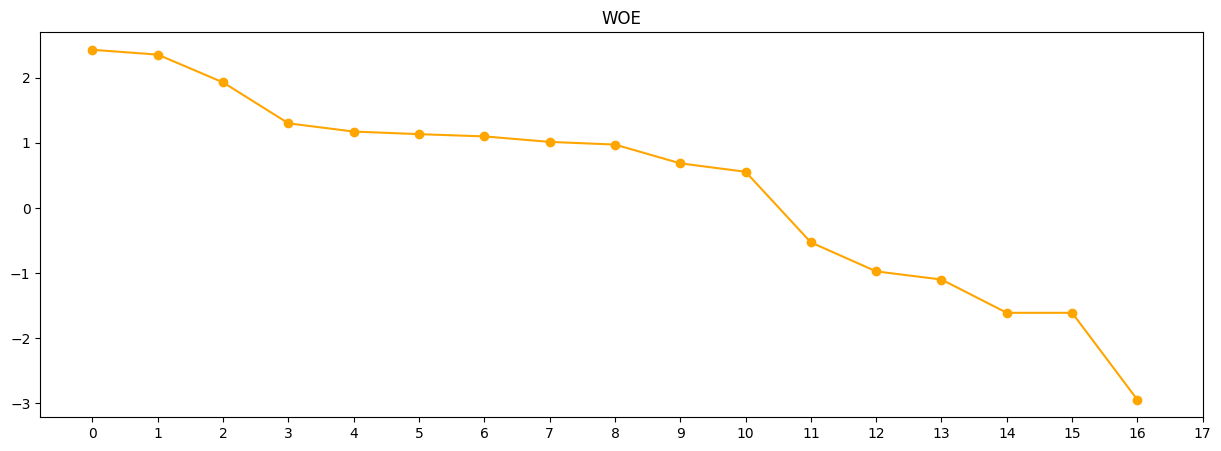

Value  Event  Non-Event       WOE        IV
0                  Email Bounced     26        300  2.428303  0.840491
1        Olark Chat Conversation     84        889  2.353908  0.827338
2              Converted to Lead     54        374  1.927391  0.747664
3   View in browser link Clicked      1          5  1.299283  0.666667
4        Page Visited on Website    151        489  1.172799  0.528125
5      Form Submitted on Website     28         88  1.133098  0.517241
6     Visited Booth in Tradeshow      0          1  1.098612  1.000000
7                   Unsubscribed     16         45  1.014352  0.475410
8             Email Link Clicked     73        194  0.973147  0.453184
9                    Unreachable     31         62  0.685179  0.333333
10                  Email Opened   1253       2184  0.555447  0.270876
11                           NaN      0          0  0.000000       NaN
12                      SMS Sent   1727       1018 -0.528344 -0.258288
13      Had a Phone Conversation     22          8 -0.973449 -0.466667
14        Resubscribed to emails      1          0 -1.098612 -1.000000
15                Email Received      2          0 -1.609438 -1.000000
16             Email Marked Spam      2          0 -1.609438 -1.000000
17            Approached upfront      9          0 -2.944439 -1.000000

In [121]:
calculate_woe_iv(data, 'last_activity', 'converted')

##### Observations:
- `last_activity` and `Email Opened` comprises of the biggest contributors
- High Cardinality
- Abnormal distribution can be observed in the chi2 discrepancy
- The association measured is moderately strong

##### Following steps can be taken to reduce the cardinality:
- Keep the highest frequency categories and mark everything else as others
- Reduce the cardinality using woe

#### 3.4.0 Marking all other categories under `Others` Section

In [122]:
# Finding the most recurring categories
most_recurring_categories = ('Email Opened','SMS Sent')

dummy = categorical_data[unique_ids.__add__(target_variable).__add__(['last_activity'])]
dummy.head()

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719          0   
4  3256f628-e534-4826-9d63-4a8b88782852       660681          1   

             last_activity  
0  Page Visited on Website  
1             Email Opened  
2             Email Opened  
3              Unreachable  
4        Converted to Lead

In [123]:
# Generating the new feature
dummy['last_activity_1'] = np.where(dummy.last_activity.isin(most_recurring_categories.__add__((np.nan,))), dummy.last_activity, 'Other')
dummy.isna().sum()

prospect_id          0
lead_number          0
converted            0
last_activity      103
last_activity_1    103
dtype: int64

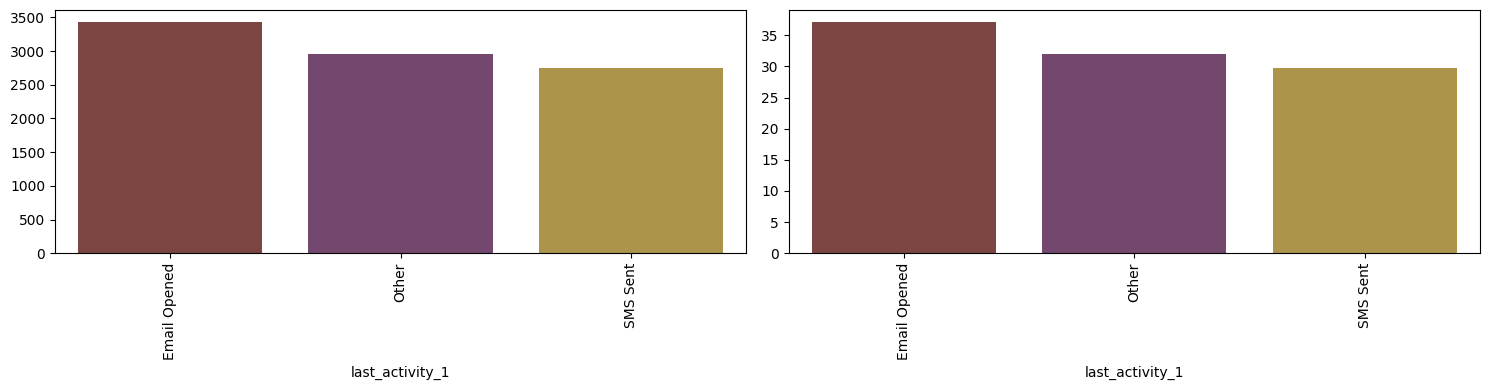

In [124]:
# Distribution plots
univariate_class_distribution_bar(dummy,'last_activity_1')

<Axes: xlabel='last_activity_1'>

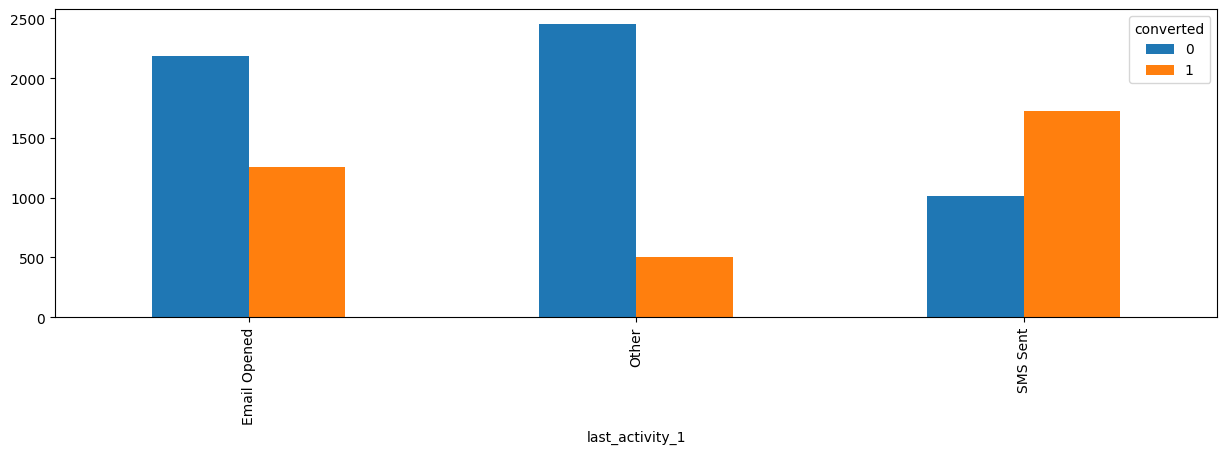

In [125]:
# Distribution plots as per the categories
crs = pd.crosstab(index = dummy.last_activity_1, columns = dummy.converted)
crs.plot.bar(figsize = (15,4))


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 2.7077e-279
- The chi2 discrepancy is : 1282.9
	- We can reject the Null Hypothesis
	- The features last_activity_1 and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


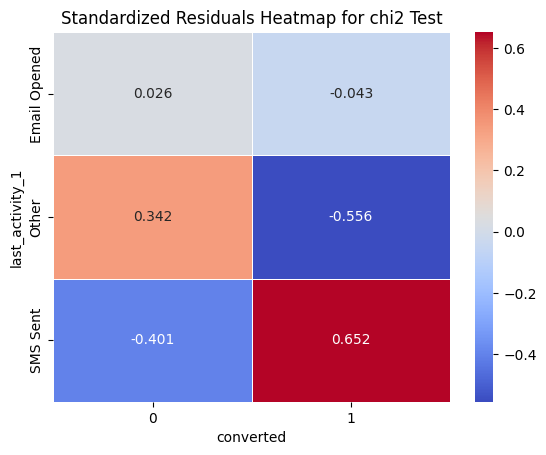

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.375
	- There is a moderately strong association between last_activity_1 and converted
************************************************************************************************************

In [126]:
# Testing the new feature been generated
cat_to_cat_association_tests(dummy, 'last_activity_1', 'converted')

In [127]:
# Point-Biserial correlation coefficient
point_biserial_categorical_correlation(dummy, 'last_activity_1', 'converted')

The p-value is 9.8222e-300.
The correlation is statistically significant !
The point biserial correlation between last_activity_1 and the converted is :0.373.


0.37310871345268176

#### 3.4.1 Missing value imputation using a separate 'Missing' label

In [128]:
# Finding the most recurring categories
most_recurring_categories = ('Email Opened','SMS Sent')

dummy = categorical_data[unique_ids.__add__(target_variable).__add__(['last_activity'])]
dummy.head()

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719          0   
4  3256f628-e534-4826-9d63-4a8b88782852       660681          1   

             last_activity  
0  Page Visited on Website  
1             Email Opened  
2             Email Opened  
3              Unreachable  
4        Converted to Lead

In [129]:
# Generating the new feature
dummy['last_activity_1'] = np.where(dummy.last_activity.isin(most_recurring_categories.__add__((np.nan,))), dummy.last_activity, 'Other')
dummy.isna().sum()

prospect_id          0
lead_number          0
converted            0
last_activity      103
last_activity_1    103
dtype: int64

In [130]:
# Filling the missing values
dummy['last_activity_1'] = dummy['last_activity_1'].fillna('Unknown')
dummy.isna().sum()

prospect_id          0
lead_number          0
converted            0
last_activity      103
last_activity_1      0
dtype: int64

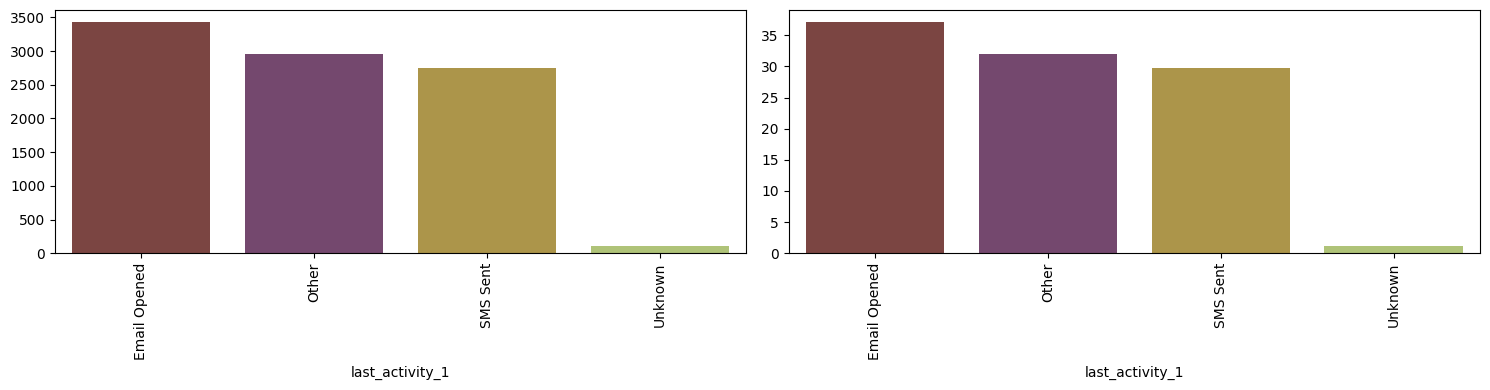

In [131]:
# Distribution plots
univariate_class_distribution_bar(dummy,'last_activity_1')

<Axes: xlabel='last_activity_1'>

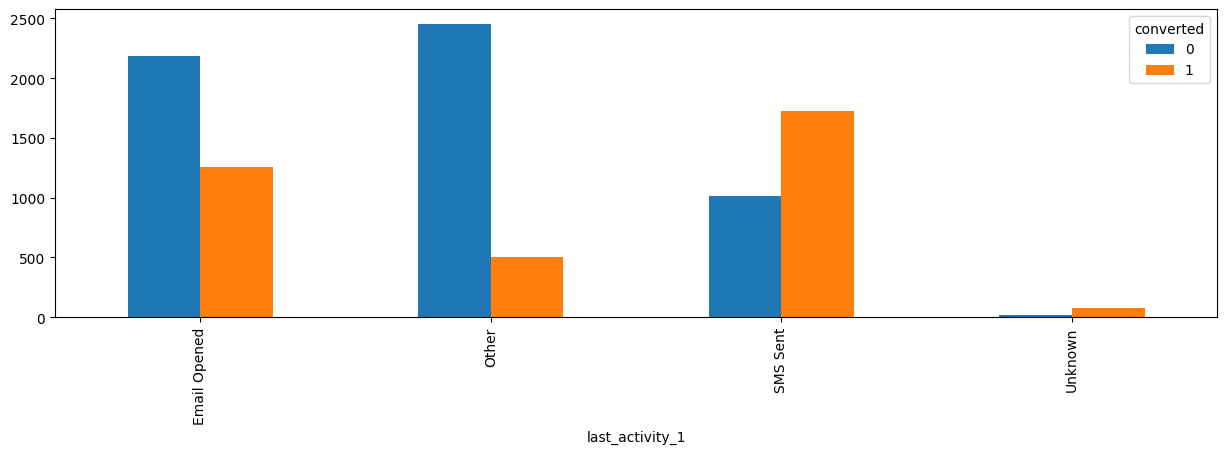

In [132]:
# Distribution plots as per the categories
crs = pd.crosstab(index = dummy.last_activity_1, columns = dummy.converted)
crs.plot.bar(figsize = (15,4))


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 6.1096e-292
- The chi2 discrepancy is : 1347.8
	- We can reject the Null Hypothesis
	- The features last_activity_1 and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


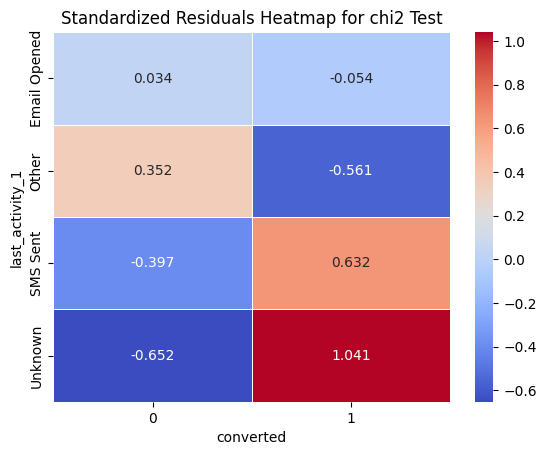

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.382
	- There is a moderately strong association between last_activity_1 and converted
************************************************************************************************************

In [133]:
# Testing the new feature been generated
cat_to_cat_association_tests(dummy, 'last_activity_1', 'converted')

In [134]:
# Point-Biserial correlation coefficient
point_biserial_categorical_correlation(dummy, 'last_activity_1', 'converted')

The p-value is 3.4962e-305.
The correlation is statistically significant !
The point biserial correlation between last_activity_1 and the converted is :0.374.


0.37430913786143927

#### 3.4.2 Cardinality reduction using WOE

In [135]:
# Finding the most recurring categories
dummy = categorical_data[unique_ids.__add__(target_variable).__add__(['last_activity'])]
dummy.head()

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719          0   
4  3256f628-e534-4826-9d63-4a8b88782852       660681          1   

             last_activity  
0  Page Visited on Website  
1             Email Opened  
2             Email Opened  
3              Unreachable  
4        Converted to Lead

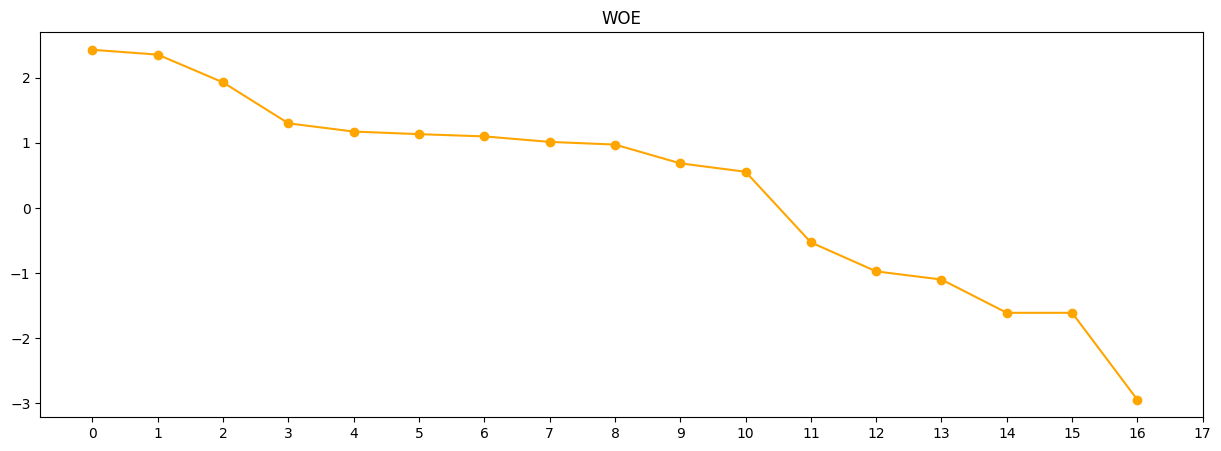

Value  Event  Non-Event       WOE        IV
0                  Email Bounced     26        300  2.428303  0.840491
1        Olark Chat Conversation     84        889  2.353908  0.827338
2              Converted to Lead     54        374  1.927391  0.747664
3   View in browser link Clicked      1          5  1.299283  0.666667
4        Page Visited on Website    151        489  1.172799  0.528125
5      Form Submitted on Website     28         88  1.133098  0.517241
6     Visited Booth in Tradeshow      0          1  1.098612  1.000000
7                   Unsubscribed     16         45  1.014352  0.475410
8             Email Link Clicked     73        194  0.973147  0.453184
9                    Unreachable     31         62  0.685179  0.333333
10                  Email Opened   1253       2184  0.555447  0.270876
11                           NaN      0          0  0.000000       NaN
12                      SMS Sent   1727       1018 -0.528344 -0.258288
13      Had a Phone Conversation     22          8 -0.973449 -0.466667
14        Resubscribed to emails      1          0 -1.098612 -1.000000
15                Email Received      2          0 -1.609438 -1.000000
16             Email Marked Spam      2          0 -1.609438 -1.000000
17            Approached upfront      9          0 -2.944439 -1.000000

In [136]:
# woe-iv
calculate_woe_iv(dummy, 'last_activity', 'converted')

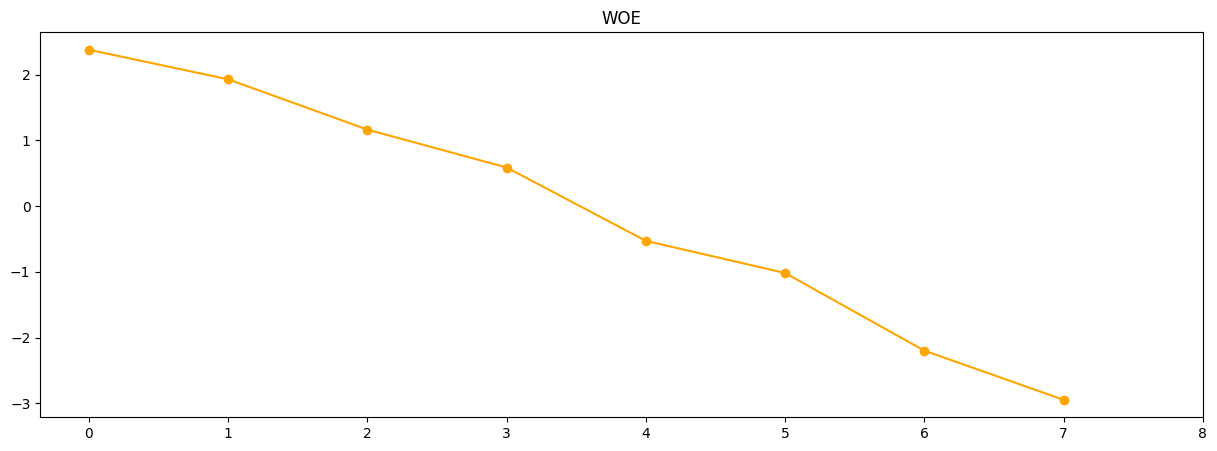

Value  Event  Non-Event       WOE        IV
0          category_1    110       1189  2.376273  0.830639
1   Converted to Lead     54        374  1.927391  0.747664
2          category_2    196        628  1.162674  0.524272
3          category_3   1357       2440  0.586558  0.285225
4                 NaN      0          0  0.000000       NaN
5            SMS Sent   1727       1018 -0.528344 -0.258288
6          category_4     23          8 -1.016934 -0.483871
7          category_5      4          0 -2.197225 -1.000000
8  Approached upfront      9          0 -2.944439 -1.000000

In [137]:
# clubbing categories as per woe
last_activity_mapper = {('Email Bounced', 'Olark Chat Conversation'):'category_1', 
                        ('View in browser link Clicked', 'Page Visited on Website', 'Form Submitted on Website', 
                         'Visited Booth in Tradeshow', 'Unsubscribed'):'category_2', 
                        ('Email Link Clicked', 'Unreachable', 'Email Opened'):'category_3', 
                        ('Resubscribed to emails', 'Had a Phone Conversation'):'category_4',
                        ('Email Received', 'Email Marked Spam'):'category_5'}

# Clubbing the categories
dummy['last_activity_1'] = dummy['last_activity'].copy()
for collection_ in last_activity_mapper:
    dummy['last_activity_1'] = np.where(dummy.last_activity_1.isin(collection_), last_activity_mapper.get(collection_), dummy.last_activity_1)

# woe-iv
last_activity_woe_iv = calculate_woe_iv(dummy, 'last_activity_1', 'converted')
last_activity_woe_iv

In [138]:
# Mapping WOE and IV to the last_activity data
dummy = pd.merge(left = dummy, right = last_activity_woe_iv[['Value', 'WOE', 'IV']], left_on = ['last_activity_1'], right_on = ['Value'])
dummy.isna().sum()

prospect_id          0
lead_number          0
converted            0
last_activity      103
last_activity_1    103
Value              103
WOE                  0
IV                 103
dtype: int64

In [139]:
# 1. WOE


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 0.0
- The chi2 discrepancy is : 1501.5
	- We can reject the Null Hypothesis
	- The features WOE and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


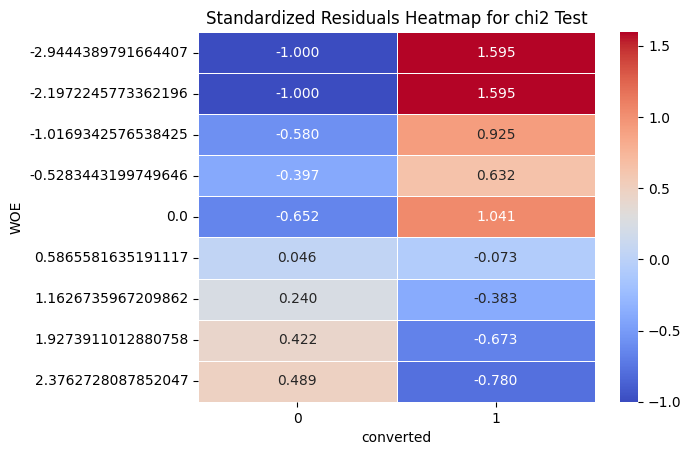

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.403
	- There is a moderately strong association between WOE and converted
******************************************************************************************************************

4. T

In [140]:
# Testing the new feature been generated
cat_to_cat_association_tests(dummy, 'WOE', 'converted')

In [141]:
# Point-Biserial correlation co-efficient
point_biserial_correlation_coefficient(dummy, 'WOE', 'converted')

The p-value is : 0.0
The correlation is statistically significant !
The point biserial correlation between WOE and the converted is :-0.393.


-0.39311357881269743

In [142]:
# 2. IV


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 2.1657e-307
- The chi2 discrepancy is : 1437.2
	- We can reject the Null Hypothesis
	- The features IV and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


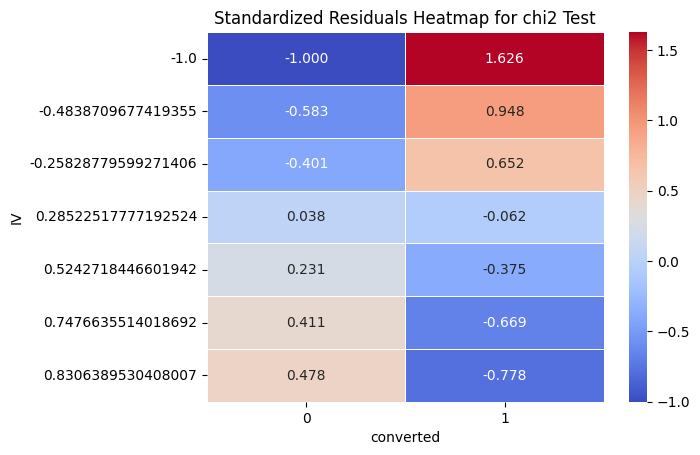

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.397
	- There is a moderately strong association between IV and converted
******************************************************************************************************************

4. Th

In [143]:
# Testing the new feature been generated
cat_to_cat_association_tests(dummy, 'IV', 'converted')

In [144]:
# Point-Biserial correlation co-efficient
point_biserial_correlation_coefficient(dummy, 'IV', 'converted')

The p-value is : 0.0
The correlation is statistically significant !
The point biserial correlation between IV and the converted is :-0.397.


-0.39659961467493676

##### Observations:
- The WOE works comparatively better than IV
- We will use the WOE for further representations of the `last_activity`

In [145]:
# Renaming the required feature
dummy = dummy.rename({'IV':'last_activity_IV'}, axis = 'columns')

# Removing the last_activity feature
categorical_data = categorical_data.drop(columns = ['last_activity'])
# mapping the last activity iv value
categorical_data = pd.merge(left = categorical_data, right = dummy[unique_ids.__add__(target_variable).__add__(['last_activity_IV'])], on = unique_ids.__add__(target_variable), how = 'outer')

categorical_data.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

               lead_origin country           specialization  \
0                      API     NaN                   Select   
1                      API   India                   Select   
2  Landing Page Submission   India  Business Administration   

  how_did_you_hear_about_x_education what_is_your_current_occupation  \
0                             Select                      Unemployed   
1                             Select                      Unemployed   
2                             Select                         Student   

  last_notable_activity what_matters_most_to_you_in_choosing_a_course  \
0              Modified                       Better Career Prospects   
1          Email Opened                       Better Career Prospects   
2          Email Opened                       Better Career Prospects   

                                  tags      lead_quality    lead_profile  \
0          Interested in other courses  Low in Relevance          Select   
1                              Ringing               NaN          Select   
2  Will revert after reading the email          Might be  Potential Lead   

     city  lead_source_IV  last_activity_IV  
0  Select        0.493059          0.524272  
1  Select        0.269102          0.285225  
2  Mumbai        0.269102          0.285225

### 3.4.5 specialization

In [146]:
categorical_data.specialization.isna().sum()

1438

In [147]:
round(100*(categorical_data.specialization.isna().sum()/categorical_data.shape[0]), 2)

15.56

In [148]:
categorical_data.specialization.unique()

array(['Select', 'Business Administration', 'Media and Advertising', nan,
       'Supply Chain Management', 'IT Projects Management',
       'Finance Management', 'Travel and Tourism',
       'Human Resource Management', 'Marketing Management',
       'Banking, Investment And Insurance', 'International Business',
       'E-COMMERCE', 'Operations Management', 'Retail Management',
       'Services Excellence', 'Hospitality Management',
       'Rural and Agribusiness', 'Healthcare Management', 'E-Business'],
      dtype=object)

In [149]:
# - `Select` is the same as missing value
# - Replacing the same with nans

categorical_data['specialization'] = categorical_data.specialization.replace({'Select':np.nan}).fillna('Unknown')
categorical_data.head()

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719          0   
4  3256f628-e534-4826-9d63-4a8b88782852       660681          1   

               lead_origin country           specialization  \
0                      API     NaN                  Unknown   
1                      API   India                  Unknown   
2  Landing Page Submission   India  Business Administration   
3  Landing Page Submission   India    Media and Advertising   
4  Landing Page Submission   India                  Unknown   

  how_did_you_hear_about_x_education what_is_your_current_occupation  \
0                             Select                      Unemployed   
1                             Select                      Unemployed   
2                             Select                         Student   
3                      Word Of Mouth                      Unemployed   
4                              Other                      Unemployed   

  last_notable_activity what_matters_most_to_you_in_choosing_a_course  \
0              Modified                       Better Career Prospects   
1          Email Opened                       Better Career Prospects   
2          Email Opened                       Better Career Prospects   
3              Modified                       Better Career Prospects   
4              Modified                       Better Career Prospects   

                                  tags      lead_quality    lead_profile  \
0          Interested in other courses  Low in Relevance          Select   
1                              Ringing               NaN          Select   
2  Will revert after reading the email          Might be  Potential Lead   
3                              Ringing          Not Sure          Select   
4  Will revert after reading the email          Might be          Select   

     city  lead_source_IV  last_activity_IV  
0  Select        0.493059          0.524272  
1  Select        0.269102          0.285225  
2  Mumbai        0.269102          0.285225  
3  Mumbai        0.269102          0.285225  
4  Mumbai        0.269102          0.747664

In [150]:
# missing data count
categorical_data.specialization.isna().sum()

0

In [151]:
# missing data proportion
round(100*(categorical_data.specialization.isna().sum()/categorical_data.shape[0]), 2)

0.0

In [152]:
categorical_data.specialization.value_counts()

specialization
Unknown                              3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: count, dtype: int64

In [153]:
round(100*(categorical_data.specialization.value_counts()/categorical_data.shape[0]), 2)

specialization
Unknown                              36.58
Finance Management                   10.56
Human Resource Management             9.18
Marketing Management                  9.07
Operations Management                 5.44
Business Administration               4.36
IT Projects Management                3.96
Supply Chain Management               3.78
Banking, Investment And Insurance     3.66
Travel and Tourism                    2.20
Media and Advertising                 2.20
International Business                1.93
Healthcare Management                 1.72
Hospitality Management                1.23
E-COMMERCE                            1.21
Retail Management                     1.08
Rural and Agribusiness                0.79
E-Business                            0.62
Services Excellence                   0.43
Name: count, dtype: float64

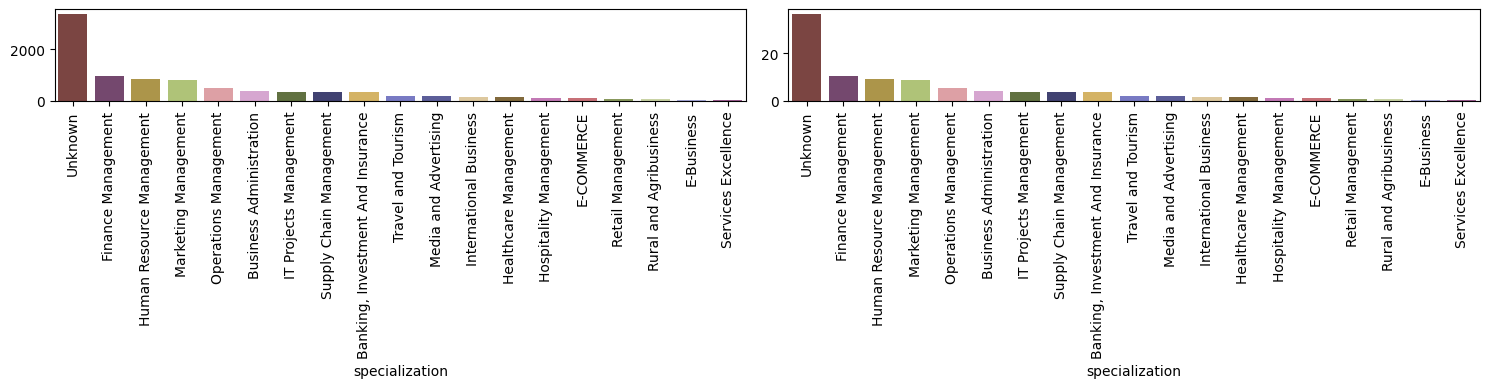

In [154]:
univariate_class_distribution_bar(categorical_data, 'specialization')

##### Observation:
- The cardinality is very high
- About 37% of the data is missing which would generate the largest category if used as a distinct flag
- We will need to reduce the cardinality either by brute force method or using WOE; here we will choose to reduce the same using WOE


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 2.7141e-46
- The chi2 discrepancy is : 267.06
	- We can reject the Null Hypothesis
	- The features specialization and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


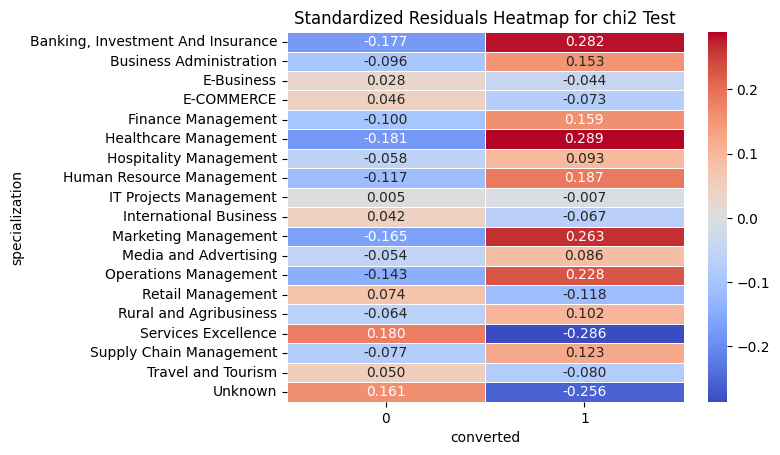

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.17
	- There is a moderate association between specialization and converted
******************************************************************************************************************

4. 

In [155]:
# Association analysis of the feature with the target
cat_to_cat_association_tests(categorical_data, 'specialization', 'converted')

In [156]:
# Point biserial correlation
point_biserial_categorical_correlation(categorical_data, 'specialization', 'converted')

The p-value is 4.7273e-30.
The correlation is statistically significant !
The point biserial correlation between specialization and the converted is :0.118.


0.11808568449106233

#### 3.4.5.1 using woe to reduce cardinality

In [157]:
dummy = categorical_data[unique_ids.__add__(target_variable).__add__(['specialization'])]
dummy.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

            specialization  
0                  Unknown  
1                  Unknown  
2  Business Administration

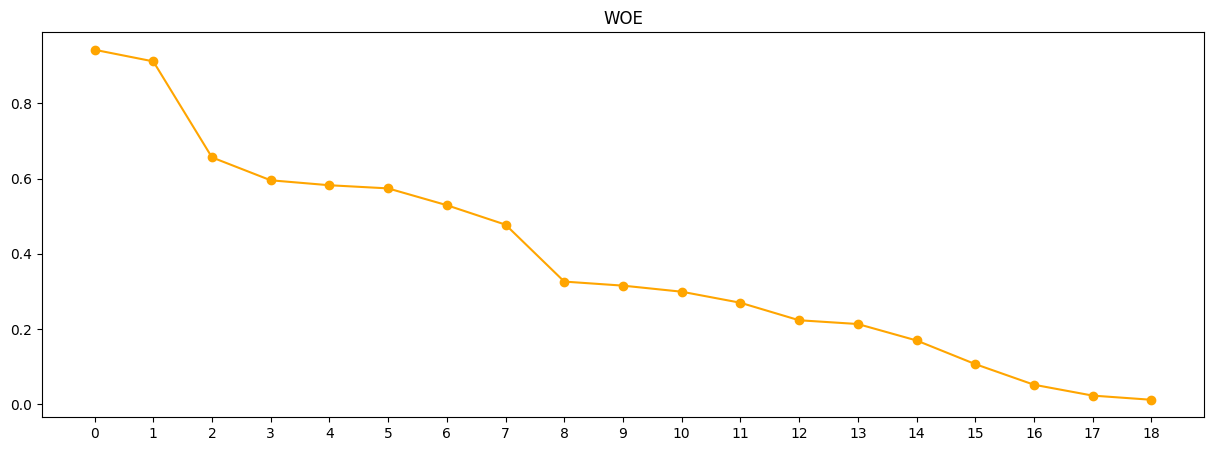

Value  Event  Non-Event       WOE        IV
0                 Services Excellence     11         29  0.942043  0.450000
1                             Unknown    969       2411  0.911224  0.426627
2                   Retail Management     34         66  0.656243  0.320000
3                  Travel and Tourism     72        131  0.595420  0.290640
4                          E-COMMERCE     40         72  0.582285  0.285714
5              International Business     64        114  0.573910  0.280899
6                          E-Business     21         36  0.529259  0.263158
7              IT Projects Management    140        226  0.477537  0.234973
8               Media and Advertising     85        118  0.326397  0.162562
9              Hospitality Management     48         66  0.315638  0.157895
10             Rural and Agribusiness     31         42  0.299517  0.150685
11            Supply Chain Management    151        198  0.270203  0.134670
12            Business Administration    179        224  0.223700  0.111663
13                 Finance Management    436        540  0.213706  0.106557
14          Human Resource Management    388        460  0.170020  0.084906
15              Operations Management    238        265  0.107246  0.053678
16               Marketing Management    408        430  0.052455  0.026253
17  Banking, Investment And Insurance    167        171  0.023600  0.011834
18              Healthcare Management     79         80  0.012500  0.006289

In [158]:
# woe-iv
calculate_woe_iv(dummy, 'specialization', 'converted')

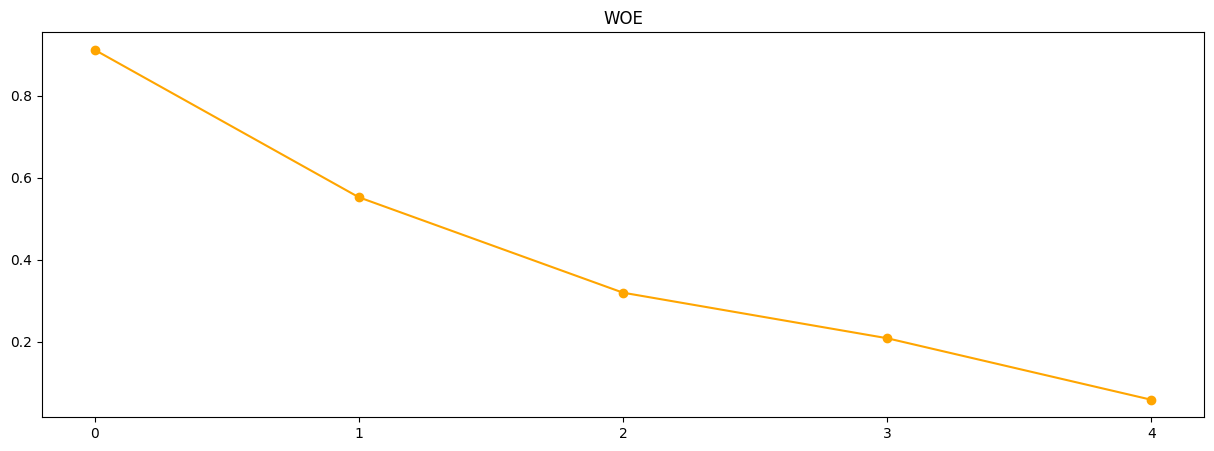

Value  Event  Non-Event       WOE        IV
0  category_5    980       2440  0.911896  0.426901
1  category_1    371        645  0.552476  0.269685
2  category_2    164        226  0.319834  0.158974
3  category_3   1154       1422  0.208749  0.104037
4  category_4    892        946  0.058744  0.029380

In [159]:
specialization_mapper = {('Travel and Tourism', 'E-COMMERCE', 'International Business', 'E-Business', 'Retail Management', 'IT Projects Management'):'category_1', 
                         ('Media and Advertising', 'Hospitality Management', 'Rural and Agribusiness'):'category_2', 
                         ('Business Administration', 'Finance Management', 'Supply Chain Management', 'Human Resource Management'):'category_3', 
                         ('Banking, Investment And Insurance', 'Healthcare Management', 'Marketing Management', 'Operations Management'):'category_4', 
                         ('Services Excellence', 'Unknown'):'category_5'}


dummy['specialization_1'] = dummy.specialization.copy()
for collection_ in specialization_mapper:
    dummy['specialization_1'] = np.where(dummy.specialization_1.isin(collection_), specialization_mapper.get(collection_), dummy.specialization_1)

specialization_woe_iv_values = calculate_woe_iv(dummy, 'specialization_1', 'converted')
specialization_woe_iv_values


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 3.9623e-56
- The chi2 discrepancy is : 264.92
	- We can reject the Null Hypothesis
	- The features specialization_1 and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


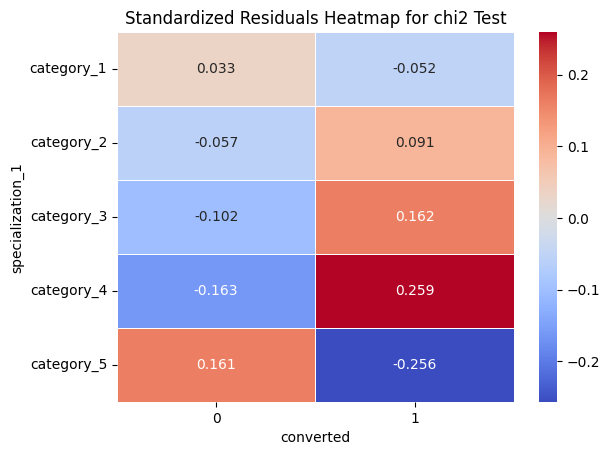

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.169
	- There is a moderate association between specialization_1 and converted
******************************************************************************************************************



In [160]:
# Association analysis of the feature with the target
cat_to_cat_association_tests(dummy, 'specialization_1', 'converted')

In [161]:
# Point biserial correlation
point_biserial_categorical_correlation(dummy, 'specialization_1', 'converted')

The p-value is 8.9591e-33.
The correlation is statistically significant !
The point biserial correlation between specialization_1 and the converted is :0.124.


0.12357968986156168

<Axes: xlabel='specialization_1'>

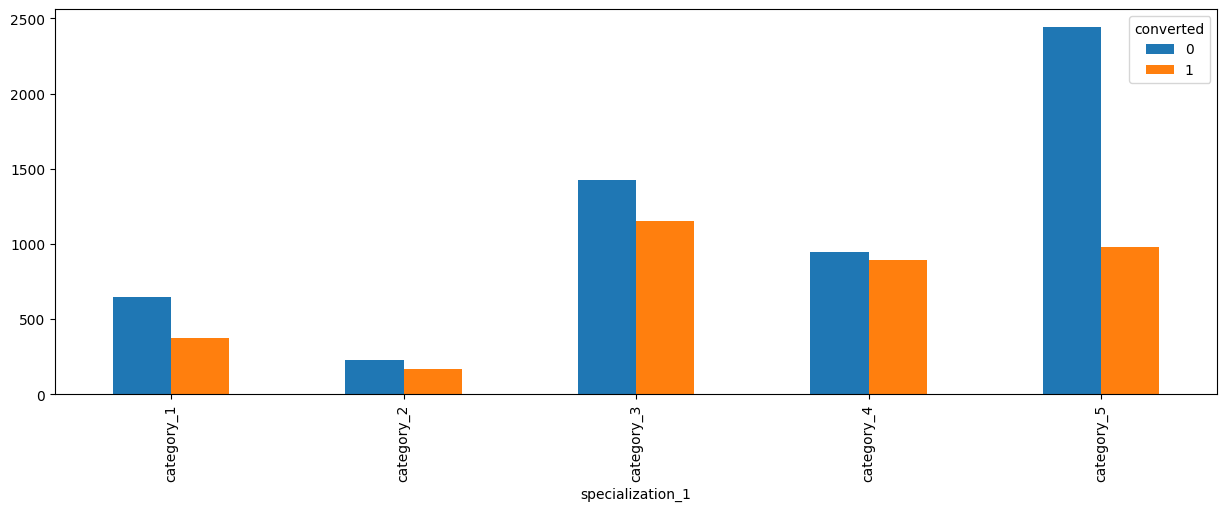

In [162]:
# Improvements can be observed in the data post merging of categories
crs = pd.crosstab(index = dummy.specialization_1, columns = dummy.converted)
crs.plot.bar(figsize = (15,5))

##### Observations:
- The correlation has improvised after clubbing of categories
- categories 3 and 4 have the highest conversion rate
- category 5 holds most of the data but the conversion rate is not very high
- from the chi2 distribution; category 4 has abnormally higher number of positive data points while category 5 is more towards the negative class

In [163]:
# Mapping the woe and iv values
specialization_woe_iv_values = specialization_woe_iv_values.rename({'WOE':'specialization_WOE', 'IV':'specialization_IV', 'Value':'specialization_1'}, axis = 'columns')
specialization_woe_iv_values = specialization_woe_iv_values.drop(columns = ['Event', 'Non-Event'])
specialization_woe_iv_values.head(3)

specialization_1  specialization_WOE  specialization_IV
0       category_5            0.911896           0.426901
1       category_1            0.552476           0.269685
2       category_2            0.319834           0.158974

In [164]:
# mapping the woe and iv values
dummy_2 = pd.merge(left = dummy, right = specialization_woe_iv_values, on = ['specialization_1'], how = 'outer')
dummy_2 = dummy_2.drop(columns = ['specialization', 'specialization_1'])
dummy_2.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  3256f628-e534-4826-9d63-4a8b88782852       660681          1   

   specialization_WOE  specialization_IV  
0            0.911896           0.426901  
1            0.911896           0.426901  
2            0.911896           0.426901


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 3.9623e-56
- The chi2 discrepancy is : 264.92
	- We can reject the Null Hypothesis
	- The features specialization_WOE and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


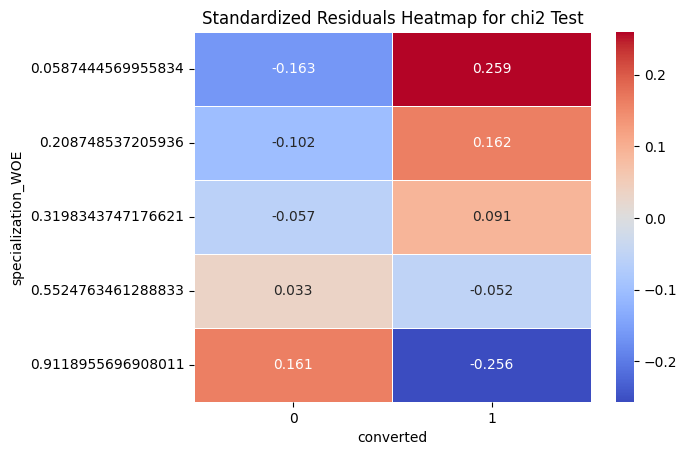

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.169
	- There is a moderate association between specialization_WOE and converted
******************************************************************************************************************

In [165]:
cat_to_cat_association_tests(dummy_2, 'specialization_WOE', 'converted')

In [166]:
point_biserial_correlation_coefficient(dummy_2, 'specialization_WOE', 'converted')

The p-value is : 2.29e-60
The correlation is statistically significant !
The point biserial correlation between specialization_WOE and the converted is :-0.169.


-0.16928925669575762


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 3.9623e-56
- The chi2 discrepancy is : 264.92
	- We can reject the Null Hypothesis
	- The features specialization_IV and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


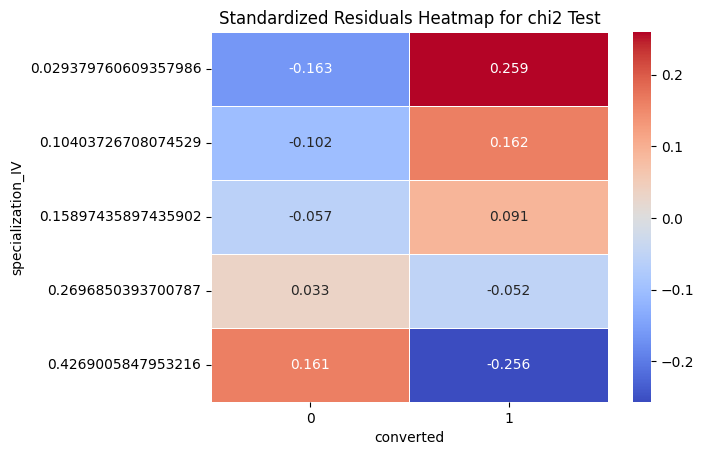

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.169
	- There is a moderate association between specialization_IV and converted
******************************************************************************************************************


In [167]:
cat_to_cat_association_tests(dummy_2, 'specialization_IV', 'converted')

In [168]:
point_biserial_correlation_coefficient(dummy_2, 'specialization_IV', 'converted')

The p-value is : 2.15e-60
The correlation is statistically significant !
The point biserial correlation between specialization_IV and the converted is :-0.169.


-0.16932623795826662

##### Observations:
- There is not much difference in the woe and iv values of specialization
- but since we have been using iv till this point, we will be using the same further on as well

In [169]:
# Mapping the specialization_iv feature to the main dataframe
categorical_data = pd.merge(left = categorical_data.drop(columns = ['specialization']), right = dummy_2.drop(columns = ['specialization_WOE']), on = unique_ids.__add__(target_variable), how = 'outer')
categorical_data.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

               lead_origin country how_did_you_hear_about_x_education  \
0                      API     NaN                             Select   
1                      API   India                             Select   
2  Landing Page Submission   India                             Select   

  what_is_your_current_occupation last_notable_activity  \
0                      Unemployed              Modified   
1                      Unemployed          Email Opened   
2                         Student          Email Opened   

  what_matters_most_to_you_in_choosing_a_course  \
0                       Better Career Prospects   
1                       Better Career Prospects   
2                       Better Career Prospects   

                                  tags      lead_quality    lead_profile  \
0          Interested in other courses  Low in Relevance          Select   
1                              Ringing               NaN          Select   
2  Will revert after reading the email          Might be  Potential Lead   

     city  lead_source_IV  last_activity_IV  specialization_IV  
0  Select        0.493059          0.524272           0.426901  
1  Select        0.269102          0.285225           0.426901  
2  Mumbai        0.269102          0.285225           0.104037

### 3.4.6 how_did_you_hear_about_x_education

In [170]:
# Missing data count
categorical_data.how_did_you_hear_about_x_education.isna().sum()

2207

In [171]:
# Missing data proportion
round(100*(categorical_data.how_did_you_hear_about_x_education.isna().sum()/categorical_data.shape[0]), 2)

23.89

In [172]:
categorical_data.how_did_you_hear_about_x_education.unique()

array(['Select', 'Word Of Mouth', 'Other', nan, 'Online Search',
       'Multiple Sources', 'Advertisements', 'Student of SomeSchool',
       'Email', 'Social Media', 'SMS'], dtype=object)

In [173]:
# Select is same as missing data
# We will mark Select as missing

categorical_data['how_did_you_hear_about_x_education'] = categorical_data.how_did_you_hear_about_x_education.replace({'Select':np.nan})
categorical_data['how_did_you_hear_about_x_education'] = categorical_data['how_did_you_hear_about_x_education'].fillna('Unknown')
categorical_data['how_did_you_hear_about_x_education'].value_counts()

how_did_you_hear_about_x_education
Unknown                  7250
Online Search             808
Word Of Mouth             348
Student of SomeSchool     310
Other                     186
Multiple Sources          152
Advertisements             70
Social Media               67
Email                      26
SMS                        23
Name: count, dtype: int64

In [174]:
round(100*(categorical_data['how_did_you_hear_about_x_education'].value_counts()/categorical_data.shape[0]), 2)

how_did_you_hear_about_x_education
Unknown                  78.46
Online Search             8.74
Word Of Mouth             3.77
Student of SomeSchool     3.35
Other                     2.01
Multiple Sources          1.65
Advertisements            0.76
Social Media              0.73
Email                     0.28
SMS                       0.25
Name: count, dtype: float64


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 0.0015032
- The chi2 discrepancy is : 26.811
	- We can reject the Null Hypothesis
	- The features how_did_you_hear_about_x_education and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


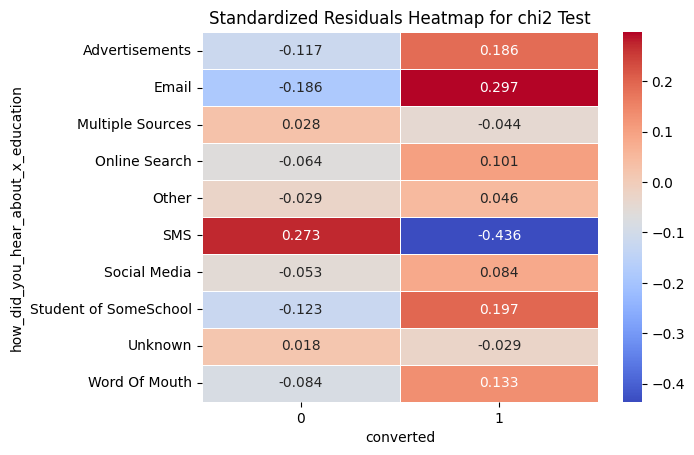

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.0539
	- There is a very weak association between how_did_you_hear_about_x_education and converted
************************************************************************************************

In [175]:
cat_to_cat_association_tests(categorical_data, 'how_did_you_hear_about_x_education', 'converted')

In [176]:
point_biserial_categorical_correlation(categorical_data, 'how_did_you_hear_about_x_education', 'converted')

The p-value is 0.00037965.
The correlation is statistically significant !
The point biserial correlation between how_did_you_hear_about_x_education and the converted is :0.037.


0.03696344322134369

##### Observation:
- The proportions gaps are very huge
- The feature is highly imbalanced in nature
- Altough there exists some dependency, the association is very weak
- It would be better not to move any further with this feature

### 3.4.7 last_notable_activity

In [177]:
# Missing data count
categorical_data.last_notable_activity.isna().sum()

0

In [178]:
categorical_data.last_notable_activity.unique()

array(['Modified', 'Email Opened', 'Page Visited on Website',
       'Email Bounced', 'Email Link Clicked', 'Unreachable',
       'Unsubscribed', 'Had a Phone Conversation',
       'Olark Chat Conversation', 'SMS Sent', 'Approached upfront',
       'Resubscribed to emails', 'View in browser link Clicked',
       'Form Submitted on Website', 'Email Received', 'Email Marked Spam'],
      dtype=object)

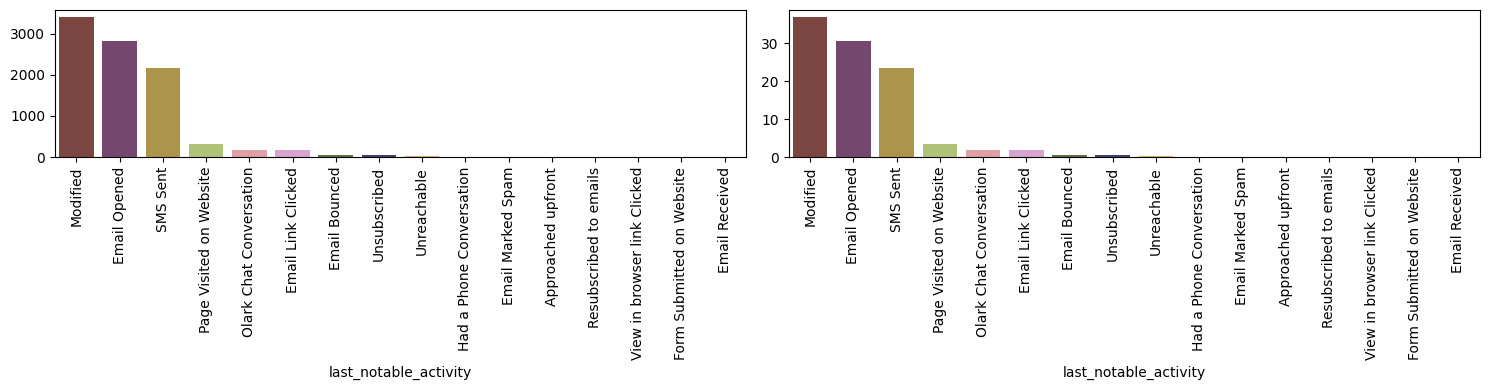

In [179]:
univariate_class_distribution_bar(categorical_data, 'last_notable_activity')

<Axes: xlabel='last_notable_activity'>

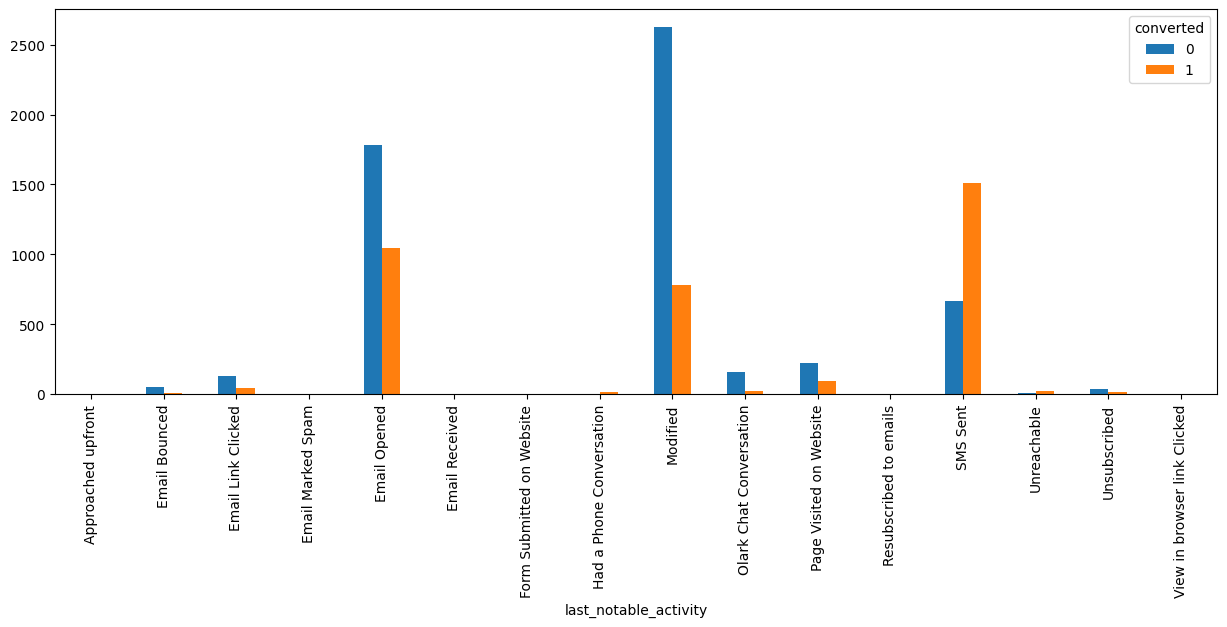

In [180]:
crs = pd.crosstab(index = categorical_data.last_notable_activity, columns = categorical_data.converted)
crs.plot.bar(figsize = (15,5))

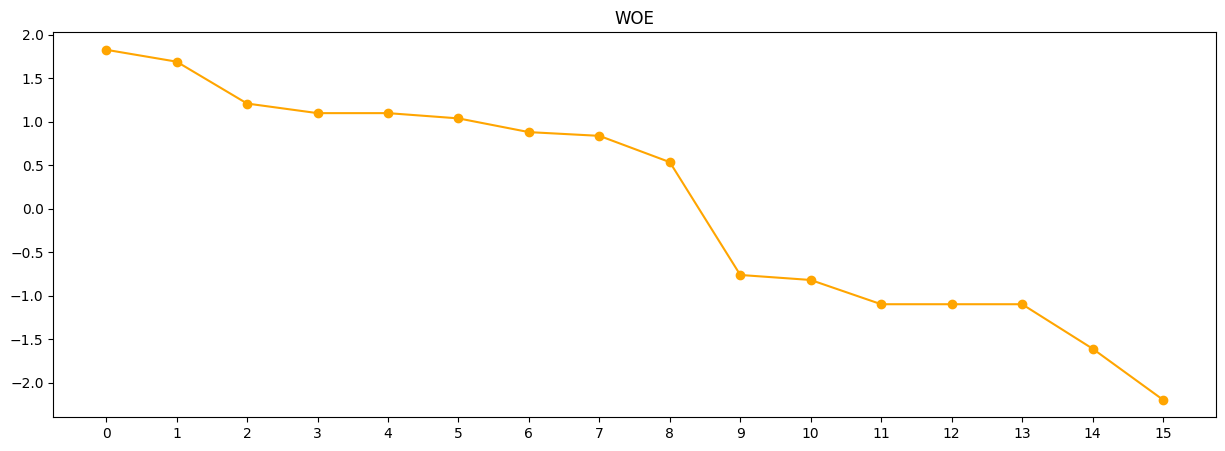

Value  Event  Non-Event       WOE        IV
0        Olark Chat Conversation     25        158  1.827076  0.726776
1                  Email Bounced      9         51  1.690290  0.700000
2                       Modified    783       2624  1.208875  0.540358
3   View in browser link Clicked      0          1  1.098612  1.000000
4      Form Submitted on Website      0          1  1.098612  1.000000
5             Email Link Clicked     45        128  1.038217  0.479769
6        Page Visited on Website     93        225  0.880359  0.415094
7                   Unsubscribed     14         33  0.837397  0.404255
8                   Email Opened   1044       1783  0.535039  0.261408
9                    Unreachable     22         10 -0.762140 -0.375000
10                      SMS Sent   1508        664 -0.819836 -0.388582
11            Approached upfront      1          0 -1.098612 -1.000000
12        Resubscribed to emails      1          0 -1.098612 -1.000000
13                Email Received      1          0 -1.098612 -1.000000
14             Email Marked Spam      2          0 -1.609438 -1.000000
15      Had a Phone Conversation     13          1 -2.197225 -0.857143

In [181]:
calculate_woe_iv(categorical_data, 'last_notable_activity', 'converted')

In [182]:
# dummy df creation for cardinality reduction in last_notable_activity
dummy = categorical_data[unique_ids.__add__(target_variable).__add__(['last_notable_activity'])]
dummy

prospect_id  lead_number  converted  \
0     7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1     2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2     8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   
3     0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719          0   
4     3256f628-e534-4826-9d63-4a8b88782852       660681          1   
...                                    ...          ...        ...   
9235  19d6451e-fcd6-407c-b83b-48e1af805ea9       579564          1   
9236  82a7005b-7196-4d56-95ce-a79f937a158d       579546          0   
9237  aac550fe-a586-452d-8d3c-f1b62c94e02c       579545          0   
9238  5330a7d1-2f2b-4df4-85d6-64ca2f6b95b9       579538          1   
9239  571b5c8e-a5b2-4d57-8574-f2ffb06fdeff       579533          1   

     last_notable_activity  
0                 Modified  
1             Email Opened  
2             Email Opened  
3                 Modified  
4                 Modified  
...                    ...  
9235     Email Marked Spam  
9236              SMS Sent  
9237              SMS Sent  
9238              SMS Sent  
9239              Modified  

[9240 rows x 4 columns]

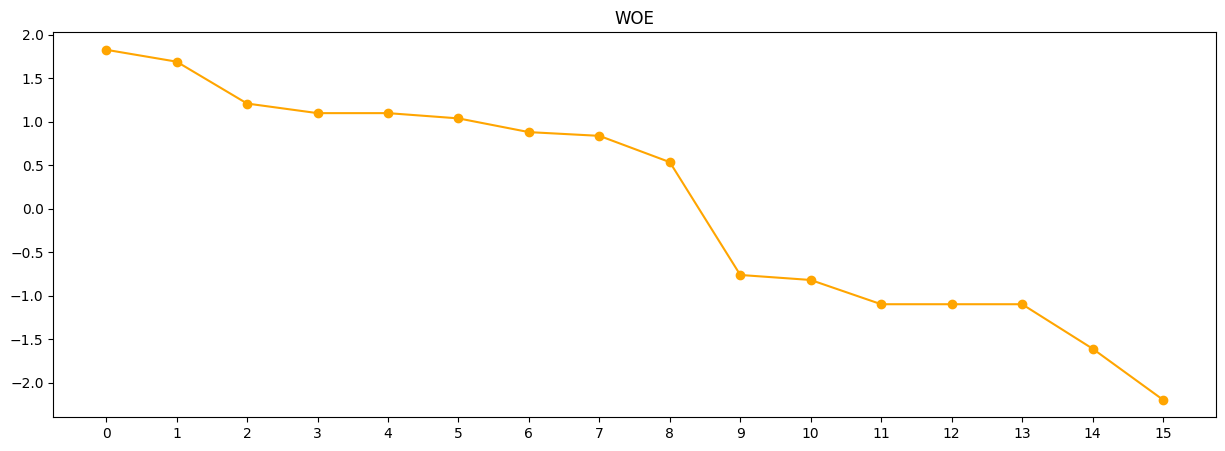

Value  Event  Non-Event       WOE        IV
0        Olark Chat Conversation     25        158  1.827076  0.726776
1                  Email Bounced      9         51  1.690290  0.700000
2                       Modified    783       2624  1.208875  0.540358
3   View in browser link Clicked      0          1  1.098612  1.000000
4      Form Submitted on Website      0          1  1.098612  1.000000
5             Email Link Clicked     45        128  1.038217  0.479769
6        Page Visited on Website     93        225  0.880359  0.415094
7                   Unsubscribed     14         33  0.837397  0.404255
8                   Email Opened   1044       1783  0.535039  0.261408
9                    Unreachable     22         10 -0.762140 -0.375000
10                      SMS Sent   1508        664 -0.819836 -0.388582
11            Approached upfront      1          0 -1.098612 -1.000000
12        Resubscribed to emails      1          0 -1.098612 -1.000000
13                Email Received      1          0 -1.098612 -1.000000
14             Email Marked Spam      2          0 -1.609438 -1.000000
15      Had a Phone Conversation     13          1 -2.197225 -0.857143

In [183]:
# WOE of last_notable_activity
calculate_woe_iv(dummy, 'last_notable_activity', 'converted')

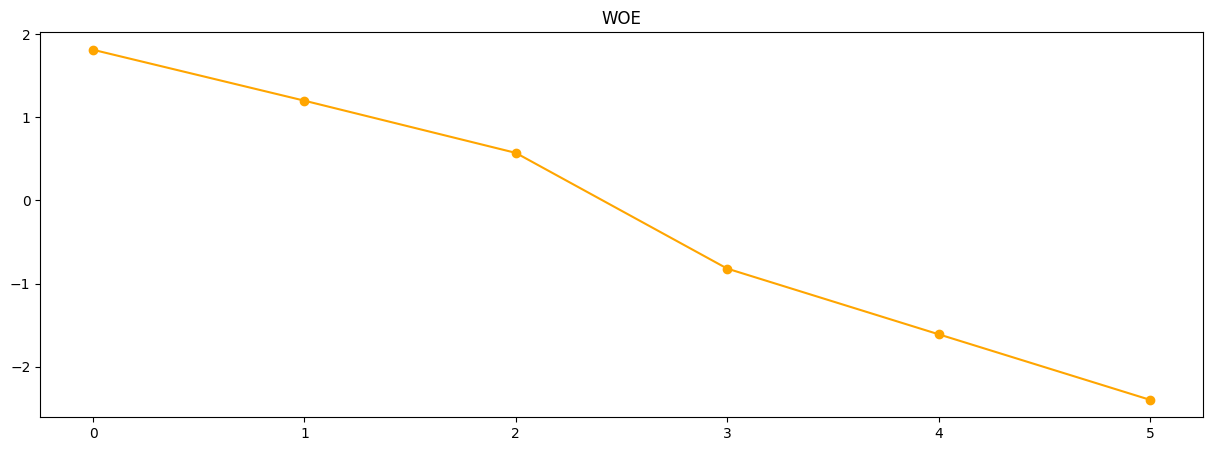

Value  Event  Non-Event       WOE        IV
0  category_1     34        211  1.813266  0.722449
1  category_5    828       2752  1.200648  0.537430
2  category_2   1151       2041  0.572619  0.278822
3  category_4   1530        674 -0.819378 -0.388385
4  category_6      2          0 -1.609438 -1.000000
5  category_3     16          1 -2.397895 -0.882353

In [184]:
# Reducing cardinality using WOE
last_notable_activity_mapper = {('View in browser link Clicked', 'Form Submitted on Website', 'Email Bounced', 'Olark Chat Conversation'):'category_1', 
                                ('Page Visited on Website', 'Unsubscribed', 'Email Opened'):'category_2', 
                                ('Approached upfront', 'Resubscribed to emails', 'Email Received', 'Had a Phone Conversation'):'category_3', 
                                ('Unreachable', 'SMS Sent'):'category_4', 
                                ('Modified', 'Email Link Clicked'):'category_5', 
                                ('Email Marked Spam',):'category_6'}

dummy['last_notable_activity_1'] = dummy.last_notable_activity.copy()
for collection_ in last_notable_activity_mapper:
    dummy['last_notable_activity_1'] = np.where(dummy.last_notable_activity_1.isin(collection_), last_notable_activity_mapper.get(collection_), dummy.last_notable_activity_1)

last_notable_activity_woe_iv = calculate_woe_iv(dummy, 'last_notable_activity_1', 'converted')
last_notable_activity_woe_iv

In [185]:
# Mapping the updated woe and iv values to the categories
last_notable_activity_woe_iv = last_notable_activity_woe_iv.rename({'Value':'last_notable_activity_1', 'WOE':'last_notable_activity_WOE', 'IV':'last_notable_activity_IV'}, axis = 'columns').drop(columns = ['Event', 'Non-Event'])
last_notable_activity_woe_iv

last_notable_activity_1  last_notable_activity_WOE  last_notable_activity_IV
0              category_1                   1.813266                  0.722449
1              category_5                   1.200648                  0.537430
2              category_2                   0.572619                  0.278822
3              category_4                  -0.819378                 -0.388385
4              category_6                  -1.609438                 -1.000000
5              category_3                  -2.397895                 -0.882353

In [186]:
# mapping the woe and iv values to the dataframe
dummy = pd.merge(left = dummy, right = last_notable_activity_woe_iv, on = 'last_notable_activity_1', how = 'left').drop(columns = ['last_notable_activity', 'last_notable_activity_1'])
dummy

prospect_id  lead_number  converted  \
0     7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1     2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2     8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   
3     0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719          0   
4     3256f628-e534-4826-9d63-4a8b88782852       660681          1   
...                                    ...          ...        ...   
9235  19d6451e-fcd6-407c-b83b-48e1af805ea9       579564          1   
9236  82a7005b-7196-4d56-95ce-a79f937a158d       579546          0   
9237  aac550fe-a586-452d-8d3c-f1b62c94e02c       579545          0   
9238  5330a7d1-2f2b-4df4-85d6-64ca2f6b95b9       579538          1   
9239  571b5c8e-a5b2-4d57-8574-f2ffb06fdeff       579533          1   

      last_notable_activity_WOE  last_notable_activity_IV  
0                      1.200648                  0.537430  
1                      0.572619                  0.278822  
2                      0.572619                  0.278822  
3                      1.200648                  0.537430  
4                      1.200648                  0.537430  
...                         ...                       ...  
9235                  -1.609438                 -1.000000  
9236                  -0.819378                 -0.388385  
9237                  -0.819378                 -0.388385  
9238                  -0.819378                 -0.388385  
9239                   1.200648                  0.537430  

[9240 rows x 5 columns]

In [187]:
point_biserial_correlation_coefficient(dummy, 'last_notable_activity_WOE', 'converted')

The p-value is : 5.32e-316
The correlation is statistically significant !
The point biserial correlation between last_notable_activity_WOE and the converted is :-0.38.


-0.380432426621604

In [188]:
point_biserial_correlation_coefficient(dummy, 'last_notable_activity_IV', 'converted')

The p-value is : 2.13e-317
The correlation is statistically significant !
The point biserial correlation between last_notable_activity_IV and the converted is :-0.381.


-0.3812143462081156

##### Observations:
- Both WOE and IV have the same correlation of co-efficients
- We will proceed with IV since we have been mapping the same so far

In [189]:
# Mapping the last activity iv values to the categorical data
categorical_data = pd.merge(left = categorical_data.drop(columns = ['last_notable_activity']), right = dummy.drop(columns = ['last_notable_activity_WOE']), on = unique_ids.__add__(target_variable), how = 'outer')
categorical_data.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

               lead_origin country how_did_you_hear_about_x_education  \
0                      API     NaN                            Unknown   
1                      API   India                            Unknown   
2  Landing Page Submission   India                            Unknown   

  what_is_your_current_occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   

  what_matters_most_to_you_in_choosing_a_course  \
0                       Better Career Prospects   
1                       Better Career Prospects   
2                       Better Career Prospects   

                                  tags      lead_quality    lead_profile  \
0          Interested in other courses  Low in Relevance          Select   
1                              Ringing               NaN          Select   
2  Will revert after reading the email          Might be  Potential Lead   

     city  lead_source_IV  last_activity_IV  specialization_IV  \
0  Select        0.493059          0.524272           0.426901   
1  Select        0.269102          0.285225           0.426901   
2  Mumbai        0.269102          0.285225           0.104037   

   last_notable_activity_IV  
0                  0.537430  
1                  0.278822  
2                  0.278822

### 3.4.8 city

In [190]:
# Quantifying the missing values
categorical_data.city.isna().sum()

1420

In [191]:
# Quantifying the missing values proportions
round(100*(categorical_data.city.isna().sum()/categorical_data.shape[0]), 2)

15.37

In [192]:
# Unique values
categorical_data.city.unique()

array(['Select', 'Mumbai', nan, 'Thane & Outskirts', 'Other Metro Cities',
       'Other Cities', 'Other Cities of Maharashtra', 'Tier II Cities'],
      dtype=object)

##### Note:
- Select is the same as missing values
- Setting the same as missing data

In [193]:
# Replacing `Select` in city with missing
categorical_data['city'] = categorical_data.city.replace({'Select':np.nan})
categorical_data.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

               lead_origin country how_did_you_hear_about_x_education  \
0                      API     NaN                            Unknown   
1                      API   India                            Unknown   
2  Landing Page Submission   India                            Unknown   

  what_is_your_current_occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   

  what_matters_most_to_you_in_choosing_a_course  \
0                       Better Career Prospects   
1                       Better Career Prospects   
2                       Better Career Prospects   

                                  tags      lead_quality    lead_profile  \
0          Interested in other courses  Low in Relevance          Select   
1                              Ringing               NaN          Select   
2  Will revert after reading the email          Might be  Potential Lead   

     city  lead_source_IV  last_activity_IV  specialization_IV  \
0     NaN        0.493059          0.524272           0.426901   
1     NaN        0.269102          0.285225           0.426901   
2  Mumbai        0.269102          0.285225           0.104037   

   last_notable_activity_IV  
0                  0.537430  
1                  0.278822  
2                  0.278822

In [194]:
# Quantifying the missing values
categorical_data.city.isna().sum()

3669

In [195]:
# Quantifying the missing values proportions
round(100*(categorical_data.city.isna().sum()/categorical_data.shape[0]), 2)

39.71

In [196]:
# Quantifying the distribution of categories
categorical_data.city.value_counts()

city
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: count, dtype: int64

In [197]:
# Quantifying the distribution of categories
round(100*(categorical_data.city.value_counts(normalize = True)), 2)

city
Mumbai                         57.84
Thane & Outskirts              13.50
Other Cities                   12.31
Other Cities of Maharashtra     8.20
Other Metro Cities              6.82
Tier II Cities                  1.33
Name: proportion, dtype: float64

##### Observations:
- The distribution is very much imbalanced

In [198]:
# Filling missing values with `Unknown`
categorical_data['city'] = categorical_data.city.fillna('Unknown')
categorical_data.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

               lead_origin country how_did_you_hear_about_x_education  \
0                      API     NaN                            Unknown   
1                      API   India                            Unknown   
2  Landing Page Submission   India                            Unknown   

  what_is_your_current_occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   

  what_matters_most_to_you_in_choosing_a_course  \
0                       Better Career Prospects   
1                       Better Career Prospects   
2                       Better Career Prospects   

                                  tags      lead_quality    lead_profile  \
0          Interested in other courses  Low in Relevance          Select   
1                              Ringing               NaN          Select   
2  Will revert after reading the email          Might be  Potential Lead   

      city  lead_source_IV  last_activity_IV  specialization_IV  \
0  Unknown        0.493059          0.524272           0.426901   
1  Unknown        0.269102          0.285225           0.426901   
2   Mumbai        0.269102          0.285225           0.104037   

   last_notable_activity_IV  
0                  0.537430  
1                  0.278822  
2                  0.278822

In [199]:
# Reducing cardinality of city feature
dummy = categorical_data[unique_ids.__add__(target_variable).__add__(['city'])]
dummy.head(3)

prospect_id  lead_number  converted     city
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0  Unknown
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0  Unknown
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   Mumbai

In [200]:
# Quantifying the distributions of categories
dummy.city.value_counts()

city
Unknown                        3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: count, dtype: int64

In [201]:
# Quantifying the proportional distributions of categories
round(100*(dummy.city.value_counts(normalize = True)),2)

city
Unknown                        39.71
Mumbai                         34.87
Thane & Outskirts               8.14
Other Cities                    7.42
Other Cities of Maharashtra     4.95
Other Metro Cities              4.11
Tier II Cities                  0.80
Name: proportion, dtype: float64


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 3.8581e-10
- The chi2 discrepancy is : 55.395
	- We can reject the Null Hypothesis
	- The features city and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


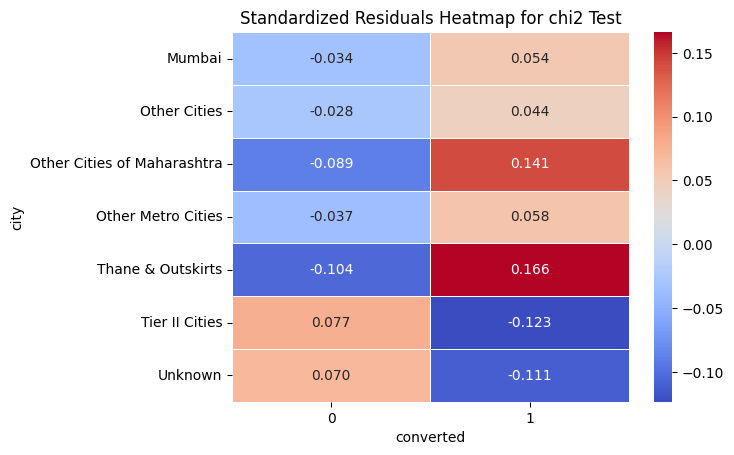

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.0774
	- There is a very weak association between city and converted
******************************************************************************************************************

4. Theils 

In [202]:
# Analysing the relationship with the target
cat_to_cat_association_tests(dummy, 'city', 'converted')

In [203]:
# Point Biserial Corerlation
point_biserial_categorical_correlation(dummy, 'city', 'converted')

The p-value is 1.3448e-06.
The correlation is statistically significant !
The point biserial correlation between city and the converted is :0.0503.


0.05025349715662203

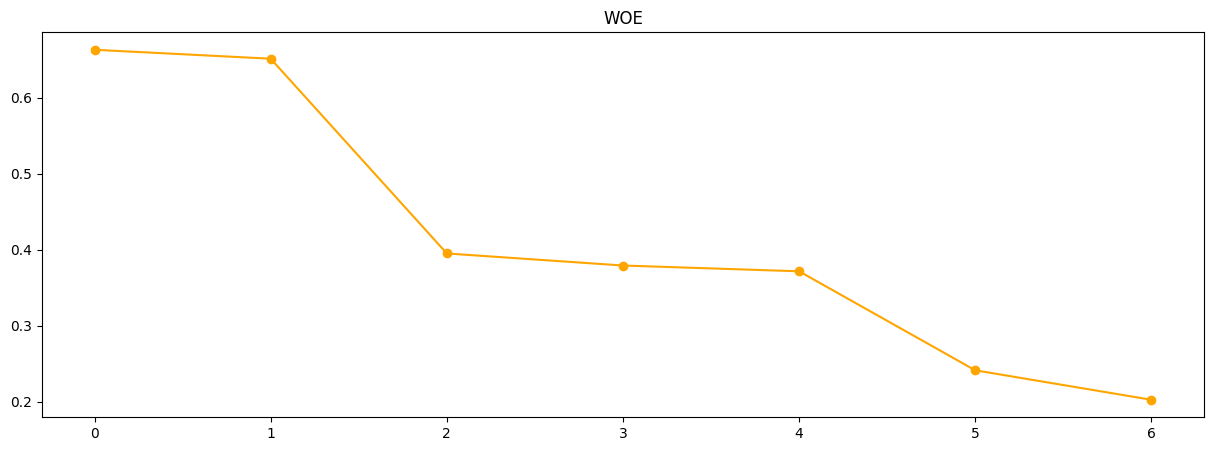

Value  Event  Non-Event       WOE        IV
0               Tier II Cities     25         49  0.663294  0.324324
1                      Unknown   1257       2412  0.651538  0.314800
2                 Other Cities    276        410  0.395165  0.195335
3                       Mumbai   1309       1913  0.379289  0.187461
4           Other Metro Cities    155        225  0.371674  0.184211
5  Other Cities of Maharashtra    201        256  0.241339  0.120350
6            Thane & Outskirts    338        414  0.202549  0.101064

In [204]:
calculate_woe_iv(dummy, 'city', 'converted')

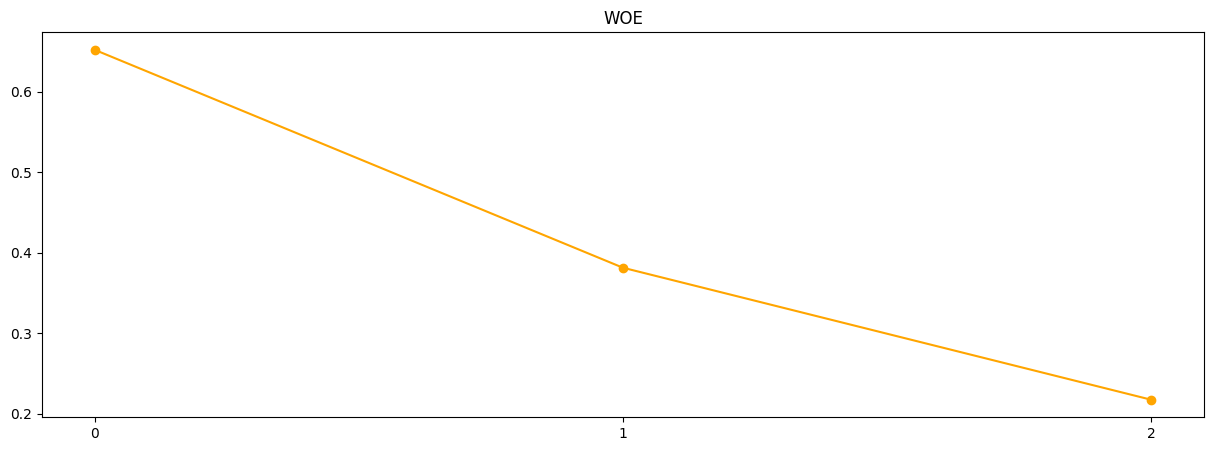

Value  Event  Non-Event       WOE        IV
0  category_1   1282       2461  0.651960  0.314988
1  category_2   1740       2548  0.381333  0.188433
2  category_3    539        670  0.217381  0.108354

In [205]:
# Reducing cardinality using WOE
city_mapper = {('Other Cities', 'Mumbai', 'Other Metro Cities'):'category_2',
               ('Tier II Cities', 'Unknown'):'category_1', 
               ('Other Cities of Maharashtra', 'Thane & Outskirts'):'category_3'}

dummy['city_1'] = dummy.city.copy()

for collection_ in city_mapper:
    dummy['city_1'] = np.where(dummy.city_1.isin(collection_), city_mapper.get(collection_), dummy.city_1)
city_woe_iv = calculate_woe_iv(dummy, 'city_1', 'converted')
city_woe_iv

In [206]:
# Renaming the features
city_woe_iv = city_woe_iv.rename({'Value':'city_1', 'WOE':'city_WOE', 'IV':'city_IV'}, axis = 'columns').drop(columns = ['Event', 'Non-Event'])
city_woe_iv

city_1  city_WOE   city_IV
0  category_1  0.651960  0.314988
1  category_2  0.381333  0.188433
2  category_3  0.217381  0.108354

In [207]:
# Mapping the woe and iv values to the categories
dummy = pd.merge(left = dummy, right = city_woe_iv, on = 'city_1', how = 'left').drop(columns = ['city', 'city_1'])
dummy.head(3)

prospect_id  lead_number  converted  city_WOE  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0  0.651960   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0  0.651960   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1  0.381333   

    city_IV  
0  0.314988  
1  0.314988  
2  0.188433

In [208]:
point_biserial_correlation_coefficient(dummy, 'city_WOE', 'converted')

The p-value is : 9.96e-14
The correlation is statistically significant !
The point biserial correlation between city_WOE and the converted is :-0.0773.


-0.07730810527254392

In [209]:
point_biserial_correlation_coefficient(dummy, 'city_IV', 'converted')

The p-value is : 9.92e-14
The correlation is statistically significant !
The point biserial correlation between city_IV and the converted is :-0.0773.


-0.07731372936754369

##### Observations:
- There exists a relation but the association is very weak
- We will be mapping the IV values to the categorical dataframe since there is no such difference between the WOE and IV correlations

In [210]:
# Mapping the city IV values to the categorical dataframe
categorical_data = pd.merge(left = categorical_data.drop(columns = ['city']), right = dummy.drop(columns = ['city_WOE']), on = unique_ids.__add__(target_variable), how = 'left')
categorical_data.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

               lead_origin country how_did_you_hear_about_x_education  \
0                      API     NaN                            Unknown   
1                      API   India                            Unknown   
2  Landing Page Submission   India                            Unknown   

  what_is_your_current_occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   

  what_matters_most_to_you_in_choosing_a_course  \
0                       Better Career Prospects   
1                       Better Career Prospects   
2                       Better Career Prospects   

                                  tags      lead_quality    lead_profile  \
0          Interested in other courses  Low in Relevance          Select   
1                              Ringing               NaN          Select   
2  Will revert after reading the email          Might be  Potential Lead   

   lead_source_IV  last_activity_IV  specialization_IV  \
0        0.493059          0.524272           0.426901   
1        0.269102          0.285225           0.426901   
2        0.269102          0.285225           0.104037   

   last_notable_activity_IV   city_IV  
0                  0.537430  0.314988  
1                  0.278822  0.314988  
2                  0.278822  0.188433

### 3.4.9 Dropping the features with missing values higher than 25%

In [211]:
# Getting the column names with missing data more than 25%
bad_columns = percent_missing[percent_missing>25].index
bad_columns

Index(['country', 'what_is_your_current_occupation',
       'what_matters_most_to_you_in_choosing_a_course', 'tags', 'lead_quality',
       'lead_profile'],
      dtype='object')

In [212]:
# Removing the bad features
categorical_data = categorical_data.drop(columns = bad_columns)
categorical_data.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

               lead_origin how_did_you_hear_about_x_education  lead_source_IV  \
0                      API                            Unknown        0.493059   
1                      API                            Unknown        0.269102   
2  Landing Page Submission                            Unknown        0.269102   

   last_activity_IV  specialization_IV  last_notable_activity_IV   city_IV  
0          0.524272           0.426901                  0.537430  0.314988  
1          0.285225           0.426901                  0.278822  0.314988  
2          0.285225           0.104037                  0.278822  0.188433

## 3.5 Collating the dataframes

In [213]:
# Flag dataset + numerical datset
flag_numerical_data = pd.merge(left = flag_data, right = numerical_data, on = unique_ids.__add__(target_variable), how = 'outer')


# Flag dataset + Numerical dataset + categorical dataset
final_df = pd.merge(left = flag_numerical_data, right = categorical_data, on = unique_ids.__add__(target_variable), how = 'outer')

final_df.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

   a_free_copy_of_mastering_the_interview  totalvisits  \
0                                       0          0.0   
1                                       0          5.0   
2                                       1          2.0   

   total_time_spent_on_website  page_views_per_visit              lead_origin  \
0                            0                   0.0                      API   
1                          674                   2.5                      API   
2                         1532                   2.0  Landing Page Submission   

  how_did_you_hear_about_x_education  lead_source_IV  last_activity_IV  \
0                            Unknown        0.493059          0.524272   
1                            Unknown        0.269102          0.285225   
2                            Unknown        0.269102          0.285225   

   specialization_IV  last_notable_activity_IV   city_IV  
0           0.426901                  0.537430  0.314988  
1           0.426901                  0.278822  0.314988  
2           0.104037                  0.278822  0.188433

# 4. Data Preparation

In [214]:
final_df.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

   a_free_copy_of_mastering_the_interview  totalvisits  \
0                                       0          0.0   
1                                       0          5.0   
2                                       1          2.0   

   total_time_spent_on_website  page_views_per_visit              lead_origin  \
0                            0                   0.0                      API   
1                          674                   2.5                      API   
2                         1532                   2.0  Landing Page Submission   

  how_did_you_hear_about_x_education  lead_source_IV  last_activity_IV  \
0                            Unknown        0.493059          0.524272   
1                            Unknown        0.269102          0.285225   
2                            Unknown        0.269102          0.285225   

   specialization_IV  last_notable_activity_IV   city_IV  
0           0.426901                  0.537430  0.314988  
1           0.426901                  0.278822  0.314988  
2           0.104037                  0.278822  0.188433

In [215]:
# Quantifying the missing values
final_df.isna().sum()

prospect_id                                 0
lead_number                                 0
converted                                   0
a_free_copy_of_mastering_the_interview      0
totalvisits                               137
total_time_spent_on_website                 0
page_views_per_visit                      137
lead_origin                                 0
how_did_you_hear_about_x_education          0
lead_source_IV                             36
last_activity_IV                          103
specialization_IV                           0
last_notable_activity_IV                    0
city_IV                                     0
dtype: int64

In [216]:
# Quantifying the proportion of the missing data
round(100*(final_df.isna().sum()/final_df.shape[0]), 2)

prospect_id                               0.00
lead_number                               0.00
converted                                 0.00
a_free_copy_of_mastering_the_interview    0.00
totalvisits                               1.48
total_time_spent_on_website               0.00
page_views_per_visit                      1.48
lead_origin                               0.00
how_did_you_hear_about_x_education        0.00
lead_source_IV                            0.39
last_activity_IV                          1.11
specialization_IV                         0.00
last_notable_activity_IV                  0.00
city_IV                                   0.00
dtype: float64

In [217]:
# Removing the missing data
final_df = final_df.dropna().reset_index(drop = True)

# Quantifying the proportion of the missing data
round(100*(final_df.isna().sum()/final_df.shape[0]), 2)

prospect_id                               0.0
lead_number                               0.0
converted                                 0.0
a_free_copy_of_mastering_the_interview    0.0
totalvisits                               0.0
total_time_spent_on_website               0.0
page_views_per_visit                      0.0
lead_origin                               0.0
how_did_you_hear_about_x_education        0.0
lead_source_IV                            0.0
last_activity_IV                          0.0
specialization_IV                         0.0
last_notable_activity_IV                  0.0
city_IV                                   0.0
dtype: float64

In [218]:
# Checking the stats of the dataset
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9074 entries, 0 to 9073
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   prospect_id                             9074 non-null   object 
 1   lead_number                             9074 non-null   int64  
 2   converted                               9074 non-null   int64  
 3   a_free_copy_of_mastering_the_interview  9074 non-null   int64  
 4   totalvisits                             9074 non-null   float64
 5   total_time_spent_on_website             9074 non-null   int64  
 6   page_views_per_visit                    9074 non-null   float64
 7   lead_origin                             9074 non-null   object 
 8   how_did_you_hear_about_x_education      9074 non-null   object 
 9   lead_source_IV                          9074 non-null   float64
 10  last_activity_IV                        9074 non-null   floa

In [219]:
full_statistical_description(final_df, sort = True)

mean           std  \
totalvisits                                  3.456028      4.858802   
lead_source_IV                               0.244194      0.303741   
page_views_per_visit                         2.370151      2.160871   
total_time_spent_on_website                482.887481    545.256560   
last_notable_activity_IV                     0.225794      0.371353   
a_free_copy_of_mastering_the_interview       0.318272      0.465831   
converted                                    0.378554      0.485053   
specialization_IV                            0.228132      0.164524   
lead_number                             617032.619352  23348.029512   
last_activity_IV                             0.239709      0.383477   
city_IV                                      0.228815      0.075182   
prospect_id                                       NaN           NaN   
lead_origin                                       NaN           NaN   
how_did_you_hear_about_x_education                NaN           NaN   

                                                  min            25%  \
totalvisits                                  0.000000       1.000000   
lead_source_IV                              -1.000000       0.269102   
page_views_per_visit                         0.000000       1.000000   
total_time_spent_on_website                  0.000000      11.000000   
last_notable_activity_IV                    -1.000000       0.278822   
a_free_copy_of_mastering_the_interview       0.000000       0.000000   
converted                                    0.000000       0.000000   
specialization_IV                            0.029380       0.104037   
lead_number                             579533.000000  596406.000000   
last_activity_IV                            -1.000000      -0.258288   
city_IV                                      0.108354       0.188433   
prospect_id                                       NaN            NaN   
lead_origin                                       NaN            NaN   
how_did_you_hear_about_x_education                NaN            NaN   

                                                  50%            75%  \
totalvisits                                  3.000000       5.000000   
lead_source_IV                               0.269102       0.269102   
page_views_per_visit                         2.000000       3.200000   
total_time_spent_on_website                246.000000     922.750000   
last_notable_activity_IV                     0.278822       0.537430   
a_free_copy_of_mastering_the_interview       0.000000       1.000000   
converted                                    0.000000       1.000000   
specialization_IV                            0.158974       0.426901   
lead_number                             615278.500000  637176.500000   
last_activity_IV                             0.285225       0.524272   
city_IV                                      0.188433       0.314988   
prospect_id                                       NaN            NaN   
lead_origin                                       NaN            NaN   
how_did_you_hear_about_x_education                NaN            NaN   

                                                  max   Skewness    Kurtosis  
totalvisits                                251.000000  19.921091  853.250387  
lead_source_IV                               1.000000  -3.006077    8.625016  
page_views_per_visit                        55.000000   2.877019   42.510010  
total_time_spent_on_website               2272.000000   0.970703   -0.373266  
last_notable_activity_IV                     0.722449  -0.857205   -0.749101  
a_free_copy_of_mastering_the_interview       1.000000   0.780403   -1.391278  
converted                                    1.000000   0.500863   -1.749522  
specialization_IV                            0.426901   0.171863   -1.702091  
lead_number                             660737.000000   0.145028   -1.200266  
last_activity_IV               

##### Observations:
- There are a few features that have a very high skewness alongwith a very narrow peak `totalvisits`
- Almost all the other features are having a decent spread

## 4.1 Encoding the categorical features

In [220]:
final_df.head()

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719          0   
4  3256f628-e534-4826-9d63-4a8b88782852       660681          1   

   a_free_copy_of_mastering_the_interview  totalvisits  \
0                                       0          0.0   
1                                       0          5.0   
2                                       1          2.0   
3                                       0          1.0   
4                                       0          2.0   

   total_time_spent_on_website  page_views_per_visit              lead_origin  \
0                            0                   0.0                      API   
1                          674                   2.5                      API   
2                         1532                   2.0  Landing Page Submission   
3                          305                   1.0  Landing Page Submission   
4                         1428                   1.0  Landing Page Submission   

  how_did_you_hear_about_x_education  lead_source_IV  last_activity_IV  \
0                            Unknown        0.493059          0.524272   
1                            Unknown        0.269102          0.285225   
2                            Unknown        0.269102          0.285225   
3                      Word Of Mouth        0.269102          0.285225   
4                              Other        0.269102          0.747664   

   specialization_IV  last_notable_activity_IV   city_IV  
0           0.426901                  0.537430  0.314988  
1           0.426901                  0.278822  0.314988  
2           0.104037                  0.278822  0.188433  
3           0.158974                  0.537430  0.188433  
4           0.426901                  0.537430  0.188433

In [221]:
# Features that needs to be encoded
features_to_be_encoded = ['lead_origin', 'how_did_you_hear_about_x_education']

In [222]:
# Visualizing the cardinality
for cat_col in features_to_be_encoded:
    print('*'*114)
    print(f'Current Feature : {cat_col}')
    print(f'Cardinality : {final_df[cat_col].nunique()}')
    print(f'Categories : {final_df[cat_col].unique()}')
    print()
    print(final_df[cat_col].value_counts())
    print()
    print('*'*114)

******************************************************************************************************************
Current Feature : lead_origin
Cardinality : 4
Categories : ['API' 'Landing Page Submission' 'Lead Add Form' 'Lead Import']

lead_origin
Landing Page Submission    4885
API                        3578
Lead Add Form               581
Lead Import                  30
Name: count, dtype: int64

******************************************************************************************************************
******************************************************************************************************************
Current Feature : how_did_you_hear_about_x_education
Cardinality : 10
Categories : ['Unknown' 'Word Of Mouth' 'Other' 'Online Search' 'Multiple Sources'
 'Advertisements' 'Student of SomeSchool' 'Email' 'Social Media' 'SMS']

how_did_you_hear_about_x_education
Unknown                  7086
Online Search             808
Word Of Mouth             347
Student of So

##### Observations:
- The features that we have for encoding has no inter relationship between the categories
- One Hot Encoding is the best option for such instances so we will perform the same

In [223]:
# One hot encoding lead_origin
lead_origin_dummies = pd.get_dummies(final_df.lead_origin, prefix = 'lead_origin', dtype = int, drop_first = True)

# Concatenating the dummy features to the final dataframe
final_df = pd.concat((final_df.drop(columns = ['lead_origin']), lead_origin_dummies), axis = 'columns')
final_df.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

   a_free_copy_of_mastering_the_interview  totalvisits  \
0                                       0          0.0   
1                                       0          5.0   
2                                       1          2.0   

   total_time_spent_on_website  page_views_per_visit  \
0                            0                   0.0   
1                          674                   2.5   
2                         1532                   2.0   

  how_did_you_hear_about_x_education  lead_source_IV  last_activity_IV  \
0                            Unknown        0.493059          0.524272   
1                            Unknown        0.269102          0.285225   
2                            Unknown        0.269102          0.285225   

   specialization_IV  last_notable_activity_IV   city_IV  \
0           0.426901                  0.537430  0.314988   
1           0.426901                  0.278822  0.314988   
2           0.104037                  0.278822  0.188433   

   lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   

   lead_origin_Lead Import  
0                        0  
1                        0  
2                        0

In [224]:
# One hot encoding how_did_you_hear_about_x_education
how_did_you_hear_about_x_education_dummies = pd.get_dummies(final_df.how_did_you_hear_about_x_education, prefix = 'how_did_you_hear_about_x_education', dtype = int, drop_first = True)

# Concatenating the dummy features to the final dataframe
final_df = pd.concat((final_df.drop(columns = ['how_did_you_hear_about_x_education']), how_did_you_hear_about_x_education_dummies), axis = 'columns')
final_df.head(3)

prospect_id  lead_number  converted  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737          0   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728          0   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1   

   a_free_copy_of_mastering_the_interview  totalvisits  \
0                                       0          0.0   
1                                       0          5.0   
2                                       1          2.0   

   total_time_spent_on_website  page_views_per_visit  lead_source_IV  \
0                            0                   0.0        0.493059   
1                          674                   2.5        0.269102   
2                         1532                   2.0        0.269102   

   last_activity_IV  specialization_IV  last_notable_activity_IV   city_IV  \
0          0.524272           0.426901                  0.537430  0.314988   
1          0.285225           0.426901                  0.278822  0.314988   
2          0.285225           0.104037                  0.278822  0.188433   

   lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   

   lead_origin_Lead Import  how_did_you_hear_about_x_education_Email  \
0                        0                                         0   
1                        0                                         0   
2                        0                                         0   

   how_did_you_hear_about_x_education_Multiple Sources  \
0                                                    0   
1                                                    0   
2                                                    0   

   how_did_you_hear_about_x_education_Online Search  \
0                                                 0   
1                                                 0   
2                                                 0   

   how_did_you_hear_about_x_education_Other  \
0                                         0   
1                                         0   
2                                         0   

   how_did_you_hear_about_x_education_SMS  \
0                                       0   
1                                       0   
2                                       0   

   how_did_you_hear_about_x_education_Social Media  \
0                                                0   
1                                                0   
2                                                0   

   how_did_you_hear_about_x_education_Student of SomeSchool  \
0                                                         0   
1                                                         0   
2                                                         0   

   how_did_you_hear_about_x_education_Unknown  \
0                                           1   
1                                           1   
2                                           1   

   how_did_you_hear_about_x_education_Word Of Mouth  
0                                                 0  
1                                                 0  
2                                                 0

In [225]:
# Visualizing the data shape
final_df.shape

(9074, 24)

## 4.2 Splitting the dataset

In [226]:
# Setting lead number as the id and removing prospect_id
final_df = final_df.drop(columns = ['prospect_id']).set_index(['lead_number'])
final_df.head(3)

converted  a_free_copy_of_mastering_the_interview  totalvisits  \
lead_number                                                                   
660737               0                                       0          0.0   
660728               0                                       0          5.0   
660727               1                                       1          2.0   

             total_time_spent_on_website  page_views_per_visit  \
lead_number                                                      
660737                                 0                   0.0   
660728                               674                   2.5   
660727                              1532                   2.0   

             lead_source_IV  last_activity_IV  specialization_IV  \
lead_number                                                        
660737             0.493059          0.524272           0.426901   
660728             0.269102          0.285225           0.426901   
660727             0.269102          0.285225           0.104037   

             last_notable_activity_IV   city_IV  \
lead_number                                       
660737                       0.537430  0.314988   
660728                       0.278822  0.314988   
660727                       0.278822  0.188433   

             lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
lead_number                                                                   
660737                                         0                          0   
660728                                         0                          0   
660727                                         1                          0   

             lead_origin_Lead Import  \
lead_number                            
660737                             0   
660728                             0   
660727                             0   

             how_did_you_hear_about_x_education_Email  \
lead_number                                             
660737                                              0   
660728                                              0   
660727                                              0   

             how_did_you_hear_about_x_education_Multiple Sources  \
lead_number                                                        
660737                                                         0   
660728                                                         0   
660727                                                         0   

             how_did_you_hear_about_x_education_Online Search  \
lead_number                                                     
660737                                                      0   
660728                                                      0   
660727                                                      0   

             how_did_you_hear_about_x_education_Other  \
lead_number                                             
660737                                              0   
660728                                              0   
660727                                              0   

             how_did_you_hear_about_x_education_SMS  \
lead_number                                           
660737                                            0   
660728                                            0   
660727                                            0   

             how_did_you_hear_about_x_education_Social Media  \
lead_number                                                    
660737                                                     0   
660728                                                     0   
660727                                                     0   

             how_did_you_hear_about_x_education_Student of SomeSchool  \
lead_number                                                             
660737                                                              0   
660728                               

In [227]:
# Splitting the data
train_data, test_data = train_test_split(final_df, test_size = 0.2, random_state = RANDOM_SEED)

# Visualizing the shapes
train_data.shape, test_data.shape

((7259, 22), (1815, 22))

In [228]:
# Visualizing the statistics
full_statistical_description(final_df)

mean  \
converted                                                   0.378554   
a_free_copy_of_mastering_the_interview                      0.318272   
totalvisits                                                 3.456028   
total_time_spent_on_website                               482.887481   
page_views_per_visit                                        2.370151   
lead_source_IV                                              0.244194   
last_activity_IV                                            0.239709   
specialization_IV                                           0.228132   
last_notable_activity_IV                                    0.225794   
city_IV                                                     0.228815   
lead_origin_Landing Page Submission                         0.538351   
lead_origin_Lead Add Form                                   0.064029   
lead_origin_Lead Import                                     0.003306   
how_did_you_hear_about_x_education_Email                    0.002865   
how_did_you_hear_about_x_education_Multiple Sources         0.016751   
how_did_you_hear_about_x_education_Online Search            0.089046   
how_did_you_hear_about_x_education_Other                    0.020498   
how_did_you_hear_about_x_education_SMS                      0.002535   
how_did_you_hear_about_x_education_Social Media             0.007274   
how_did_you_hear_about_x_education_Student of SomeSchool    0.034164   
how_did_you_hear_about_x_education_Unknown                  0.780912   
how_did_you_hear_about_x_education_Word Of Mouth            0.038241   

                                                                 std  \
converted                                                   0.485053   
a_free_copy_of_mastering_the_interview                      0.465831   
totalvisits                                                 4.858802   
total_time_spent_on_website                               545.256560   
page_views_per_visit                                        2.160871   
lead_source_IV                                              0.303741   
last_activity_IV                                            0.383477   
specialization_IV                                           0.164524   
last_notable_activity_IV                                    0.371353   
city_IV                                                     0.075182   
lead_origin_Landing Page Submission                         0.498554   
lead_origin_Lead Add Form                                   0.244818   
lead_origin_Lead Import                                     0.057407   
how_did_you_hear_about_x_education_Email                    0.053455   
how_did_you_hear_about_x_education_Multiple Sources         0.128345   
how_did_you_hear_about_x_education_Online Search            0.284825   
how_did_you_hear_about_x_education_Other                    0.141705   
how_did_you_hear_about_x_education_SMS                      0.050285   
how_did_you_hear_about_x_education_Social Media             0.084979   
how_did_you_hear_about_x_education_Student of SomeSchool    0.181659   
how_did_you_hear_about_x_education_Unknown                  0.413651   
how_did_you_hear_about_x_education_Word Of Mouth            0.191788   

                                                               min        25%  \
converted                                                 0.000000   0.000000   
a_free_copy_of_mastering_the_interview                    0.000000   0.000000   
totalvisits                                               0.000000   1.000000   
total_time_spent_on_website                               0.000000  11.000000   
page_views_per_visit                                      0.000000   1.000000   
lead_source_IV                                           -1.000000   0.269102   
last_activity_IV                                         -1.000000  -0.258288   
specialization_IV                                         0.029380   0.104037   
last_notable_activity

In [229]:
full_statistical_description(train_data)

mean  \
converted                                                   0.374983   
a_free_copy_of_mastering_the_interview                      0.317675   
totalvisits                                                 3.439317   
total_time_spent_on_website                               481.197686   
page_views_per_visit                                        2.354733   
lead_source_IV                                              0.247854   
last_activity_IV                                            0.243143   
specialization_IV                                           0.228483   
last_notable_activity_IV                                    0.227634   
city_IV                                                     0.229166   
lead_origin_Landing Page Submission                         0.538228   
lead_origin_Lead Add Form                                   0.061579   
lead_origin_Lead Import                                     0.003168   
how_did_you_hear_about_x_education_Email                    0.002755   
how_did_you_hear_about_x_education_Multiple Sources         0.016807   
how_did_you_hear_about_x_education_Online Search            0.089544   
how_did_you_hear_about_x_education_Other                    0.020251   
how_did_you_hear_about_x_education_SMS                      0.002893   
how_did_you_hear_about_x_education_Social Media             0.007577   
how_did_you_hear_about_x_education_Student of SomeSchool    0.034578   
how_did_you_hear_about_x_education_Unknown                  0.779859   
how_did_you_hear_about_x_education_Word Of Mouth            0.037608   

                                                                 std  \
converted                                                   0.484152   
a_free_copy_of_mastering_the_interview                      0.465604   
totalvisits                                                 5.097696   
total_time_spent_on_website                               546.507893   
page_views_per_visit                                        2.167778   
lead_source_IV                                              0.299062   
last_activity_IV                                            0.383980   
specialization_IV                                           0.164374   
last_notable_activity_IV                                    0.370240   
city_IV                                                     0.075019   
lead_origin_Landing Page Submission                         0.498571   
lead_origin_Lead Add Form                                   0.240405   
lead_origin_Lead Import                                     0.056204   
how_did_you_hear_about_x_education_Email                    0.052421   
how_did_you_hear_about_x_education_Multiple Sources         0.128556   
how_did_you_hear_about_x_education_Online Search            0.285547   
how_did_you_hear_about_x_education_Other                    0.140866   
how_did_you_hear_about_x_education_SMS                      0.053712   
how_did_you_hear_about_x_education_Social Media             0.086720   
how_did_you_hear_about_x_education_Student of SomeSchool    0.182720   
how_did_you_hear_about_x_education_Unknown                  0.414370   
how_did_you_hear_about_x_education_Word Of Mouth            0.190261   

                                                               min       25%  \
converted                                                 0.000000  0.000000   
a_free_copy_of_mastering_the_interview                    0.000000  0.000000   
totalvisits                                               0.000000  1.000000   
total_time_spent_on_website                               0.000000  9.000000   
page_views_per_visit                                      0.000000  1.000000   
lead_source_IV                                           -1.000000  0.269102   
last_activity_IV                                         -1.000000 -0.258288   
specialization_IV                                         0.029380  0.104037   
last_notable_activity_IV      

In [230]:
full_statistical_description(test_data)

mean  \
converted                                                   0.392837   
a_free_copy_of_mastering_the_interview                      0.320661   
totalvisits                                                 3.522865   
total_time_spent_on_website                               489.645730   
page_views_per_visit                                        2.431813   
lead_source_IV                                              0.229559   
last_activity_IV                                            0.225974   
specialization_IV                                           0.226731   
last_notable_activity_IV                                    0.218434   
city_IV                                                     0.227411   
lead_origin_Landing Page Submission                         0.538843   
lead_origin_Lead Add Form                                   0.073829   
lead_origin_Lead Import                                     0.003857   
how_did_you_hear_about_x_education_Email                    0.003306   
how_did_you_hear_about_x_education_Multiple Sources         0.016529   
how_did_you_hear_about_x_education_Online Search            0.087052   
how_did_you_hear_about_x_education_Other                    0.021488   
how_did_you_hear_about_x_education_SMS                      0.001102   
how_did_you_hear_about_x_education_Social Media             0.006061   
how_did_you_hear_about_x_education_Student of SomeSchool    0.032507   
how_did_you_hear_about_x_education_Unknown                  0.785124   
how_did_you_hear_about_x_education_Word Of Mouth            0.040771   

                                                                 std  \
converted                                                   0.488516   
a_free_copy_of_mastering_the_interview                      0.466859   
totalvisits                                                 3.754806   
total_time_spent_on_website                               540.319662   
page_views_per_visit                                        2.132500   
lead_source_IV                                              0.321444   
last_activity_IV                                            0.381256   
specialization_IV                                           0.165164   
last_notable_activity_IV                                    0.375786   
city_IV                                                     0.075833   
lead_origin_Landing Page Submission                         0.498626   
lead_origin_Lead Add Form                                   0.261565   
lead_origin_Lead Import                                     0.062000   
how_did_you_hear_about_x_education_Email                    0.057417   
how_did_you_hear_about_x_education_Multiple Sources         0.127533   
how_did_you_hear_about_x_education_Online Search            0.281989   
how_did_you_hear_about_x_education_Other                    0.145043   
how_did_you_hear_about_x_education_SMS                      0.033186   
how_did_you_hear_about_x_education_Social Media             0.077635   
how_did_you_hear_about_x_education_Student of SomeSchool    0.177391   
how_did_you_hear_about_x_education_Unknown                  0.410850   
how_did_you_hear_about_x_education_Word Of Mouth            0.197815   

                                                               min        25%  \
converted                                                 0.000000   0.000000   
a_free_copy_of_mastering_the_interview                    0.000000   0.000000   
totalvisits                                               0.000000   1.000000   
total_time_spent_on_website                               0.000000  20.000000   
page_views_per_visit                                      0.000000   1.000000   
lead_source_IV                                           -0.971831   0.269102   
last_activity_IV                                         -1.000000  -0.258288   
specialization_IV                                         0.029380   0.104037   
last_notable_activity

##### Observations:
- Up on inspection we can see that the train and test datasets share almost similar statistics so we can move further with the modelling part

# 5. Modelling

## 5.1 Base Model

In [231]:
# Separating the features and the target ---> Training data
X_train, y_train = train_data.drop(columns = target_variable), train_data[target_variable]

# Separating the features and the target ---> Testing data
X_test, y_test = test_data.drop(columns = target_variable), test_data[target_variable]

### 5.1.1 Iteration - I

In [232]:
# Adding constant to the training features
X_train_sm = sm.add_constant(X_train)

# Logistic Regression model
log_reg_sm = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
# Training the model
results = log_reg_sm.fit()

# Visualizing the summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7237
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3171.2
Date:                Tue, 28 Nov 2023   Deviance:                       6342.4
Time:                        17:26:07   Pearson chi2:                 7.54e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3620
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const                                                        0.2676      0.436      0.614      0.539      -0.586       1.122
a_free_copy_of_mastering_the_interview                      -0.2554      0.115     -2.218      0.027      -0.481      -0.030
totalvisits                                                  0.0255      0.009      2.990      0.003       0.009       0.042
total_time_spent_on_website                                  0.0020    6.6e-05     29.798      0.000       0.002       0.002
page_views_per_visit                                        -0.0822      0.021     -3.930      0.000      -0.123      -0.041
lead_source_IV                                               2.5233      0.473      5.332      0.000       1.596       3.451
last_activity_IV                                            -1.3241      0.131    -10.102      0.000      -1.581      -1.067
specialization_IV                                           -2.7795      0.302     -9.203      0.000      -3.371      -2.188
last_notable_activity_IV                                    -1.3608      0.125    -10.922      0.000      -1.605      -1.117
city_IV                                                     -3.4353      0.735     -4.675      0.000      -4.876      -1.995
lead_origin_Landing Page Submission                         -1.2235      0.130     -9.410      0.000      -1.478      -0.969
lead_origin_Lead Add Form                                    6.6244      0.653     10.146      0.000       5.345       7.904
lead_origin_Lead Import                                     -0.2650      0.483     -0.549      0.583      -1.211       0.681
how_did_you_hear_about_x_education_Email                     0.9870      0.624      1.582      0.114      -0.236       2.210
how_did_you_hear_about_x_education_Multiple Sources         -0.3478      0.404     -0.861      0.389      -1.139       0.444
how_did_you_hear_about_x_education_Online Search             0.0589      0.343      0.172      0.864      -0.613       0.731
how_did_you_hear_about_x_education_Other                    -0.0058      0.384     -0.015      0.988      -0.758       0.747
how_did_you_hear_about_x_education_SMS                      -0.9251      0.683     -1.355      0.176      -2.264       0.413
how_did_you_hear_about_x_education_Social Media              0.4289      0.457      0.938      0.348      -0.467       1.325
how_did_you_hear_about_x_education_Student of SomeSchool     0.1547      0.365      0.424      0.671      -0.560       0.869
how_did_you_hear_about_x_education_Unknown                  -0.0117      0.346     -0.034      0.973      -0.690       0.667
how_did_you_hear_about_x_education_Word Of Mouth             0.0437      0.362     

##### Observations:
- It can be observed that all the dummy features derived from `how_did_you_hear_about_x_education` feature have a relatively higher p-value
- We will remove these dummy features and try to remodel the logistic regression model

### 5.1.2 Iteration - II

In [233]:
# Fetching the how_did_you_hear_about_x_education dummy feature names
how_did_you_hear_about_x_education_dummies = [col for col in X_train_sm.columns if col.__contains__('how_did_you_hear_about_x_education')]

# Dropping the features
X_train_sm = X_train_sm.drop(columns = how_did_you_hear_about_x_education_dummies)

# Visualizing
X_train_sm.head(3)

const  a_free_copy_of_mastering_the_interview  totalvisits  \
lead_number                                                               
592372         1.0                                       0          0.0   
604307         1.0                                       0          0.0   
624430         1.0                                       0          2.0   

             total_time_spent_on_website  page_views_per_visit  \
lead_number                                                      
592372                                 0                   0.0   
604307                                 0                   0.0   
624430                              1395                   1.0   

             lead_source_IV  last_activity_IV  specialization_IV  \
lead_number                                                        
592372             0.493059          0.830639           0.426901   
604307            -0.835206          0.285225           0.104037   
624430             0.269102         -0.258288           0.104037   

             last_notable_activity_IV   city_IV  \
lead_number                                       
592372                       0.537430  0.314988   
604307                       0.278822  0.188433   
624430                      -0.388385  0.188433   

             lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
lead_number                                                                   
592372                                         0                          0   
604307                                         0                          1   
624430                                         0                          0   

             lead_origin_Lead Import  
lead_number                           
592372                             0  
604307                             0  
624430                             0

In [234]:
# Remodelling the Logistic Regression model
# Logistic Regression model
log_reg_sm = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())

# Training the model
results = log_reg_sm.fit()

# Visualizing the summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7246
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3176.7
Date:                Tue, 28 Nov 2023   Deviance:                       6353.4
Time:                        17:26:07   Pearson chi2:                 7.56e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3610
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.2951      0.283      1.042      0.297      -0.260       0.850
a_free_copy_of_mastering_the_interview    -0.2932      0.079     -3.719      0.000      -0.448      -0.139
totalvisits                                0.0259      0.009      3.013      0.003       0.009       0.043
total_time_spent_on_website                0.0020   6.57e-05     29.794      0.000       0.002       0.002
page_views_per_visit                      -0.0816      0.021     -3.907      0.000      -0.123      -0.041
lead_source_IV                             2.5159      0.473      5.324      0.000       1.590       3.442
last_activity_IV                          -1.3296      0.131    -10.167      0.000      -1.586      -1.073
specialization_IV                         -2.7919      0.298     -9.374      0.000      -3.376      -2.208
last_notable_activity_IV                  -1.3503      0.124    -10.870      0.000      -1.594      -1.107
city_IV                                   -3.5313      0.710     -4.974      0.000      -4.923      -2.140
lead_origin_Landing Page Submission       -1.1970      0.120    -10.012      0.000      -1.431      -0.963
lead_origin_Lead Add Form                  6.6087      0.652     10.136      0.000       5.331       7.887
lead_origin_Lead Import                   -0.2847      0.482     -0.591      0.554      -1.229       0.659
==========================================================================================================
"""

##### Observations:
- We still have the `lead_origin_Lead Import`; a dummy feature of the feature `lead_origin` with a relatively higher p-value
- We will try to retain this feature since it is a part of a family of dummy variables with relatively good p-values

In [235]:
X_train_sm.columns.difference(['const'])

Index(['a_free_copy_of_mastering_the_interview', 'city_IV', 'last_activity_IV',
       'last_notable_activity_IV', 'lead_origin_Landing Page Submission',
       'lead_origin_Lead Add Form', 'lead_origin_Lead Import',
       'lead_source_IV', 'page_views_per_visit', 'specialization_IV',
       'total_time_spent_on_website', 'totalvisits'],
      dtype='object')

### 5.1.3 Feature eliminations using vif-scores

In [236]:
# Checking for the vif-scores

# Final vif-scores collater shell
vif_scores = pd.DataFrame()

# The feature set to calculate vif-scores on
feature_set = X_train_sm[X_train_sm.columns.difference(['const'])].drop(columns = [])

# Removing `constant` from the vif calculation
vif_scores['Features'] = feature_set.columns

# VIF-Score calculation
vif_scores['vif_scores'] = [variance_inflation_factor(feature_set.values, i) for i in range(feature_set.shape[1])]
vif_scores['vif_scores'] = round(vif_scores['vif_scores'], 2)
vif_scores = vif_scores.sort_values(by = "vif_scores", ascending = False)
vif_scores

Features  vif_scores
1                                  city_IV       17.92
7                           lead_source_IV       16.40
5                lead_origin_Lead Add Form       10.37
9                        specialization_IV        6.83
4      lead_origin_Landing Page Submission        4.23
8                     page_views_per_visit        3.61
2                         last_activity_IV        3.51
3                 last_notable_activity_IV        3.28
0   a_free_copy_of_mastering_the_interview        2.17
10             total_time_spent_on_website        2.06
11                             totalvisits        1.93
6                  lead_origin_Lead Import        1.04

##### Observations:
- The feature set `['city_IV', 'lead_source_IV', 'lead_origin_Lead Add Form']` has the highest vif score
- We will have to analyze their impacts on the target individually before chooseing the feature to be dropped


Current Feature : city_IV

******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 2.4413e-13
- The chi2 discrepancy is : 58.082
	- We can reject the Null Hypothesis
	- The features city_IV and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


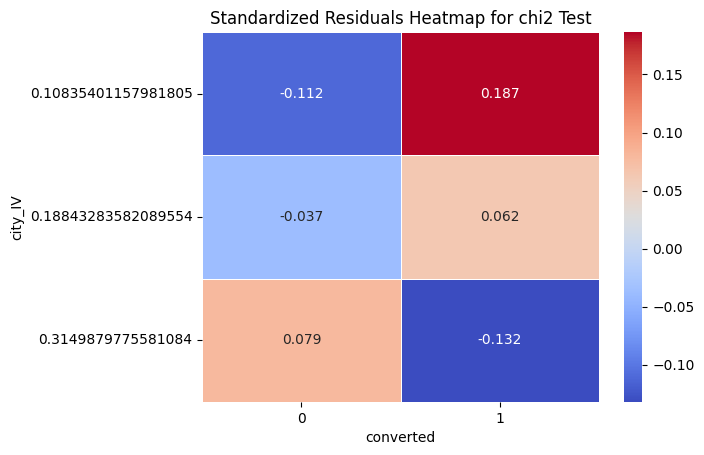

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.0895
	- There is a very weak association between city_IV and converted
******************************************************************************************************************

4. Thei

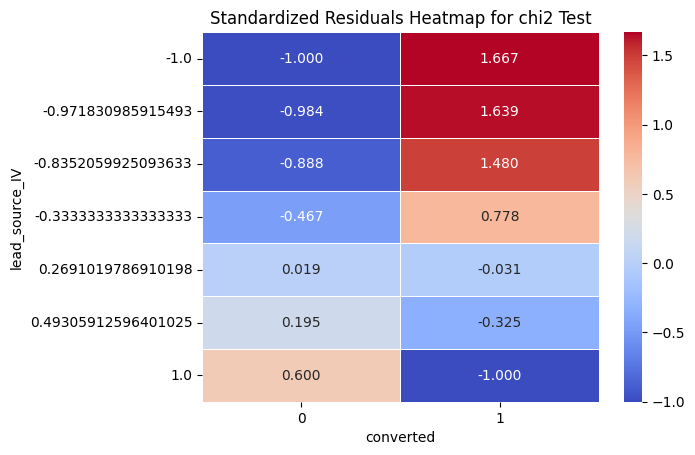

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.314
	- There is a moderately strong association between lead_source_IV and converted
*************************************************************************************************************

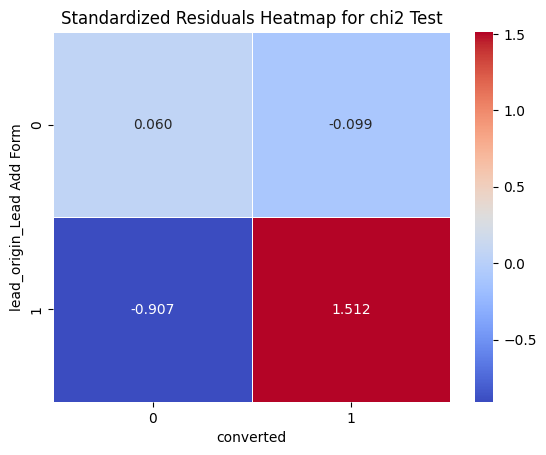

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.299
	- There is a moderate association between lead_origin_Lead Add Form and converted
***********************************************************************************************************

In [237]:
high_vif_features = ['city_IV', 'lead_source_IV', 'lead_origin_Lead Add Form']

for feat in high_vif_features:
    print()
    print(f'Current Feature : {feat}')
    cat_to_cat_association_tests(train_data, feat, 'converted')
    point_biserial_correlation_coefficient(train_data, feat, 'converted')
    print()
    print()
    print('~'*114)
    print('~'*114)
    print('+'*114)
    print('~'*114)
    print('~'*114)
    print()
    print()

##### Observations:
- On detailed Analysis, it can be observed that the feature `city_IV` has the most imbalanced and discrepant distribution
- It also has the lowest values for `Cramers V`, `Theils measure of uncertainity` and `pointwise biserial correlation coefficient`
- It would be wiser to remove this feature first

In [238]:
# Removing the city_IV feature
X_train_sm = X_train_sm.drop(columns = ['city_IV'])
X_train_sm.head(3)

const  a_free_copy_of_mastering_the_interview  totalvisits  \
lead_number                                                               
592372         1.0                                       0          0.0   
604307         1.0                                       0          0.0   
624430         1.0                                       0          2.0   

             total_time_spent_on_website  page_views_per_visit  \
lead_number                                                      
592372                                 0                   0.0   
604307                                 0                   0.0   
624430                              1395                   1.0   

             lead_source_IV  last_activity_IV  specialization_IV  \
lead_number                                                        
592372             0.493059          0.830639           0.426901   
604307            -0.835206          0.285225           0.104037   
624430             0.269102         -0.258288           0.104037   

             last_notable_activity_IV  lead_origin_Landing Page Submission  \
lead_number                                                                  
592372                       0.537430                                    0   
604307                       0.278822                                    0   
624430                      -0.388385                                    0   

             lead_origin_Lead Add Form  lead_origin_Lead Import  
lead_number                                                      
592372                               0                        0  
604307                               1                        0  
624430                               0                        0

In [239]:
# Checking for the vif-scores

# Final vif-scores collater shell
vif_scores = pd.DataFrame()

# The feature set to calculate vif-scores on
feature_set = X_train_sm[X_train_sm.columns.difference(['const'])].drop(columns = [])

# Removing `constant` from the vif calculation
vif_scores['Features'] = feature_set.columns

# VIF-Score calculation
vif_scores['vif_scores'] = [variance_inflation_factor(feature_set.values, i) for i in range(feature_set.shape[1])]
vif_scores['vif_scores'] = round(vif_scores['vif_scores'], 2)
vif_scores = vif_scores.sort_values(by = "vif_scores", ascending = False)
vif_scores

Features  vif_scores
6                           lead_source_IV        9.08
4                lead_origin_Lead Add Form        4.97
8                        specialization_IV        4.57
3      lead_origin_Landing Page Submission        4.23
7                     page_views_per_visit        3.52
1                         last_activity_IV        3.50
2                 last_notable_activity_IV        3.28
0   a_free_copy_of_mastering_the_interview        2.17
9              total_time_spent_on_website        1.99
10                             totalvisits        1.93
5                  lead_origin_Lead Import        1.02

##### Observations:
- Though there is a significant drop in the vif-scores, there still exists a feature with 9+ vif
- There exists a pair of features which theoritically are almost simillar viz : `last_activity_IV` and `last_notable_activity_IV` but before moving any further, we will have to; `needs further speculation`

In [240]:
# Pairwise correlation analysis
pairwise_point_biserial_correlations(X_train_sm.drop(columns = ['const']))

Feature_1  \
38               lead_origin_Lead Add Form   
41                        last_activity_IV   
46     lead_origin_Landing Page Submission   
7   a_free_copy_of_mastering_the_interview   
11                    page_views_per_visit   
31     lead_origin_Landing Page Submission   
5   a_free_copy_of_mastering_the_interview   
29                    page_views_per_visit   
19                    page_views_per_visit   
24     lead_origin_Landing Page Submission   
16     lead_origin_Landing Page Submission   
52     lead_origin_Landing Page Submission   
22                       specialization_IV   
2   a_free_copy_of_mastering_the_interview   
32               lead_origin_Lead Add Form   
34                        last_activity_IV   
14                       specialization_IV   
40                        last_activity_IV   
10             total_time_spent_on_website   
0   a_free_copy_of_mastering_the_interview   
1   a_free_copy_of_mastering_the_interview   
25               lead_origin_Lead Add Form   
21                        last_activity_IV   
23                last_notable_activity_IV   
8   a_free_copy_of_mastering_the_interview   
28                        last_activity_IV   
17               lead_origin_Lead Add Form   
36                last_notable_activity_IV   
35                          lead_source_IV   
43                        last_activity_IV   
42                        last_activity_IV   
45                last_notable_activity_IV   
50                last_notable_activity_IV   
30                last_notable_activity_IV   
49                last_notable_activity_IV   
27                          lead_source_IV   
37     lead_origin_Landing Page Submission   
4   a_free_copy_of_mastering_the_interview   
33                 lead_origin_Lead Import   
53     lead_origin_Landing Page Submission   
12                          lead_source_IV   
13                        last_activity_IV   
20                          lead_source_IV   
26                 lead_origin_Lead Import   
3   a_free_copy_of_mastering_the_interview   
39                 lead_origin_Lead Import   
6   a_free_copy_of_mastering_the_interview   
15                last_notable_activity_IV   
9   a_free_copy_of_mastering_the_interview   
18                 lead_origin_Lead Import   
48                 lead_origin_Lead Import   
47               lead_origin_Lead Add Form   
51                last_notable_activity_IV   
54               lead_origin_Lead Add Form   
44                        last_activity_IV   

                              Feature_2  \
38                       lead_source_IV   
41             last_notable_activity_IV   
46                    specialization_IV   
7   lead_origin_Landing Page Submission   
11                          totalvisits   
31                 page_views_per_visit   
5                     specialization_IV   
29                    specialization_IV   
19          total_time_spent_on_website   
24          total_time_spent_on_website   
16                          totalvisits   
52            lead_origin_Lead Add Form   
22          total_time_spent_on_website   
2                  page_views_per_visit   
32                 page_views_per_visit   
34                       lead_source_IV   
14                          totalvisits   
40                    specialization_IV   
10                          totalvisits   
0                           totalvisits   
1           total_time_spent_on_website   
25          total_time_spent_on_website   
21          total_time_spent_on_website   
23          total_time_spent_on_website   
8             lead_origin_Lead Add Form   
28                 page_views_per_visit   
17                          totalvisits   
36                       lead_source_IV   
35                    specialization_IV   
43            lead_origin_Lead Add Form   
42  lead_origin_Landing Page Submission   
45                    specialization_IV   
50            lead_origin_Lead Add Fo

##### Observation:
- As suspected the features `last_activity_IV` and `last_notable_activity_IV` are highly correlated to each other
- It would be wise to identify the better feature and get rid of the other before moving forward


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 1.1279e-239
- The chi2 discrepancy is : 1124.3
	- We can reject the Null Hypothesis
	- The features last_activity_IV and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


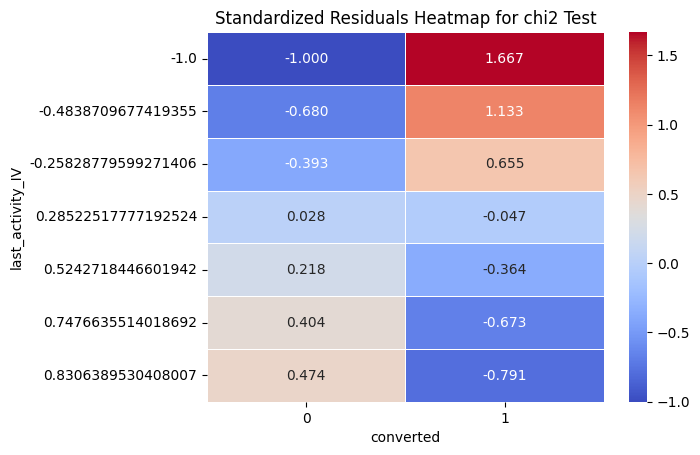

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.394
	- There is a moderately strong association between last_activity_IV and converted
***********************************************************************************************************

-0.39343151839260254

In [241]:
# last_activity_IV
cat_to_cat_association_tests(train_data, 'last_activity_IV', 'converted')
point_biserial_correlation_coefficient(train_data, 'last_activity_IV', 'converted')


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 5.7631e-242
- The chi2 discrepancy is : 1129.4
	- We can reject the Null Hypothesis
	- The features last_notable_activity_IV and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


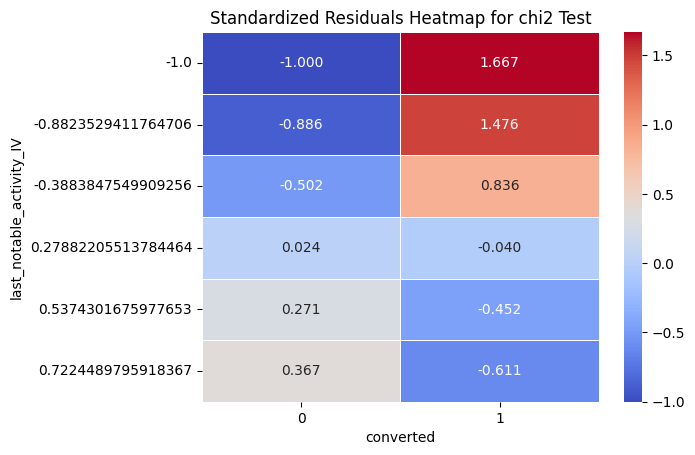

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.394
	- There is a moderately strong association between last_notable_activity_IV and converted
***************************************************************************************************

-0.39388300538425397

In [242]:
# last_notable_activity_IV
cat_to_cat_association_tests(train_data, 'last_notable_activity_IV', 'converted')

point_biserial_correlation_coefficient(train_data, 'last_notable_activity_IV', 'converted')

##### Observations:
- Both the features are the same in terms of correlation
- The feature `last_notable_activity_IV` is slightly better in terms of the frequency distribution in the positive label
- We will choose to have the `last_notable_activity_IV` and drop the other

In [243]:
# Dropping last_activity_IV
X_train_sm = X_train_sm.drop(columns = ['last_activity_IV'])
X_train_sm.head(3)

const  a_free_copy_of_mastering_the_interview  totalvisits  \
lead_number                                                               
592372         1.0                                       0          0.0   
604307         1.0                                       0          0.0   
624430         1.0                                       0          2.0   

             total_time_spent_on_website  page_views_per_visit  \
lead_number                                                      
592372                                 0                   0.0   
604307                                 0                   0.0   
624430                              1395                   1.0   

             lead_source_IV  specialization_IV  last_notable_activity_IV  \
lead_number                                                                
592372             0.493059           0.426901                  0.537430   
604307            -0.835206           0.104037                  0.278822   
624430             0.269102           0.104037                 -0.388385   

             lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
lead_number                                                                   
592372                                         0                          0   
604307                                         0                          1   
624430                                         0                          0   

             lead_origin_Lead Import  
lead_number                           
592372                             0  
604307                             0  
624430                             0

In [244]:
# Checking for the vif-scores

# Final vif-scores collater shell
vif_scores = pd.DataFrame()

# The feature set to calculate vif-scores on
feature_set = X_train_sm[X_train_sm.columns.difference(['const'])].drop(columns = [])

# Removing `constant` from the vif calculation
vif_scores['Features'] = feature_set.columns

# VIF-Score calculation
vif_scores['vif_scores'] = [variance_inflation_factor(feature_set.values, i) for i in range(feature_set.shape[1])]
vif_scores['vif_scores'] = round(vif_scores['vif_scores'], 2)
vif_scores = vif_scores.sort_values(by = "vif_scores", ascending = False)
vif_scores

Features  vif_scores
5                          lead_source_IV        8.96
3               lead_origin_Lead Add Form        4.95
7                       specialization_IV        4.54
2     lead_origin_Landing Page Submission        4.23
6                    page_views_per_visit        3.49
0  a_free_copy_of_mastering_the_interview        2.17
8             total_time_spent_on_website        1.99
9                             totalvisits        1.93
1                last_notable_activity_IV        1.45
4                 lead_origin_Lead Import        1.02

##### Observations:
- Altough there is a higher vif-score for `lead_source_IV`, lead_source_IV seems to be a great predictor as per the metrics, we will try to retain the same
- `specialization_IV` is considerably much weaker of a predictor by nature and it still has a high pairwise correlation
- we will try to analyze and then remove `specialization_IV` if it helps in improving the vif-scores


******************************************************************************************************************
1. Chi2 Test.
- The p-value calculated is : 1.5241e-48
- The chi2 discrepancy is : 229.71
	- We can reject the Null Hypothesis
	- The features specialization_IV and converted are not independent of each other.
******************************************************************************************************************

2. Understanding the chi2 discrepancies distribution.


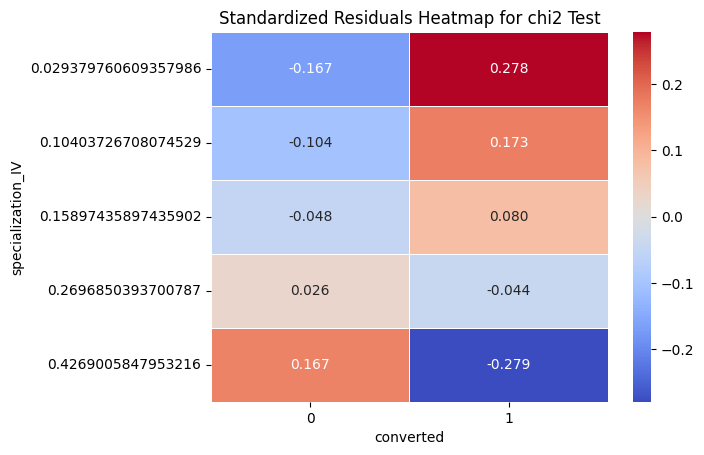

	- Warmer Colors (Positive Residuals): Cells with warmer colors indicate that the observed frequency is higher than expected. Positive residuals suggest that there is an excess of observations in those cells.
	- Cooler Colors (Negative Residuals): Cells with cooler colors indicate that the observed frequency is lower than expected. Negative residuals suggest a deficiency of observations in those cells.
	- If the standardized residuals are small across all cells, it supports the conclusion from the chi-square test that the observed and expected frequencies are similar, indicating independence between the variables.
******************************************************************************************************************

3. Cramers V measure of association.
- The cramers v measure is : 0.178
	- There is a moderate association between specialization_IV and converted
******************************************************************************************************************


-0.17783104624924215

In [245]:
# last_notable_activity_IV
cat_to_cat_association_tests(train_data, 'specialization_IV', 'converted')

point_biserial_correlation_coefficient(train_data, 'specialization_IV', 'converted')

In [246]:
# Dropping last_activity_IV
X_train_sm = X_train_sm.drop(columns = ['specialization_IV'])
X_train_sm.head(3)

const  a_free_copy_of_mastering_the_interview  totalvisits  \
lead_number                                                               
592372         1.0                                       0          0.0   
604307         1.0                                       0          0.0   
624430         1.0                                       0          2.0   

             total_time_spent_on_website  page_views_per_visit  \
lead_number                                                      
592372                                 0                   0.0   
604307                                 0                   0.0   
624430                              1395                   1.0   

             lead_source_IV  last_notable_activity_IV  \
lead_number                                             
592372             0.493059                  0.537430   
604307            -0.835206                  0.278822   
624430             0.269102                 -0.388385   

             lead_origin_Landing Page Submission  lead_origin_Lead Add Form  \
lead_number                                                                   
592372                                         0                          0   
604307                                         0                          1   
624430                                         0                          0   

             lead_origin_Lead Import  
lead_number                           
592372                             0  
604307                             0  
624430                             0

In [247]:
# Checking for the vif-scores

# Final vif-scores collater shell
vif_scores = pd.DataFrame()

# The feature set to calculate vif-scores on
feature_set = X_train_sm[X_train_sm.columns.difference(['const'])].drop(columns = [])

# Removing `constant` from the vif calculation
vif_scores['Features'] = feature_set.columns

# VIF-Score calculation
vif_scores['vif_scores'] = [variance_inflation_factor(feature_set.values, i) for i in range(feature_set.shape[1])]
vif_scores['vif_scores'] = round(vif_scores['vif_scores'], 2)
vif_scores = vif_scores.sort_values(by = "vif_scores", ascending = False)
vif_scores

Features  vif_scores
2     lead_origin_Landing Page Submission        3.75
6                    page_views_per_visit        3.44
5                          lead_source_IV        3.36
0  a_free_copy_of_mastering_the_interview        2.16
3               lead_origin_Lead Add Form        2.08
7             total_time_spent_on_website        1.98
8                             totalvisits        1.93
1                last_notable_activity_IV        1.44
4                 lead_origin_Lead Import        1.01

##### Observations:
- The vif scores has been improvised significantly
- We can now move to building the final model

### 5.1.4 Iteration - III

In [248]:
# Final features

final_feature_set = X_train_sm.columns

# Adding constant to the testing features dataset
X_test_sm = sm.add_constant(X_test)
# Fetching the same subset of features as that of the training feature set
X_test_sm = X_test_sm[final_feature_set]

X_train_sm.shape, X_test_sm.shape

((7259, 10), (1815, 10))

In [249]:
# Model Building
# Logistic Regression model
log_reg_sm = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
# Training the model
results = log_reg_sm.fit()

# Visualizing the summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 7259
Model:                            GLM   Df Residuals:                     7249
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3320.4
Date:                Tue, 28 Nov 2023   Deviance:                       6640.9
Time:                        17:26:08   Pearson chi2:                 7.78e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3352
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -1.8568      0.199     -9.349      0.000      -2.246      -1.468
a_free_copy_of_mastering_the_interview    -0.1720      0.078     -2.208      0.027      -0.325      -0.019
totalvisits                                0.0236      0.009      2.720      0.007       0.007       0.041
total_time_spent_on_website                0.0020   6.46e-05     31.161      0.000       0.002       0.002
page_views_per_visit                      -0.0435      0.020     -2.186      0.029      -0.083      -0.005
lead_source_IV                             2.3224      0.454      5.112      0.000       1.432       3.213
last_notable_activity_IV                  -2.2972      0.084    -27.193      0.000      -2.463      -2.132
lead_origin_Landing Page Submission       -0.2265      0.089     -2.542      0.011      -0.401      -0.052
lead_origin_Lead Add Form                  7.0131      0.622     11.267      0.000       5.793       8.233
lead_origin_Lead Import                    0.6386      0.469      1.362      0.173      -0.281       1.558
==========================================================================================================
"""

##### Observations:
- As expected, the `lead_origin_Lead Import` feature has a high p-value
- We will move forward with this feature set to build the final model

### 5.1.5 Finalising the Model

##### Note:
- For our use case, having a high recall is crucial as `we dont want to miss any potential convertibles and we can bear the expense on FALSE POSITIVES` so we will be more concerned about optimizing the recall rather than any other metric

In [250]:
# Removing the `constant` feature added for statsmodels model
X_train = X_train_sm.drop(columns = ['const'])
X_test = X_test_sm.drop(columns = ['const'])

# Logistic Regression Base Model ----> SkLearn
log_reg = LogisticRegression()

# Training the model
log_reg.fit(X_train, y_train)

LogisticRegression()

In [251]:
# Training data predictions and Evaluation
print('Training Performance...')
acc, recall, f1 = evaluate_model(log_reg, X_train, y_train)

Training Performance...
The accuracy score is : 0.77
The recall score is : 0.61
The f1-score is : 0.67


In [252]:
# testing data predictions and Evaluation
print('testing Performance...')
acc, recall, f1 = evaluate_model(log_reg, X_test, y_test)

testing Performance...
The accuracy score is : 0.77
The recall score is : 0.62
The f1-score is : 0.69


#### 5.1.5.1 Tuning the model

Best Hyperparameters: {'C': 0.7, 'class_weight': 'balanced', 'dual': False, 'penalty': 'l1', 'solver': 'liblinear'}

Training model evaluation...
The accuracy score is : 0.79
The recall score is : 0.77
The f1-score is : 0.73


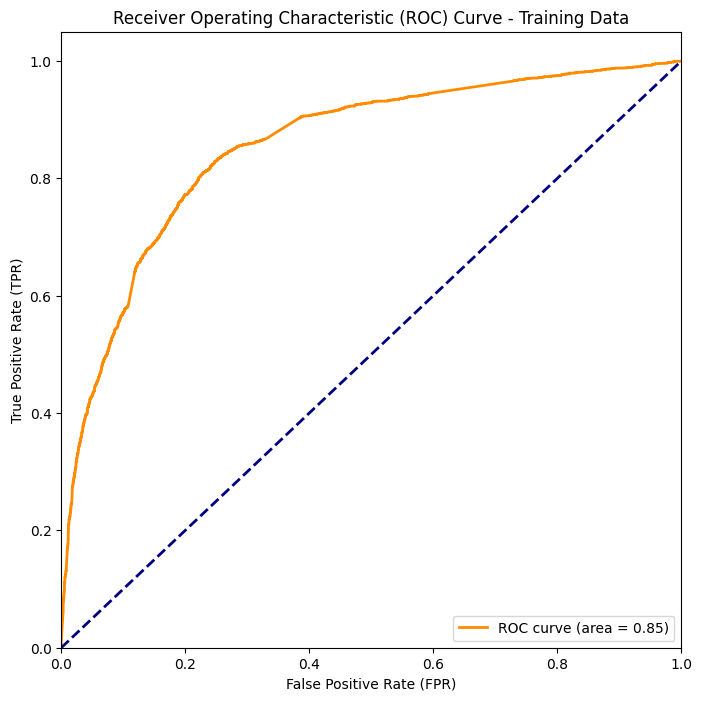


testing model evaluation...
The accuracy score is : 0.79
The recall score is : 0.79
The f1-score is : 0.75


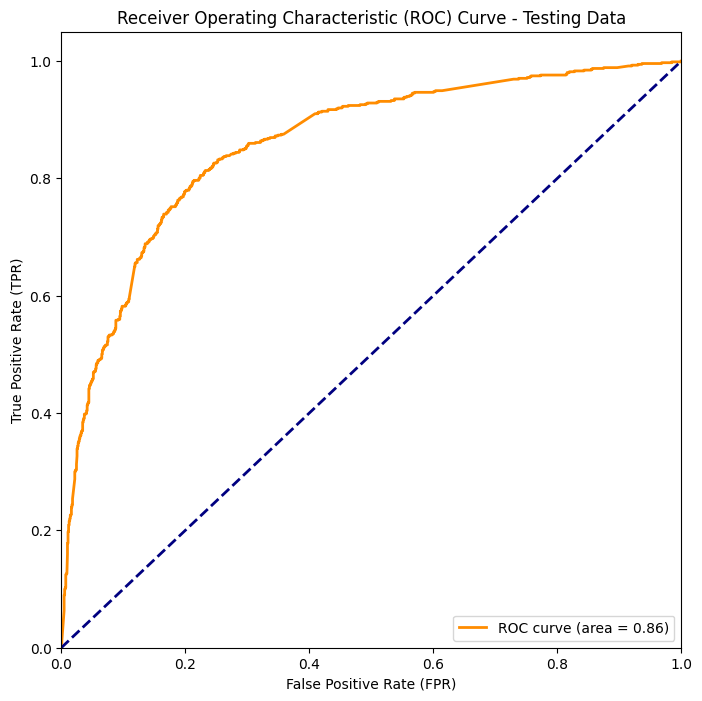

0.8563812321343574

In [253]:
# F1-Score

# parameter grid for hyperparameter tuning of logistic regression
parameter_grid = {'penalty':['l1', 'l2', 'elasticnet', None], 
               'dual':[True, False], 
               'C':[0.3,0.5,0.7], 
               'class_weight':[None, 'balanced'], 
               'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

# Logistic regression model
logistic_regression = LogisticRegression(n_jobs = -1, max_iter = 500, warm_start = True)

# Initialize Cross-Validator
grid_search = GridSearchCV(logistic_regression, parameter_grid, cv=5, scoring='f1')

# Fit the Cross-Validator to the data
grid_search.fit(X_train, y_train)

# Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

print()
print('Training model evaluation...')
evaluate_model(best_model, X_train, y_train)
# Plotting ROC
draw_ROC(best_model, X_train, y_train, True)

print()
print('testing model evaluation...')
evaluate_model(best_model, X_test, y_test)
# Plotting ROC
draw_ROC(best_model, X_test, y_test, False)

Best Hyperparameters: {'C': 0.3, 'class_weight': 'balanced', 'dual': False, 'penalty': 'l2', 'solver': 'lbfgs'}

Training model evaluation...
The accuracy score is : 0.79
The recall score is : 0.78
The f1-score is : 0.73


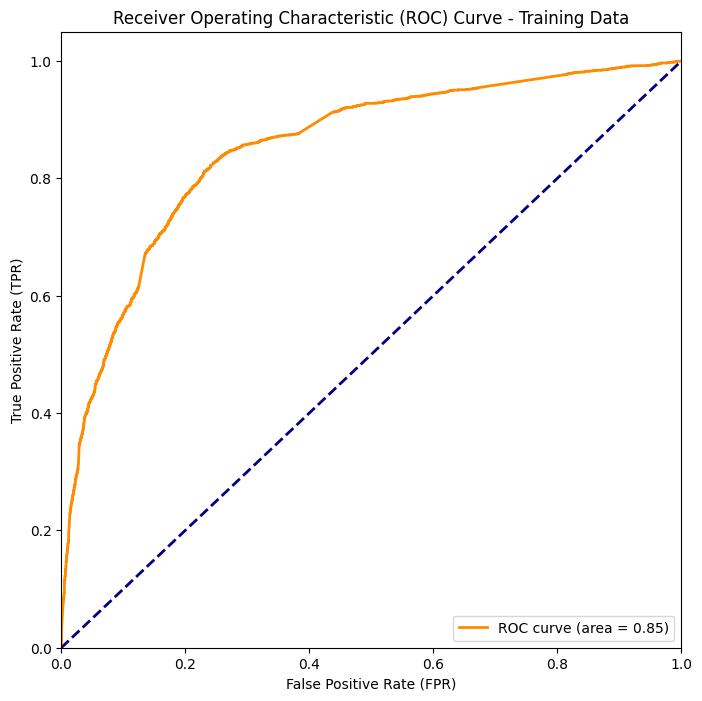


testing model evaluation...
The accuracy score is : 0.79
The recall score is : 0.78
The f1-score is : 0.74


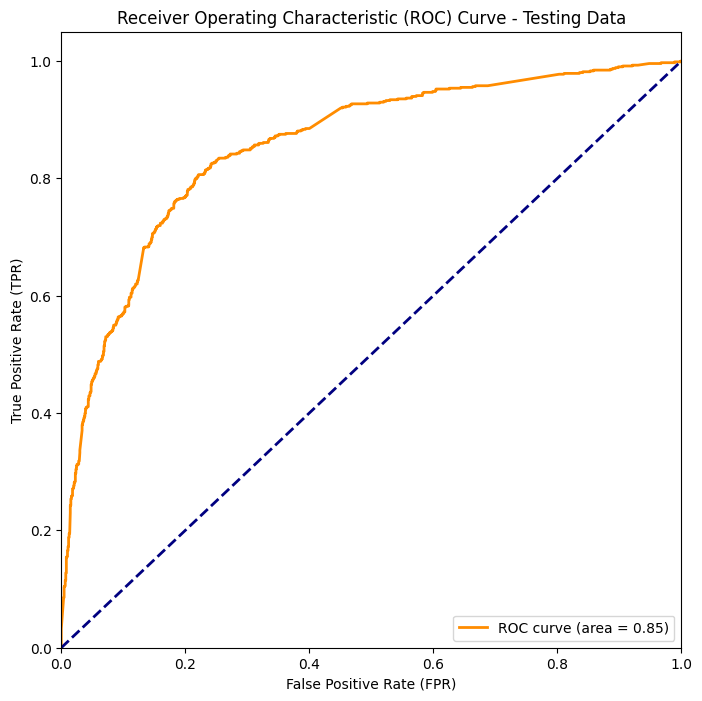

0.8537950888732206

In [254]:
# Recall

# parameter grid for hyperparameter tuning of logistic regression
parameter_grid = {'penalty':['l1', 'l2', 'elasticnet', None], 
               'dual':[True, False], 
               'C':[0.3,0.5,0.7], 
               'class_weight':[None, 'balanced'], 
               'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

# Logistic regression model
logistic_regression = LogisticRegression(n_jobs = -1, max_iter = 500, warm_start = True)

# Initialize Cross-Validator
grid_search = GridSearchCV(logistic_regression, parameter_grid, cv=5, scoring='recall')

# Fit the Cross-Validator to the data
grid_search.fit(X_train, y_train)

# Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

print()
print('Training model evaluation...')
evaluate_model(best_model, X_train, y_train)
# Plotting ROC
draw_ROC(best_model, X_train, y_train, True)

print()
print('testing model evaluation...')
evaluate_model(best_model, X_test, y_test)
# Plotting ROC
draw_ROC(best_model, X_test, y_test, False)

##### Observations:
- The model is highly consistent by nature but there still exists some scope of improvement by balancing the label

#### 5.1.5.2 OverSampling

###### 5.1.5.2.1 SMOTE-ENN

In [255]:
# Performing oversampling on the training data
# SMOTE-ENN because it would oversample using SMOTE but also remove very noisy data using ENN

#------------------------------------------------------OverSampling
# Initialization
smote_enn = SMOTEENN(random_state=RANDOM_SEED)
# Resampling
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

Best Hyperparameters: {'C': 0.3, 'class_weight': None, 'dual': False, 'penalty': 'l2', 'solver': 'liblinear'}

Training model evaluation...
The accuracy score is : 0.96
The recall score is : 0.95
The f1-score is : 0.96


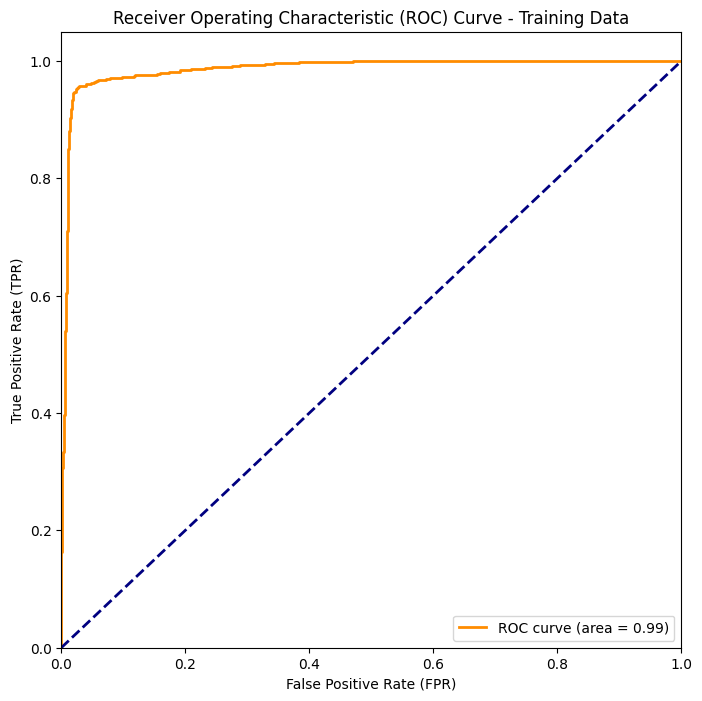


testing model evaluation...
The accuracy score is : 0.78
The recall score is : 0.73
The f1-score is : 0.73


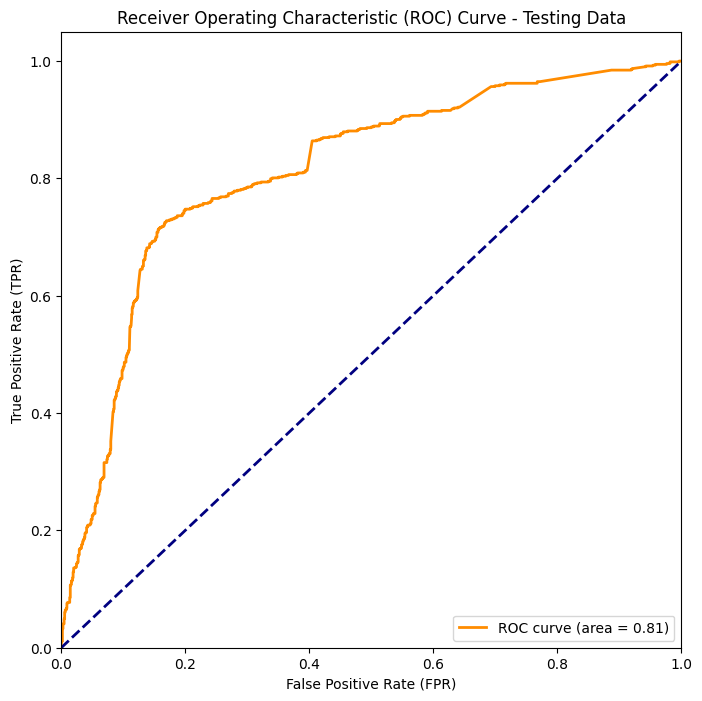

0.8111377248557384

In [256]:
# F1-Score
#------------------------------------------------------Model Tuning
# parameter grid for hyperparameter tuning of logistic regression
parameter_grid = {'penalty':['l1', 'l2', 'elasticnet', None], 
               'dual':[True, False], 
               'C':[0.3,0.5,0.7], 
               'class_weight':[None, 'balanced'], 
               'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

# Logistic regression model
logistic_regression = LogisticRegression(n_jobs = -1, max_iter = 500, warm_start = True)

# Initialize Cross-Validator
grid_search = GridSearchCV(logistic_regression, parameter_grid, cv=5, scoring='f1')

# Fit the Cross-Validator to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

print()
print('Training model evaluation...')
evaluate_model(best_model, X_train_resampled, y_train_resampled)
# Plotting ROC
draw_ROC(best_model, X_train_resampled, y_train_resampled, True)

print()
print('testing model evaluation...')
evaluate_model(best_model, X_test, y_test)
# Plotting ROC
draw_ROC(best_model, X_test, y_test, False)

###### Observation:
- The model is clearly overfitted

Best Hyperparameters: {'C': 0.3, 'class_weight': 'balanced', 'dual': False, 'penalty': 'l2', 'solver': 'liblinear'}

Training model evaluation...
The accuracy score is : 0.97
The recall score is : 0.96
The f1-score is : 0.96


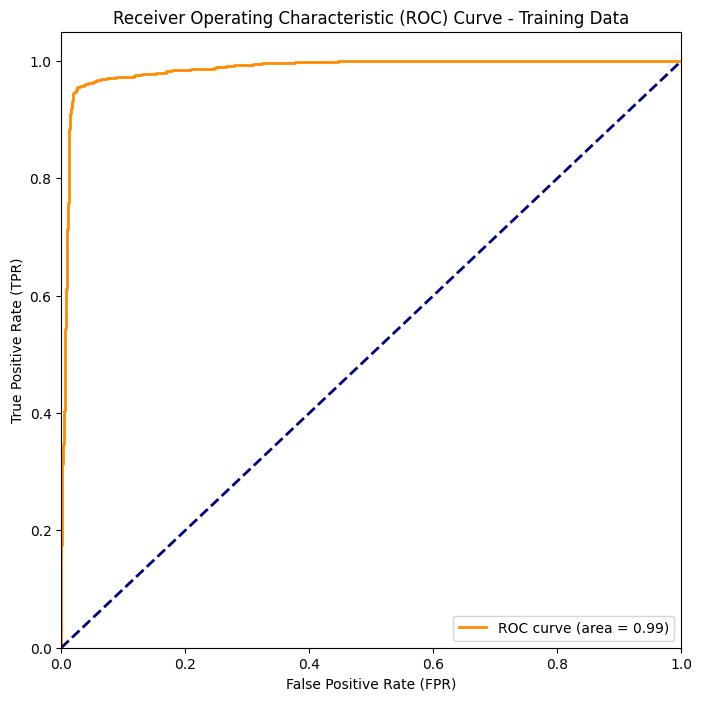


testing model evaluation...
The accuracy score is : 0.78
The recall score is : 0.74
The f1-score is : 0.72


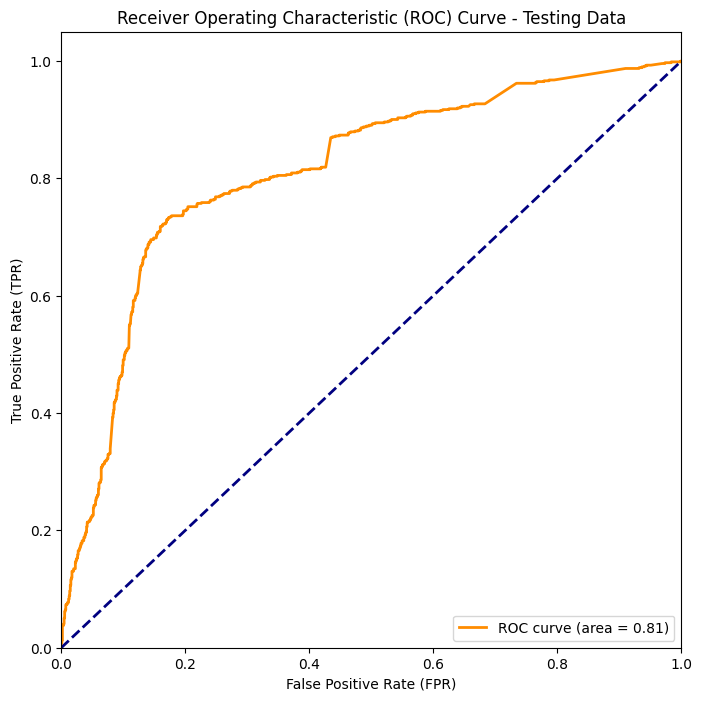

0.8099566515553767

In [257]:
# Recall
#------------------------------------------------------Model Tuning
# parameter grid for hyperparameter tuning of logistic regression
parameter_grid = {'penalty':['l1', 'l2', 'elasticnet', None], 
               'dual':[True, False], 
               'C':[0.3,0.5,0.7], 
               'class_weight':[None, 'balanced'], 
               'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

# Logistic regression model
logistic_regression = LogisticRegression(n_jobs = -1, max_iter = 500, warm_start = True)

# Initialize Cross-Validator
grid_search = GridSearchCV(logistic_regression, parameter_grid, cv=5, scoring='recall')

# Fit the Cross-Validator to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

print()
print('Training model evaluation...')
evaluate_model(best_model, X_train_resampled, y_train_resampled)
# Plotting ROC
draw_ROC(best_model, X_train_resampled, y_train_resampled, True)

print()
print('testing model evaluation...')
evaluate_model(best_model, X_test, y_test)
# Plotting ROC
draw_ROC(best_model, X_test, y_test, False)

###### Observations:
- Improved but still overfitted

###### 5.1.5.2.2 ADASYN

In [258]:
# Performing oversampling on the training data
# ADASYN because it would try to replicate the real data along with the variances as well

#------------------------------------------------------OverSampling
# Initialization
adasyn = ADASYN(random_state=RANDOM_SEED)
# Resampling
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

Best Hyperparameters: {'C': 0.7, 'class_weight': None, 'dual': True, 'penalty': 'l2', 'solver': 'liblinear'}

Training model evaluation...
The accuracy score is : 0.57
The recall score is : 0.16
The f1-score is : 0.27


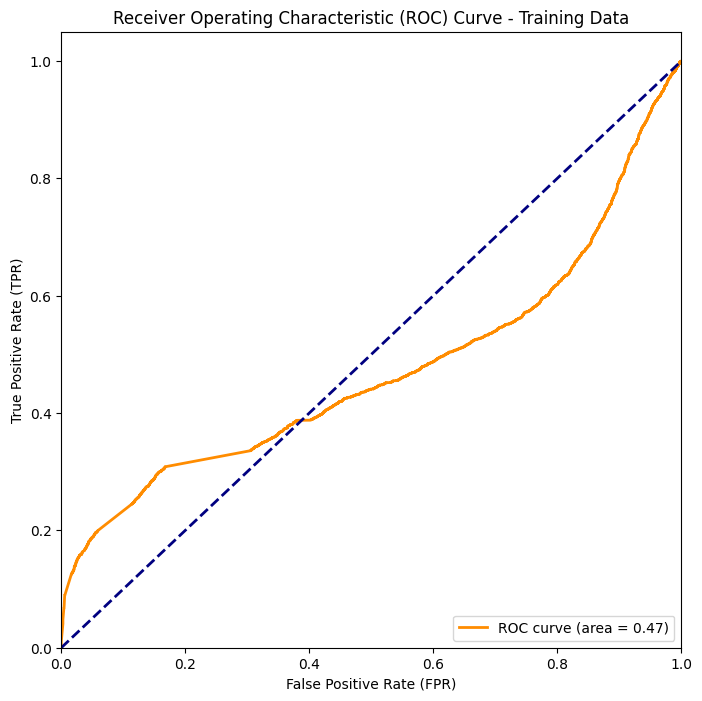


testing model evaluation...
The accuracy score is : 0.68
The recall score is : 0.23
The f1-score is : 0.36


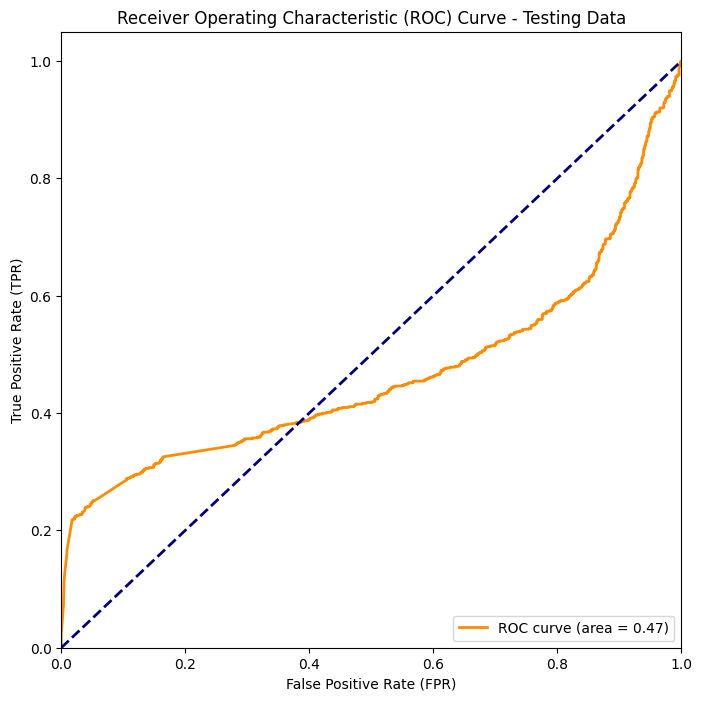

0.46569542054100277

In [259]:
# F1-Score
#------------------------------------------------------Model Tuning
# parameter grid for hyperparameter tuning of logistic regression
parameter_grid = {'penalty':['l1', 'l2', 'elasticnet', None], 
               'dual':[True, False], 
               'C':[0.3,0.5,0.7], 
               'class_weight':[None, 'balanced'], 
               'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

# Logistic regression model
logistic_regression = LogisticRegression(n_jobs = -1, max_iter = 500, warm_start = True)

# Initialize Cross-Validator
grid_search = GridSearchCV(logistic_regression, parameter_grid, cv=5, scoring='f1')

# Fit the Cross-Validator to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

print()
print('Training model evaluation...')
evaluate_model(best_model, X_train_resampled, y_train_resampled)
# Plotting ROC
draw_ROC(best_model, X_train_resampled, y_train_resampled, True)

print()
print('testing model evaluation...')
evaluate_model(best_model, X_test, y_test)
# Plotting ROC
draw_ROC(best_model, X_test, y_test, False)

###### Observation:
- The Overall Model Looks Good and it does not overfits as well

Best Hyperparameters: {'C': 0.7, 'class_weight': 'balanced', 'dual': True, 'penalty': 'l2', 'solver': 'liblinear'}

Training model evaluation...
The accuracy score is : 0.74
The recall score is : 0.82
The f1-score is : 0.76


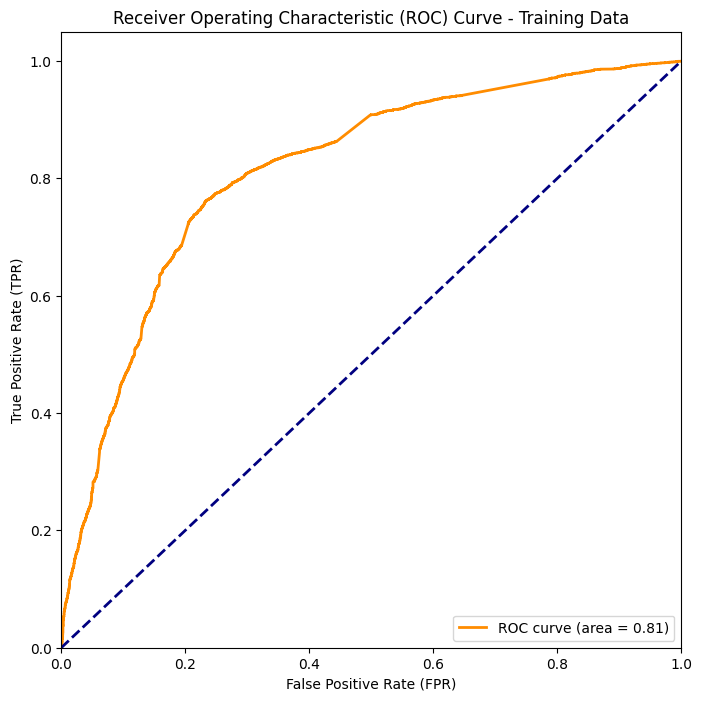


testing model evaluation...
The accuracy score is : 0.73
The recall score is : 0.86
The f1-score is : 0.71


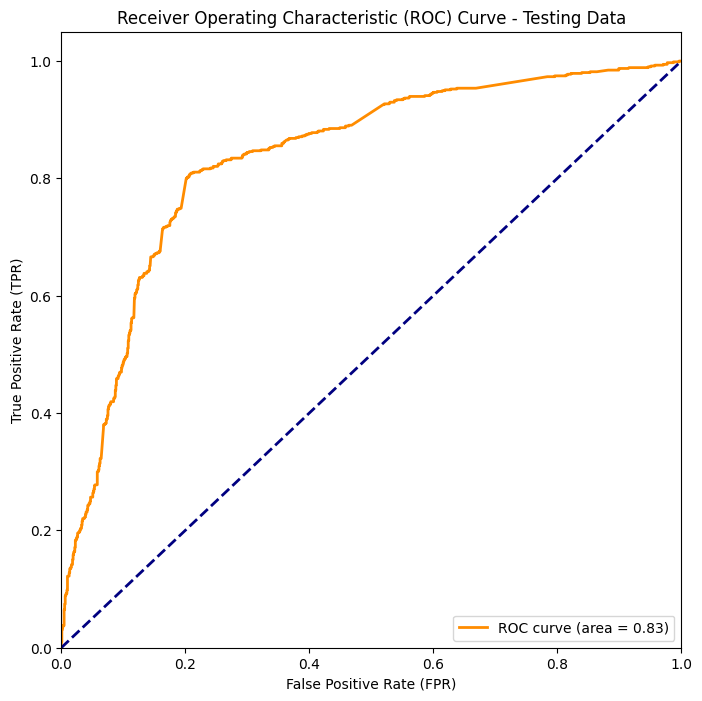

0.8330792159098718

In [260]:
# Recall
#------------------------------------------------------Model Tuning
# parameter grid for hyperparameter tuning of logistic regression
parameter_grid = {'penalty':['l1', 'l2', 'elasticnet', None], 
               'dual':[True, False], 
               'C':[0.3,0.5,0.7], 
               'class_weight':[None, 'balanced'], 
               'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

# Logistic regression model
logistic_regression = LogisticRegression(n_jobs = -1, max_iter = 500, warm_start = True)

# Initialize Cross-Validator
grid_search = GridSearchCV(logistic_regression, parameter_grid, cv=5, scoring='recall')

# Fit the Cross-Validator to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

print()
print('Training model evaluation...')
evaluate_model(best_model, X_train_resampled, y_train_resampled)
# Plotting ROC
draw_ROC(best_model, X_train_resampled, y_train_resampled, True)

print()
print('testing model evaluation...')
evaluate_model(best_model, X_test, y_test)
# Plotting ROC
draw_ROC(best_model, X_test, y_test, False)

###### Observation:
- Low accuracy, high recall

##### 5.1.5.2.2 SMOTE

In [261]:
# Performing oversampling on the training data

#------------------------------------------------------OverSampling
# Initialization
smote = SMOTE(random_state=RANDOM_SEED)
# Resampling
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Best Hyperparameters: {'C': 0.3, 'class_weight': None, 'dual': False, 'penalty': 'l2', 'solver': 'newton-cg'}

Training model evaluation...
The accuracy score is : 0.79
The recall score is : 0.78
The f1-score is : 0.79


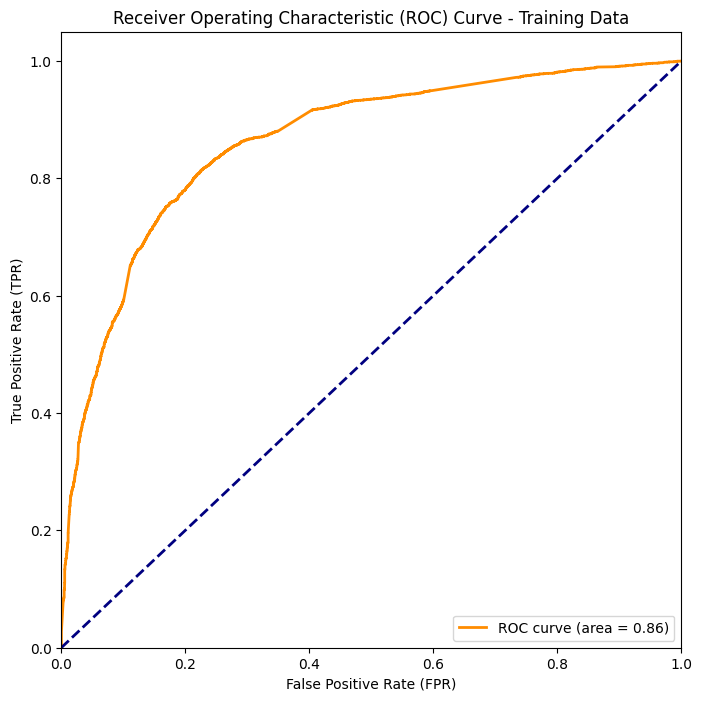


testing model evaluation...
The accuracy score is : 0.79
The recall score is : 0.76
The f1-score is : 0.74


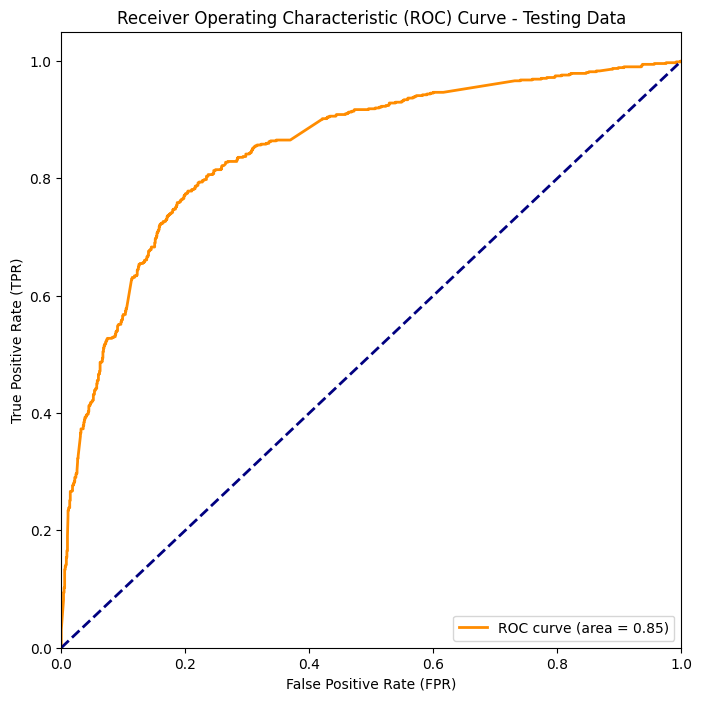

0.8497364221115249

In [262]:
# F1-Score
#------------------------------------------------------Model Tuning
# parameter grid for hyperparameter tuning of logistic regression
parameter_grid = {'penalty':['l1', 'l2', 'elasticnet', None], 
               'dual':[True, False], 
               'C':[0.3,0.5,0.7], 
               'class_weight':[None, 'balanced'], 
               'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

# Logistic regression model
logistic_regression = LogisticRegression(n_jobs = -1, max_iter = 500, warm_start = True)

# Initialize Cross-Validator
grid_search = GridSearchCV(logistic_regression, parameter_grid, cv=5, scoring='f1')

# Fit the Cross-Validator to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

print()
print('Training model evaluation...')
evaluate_model(best_model, X_train_resampled, y_train_resampled)
# Plotting ROC
draw_ROC(best_model, X_train_resampled, y_train_resampled, True)

print()
print('testing model evaluation...')
evaluate_model(best_model, X_test, y_test)
# Plotting ROC
draw_ROC(best_model, X_test, y_test, False)

##### Observation:
- Balanced Model

Best Hyperparameters: {'C': 0.3, 'class_weight': 'balanced', 'dual': True, 'penalty': 'l2', 'solver': 'liblinear'}

Training model evaluation...
The accuracy score is : 0.78
The recall score is : 0.86
The f1-score is : 0.79


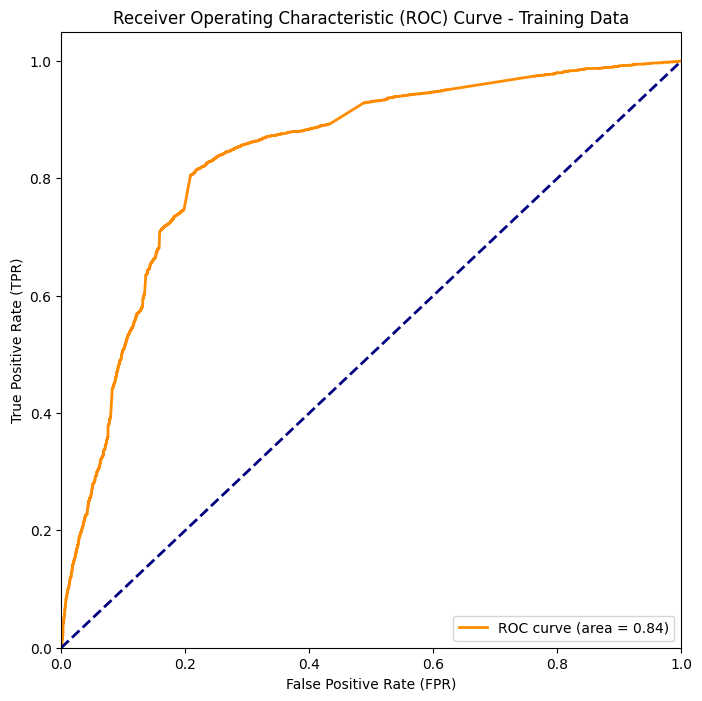


testing model evaluation...
The accuracy score is : 0.74
The recall score is : 0.86
The f1-score is : 0.72


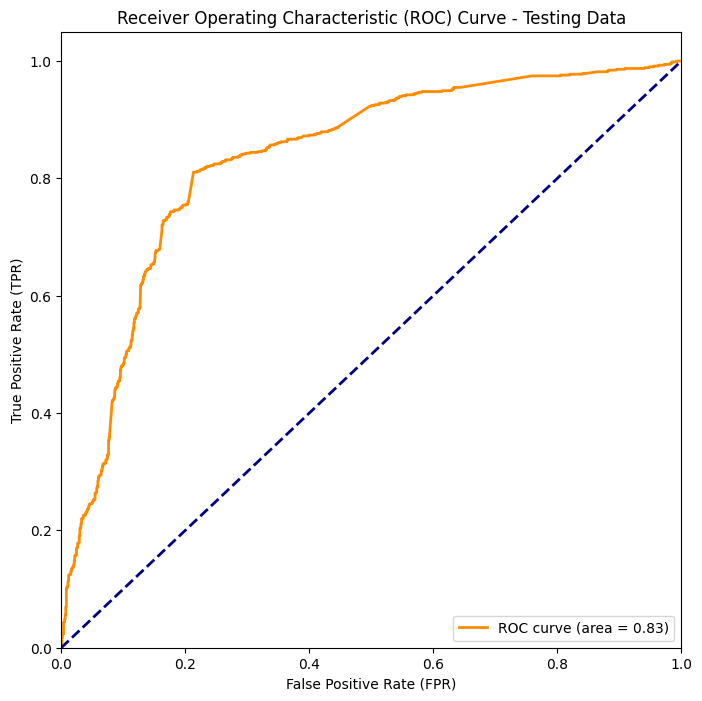

0.8321641386437512

In [263]:
# Recall
#------------------------------------------------------Model Tuning
# parameter grid for hyperparameter tuning of logistic regression
parameter_grid = {'penalty':['l1', 'l2', 'elasticnet', None], 
               'dual':[True, False], 
               'C':[0.3,0.5,0.7], 
               'class_weight':[None, 'balanced'], 
               'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

# Logistic regression model
logistic_regression = LogisticRegression(n_jobs = -1, max_iter = 500, warm_start = True)

# Initialize Cross-Validator
grid_search = GridSearchCV(logistic_regression, parameter_grid, cv=5, scoring='recall')

# Fit the Cross-Validator to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

print()
print('Training model evaluation...')
evaluate_model(best_model, X_train_resampled, y_train_resampled)
# Plotting ROC
draw_ROC(best_model, X_train_resampled, y_train_resampled, True)

print()
print('testing model evaluation...')
evaluate_model(best_model, X_test, y_test)
# Plotting ROC
draw_ROC(best_model, X_test, y_test, False)

##### Observations:
- Balanced Model

##### Note:
- Since our main end goal is to improvise over the recall, we will be moving forward with the same

## 5.2 Final model using SMOTE

### 5.2.1 Non normalized data

In [264]:
# Performing oversampling on the training data

#------------------------------------------------------OverSampling
# Initialization
smote = SMOTE(random_state=RANDOM_SEED)
# Resampling
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Best Hyperparameters: {'C': 0.3, 'class_weight': None, 'dual': False, 'penalty': 'l2', 'solver': 'newton-cg'}

Training model evaluation...
The accuracy score is : 0.79
The recall score is : 0.78
The f1-score is : 0.79


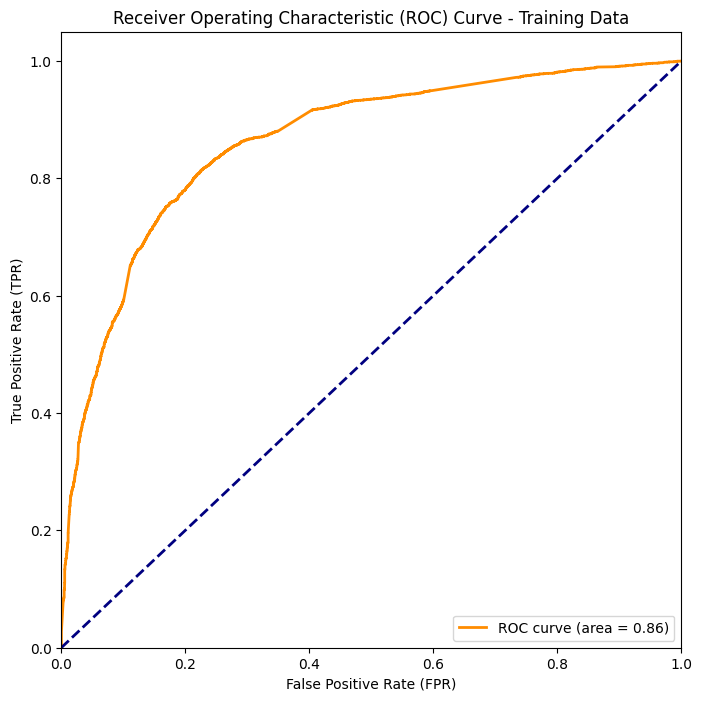


testing model evaluation...
The accuracy score is : 0.79
The recall score is : 0.76
The f1-score is : 0.74


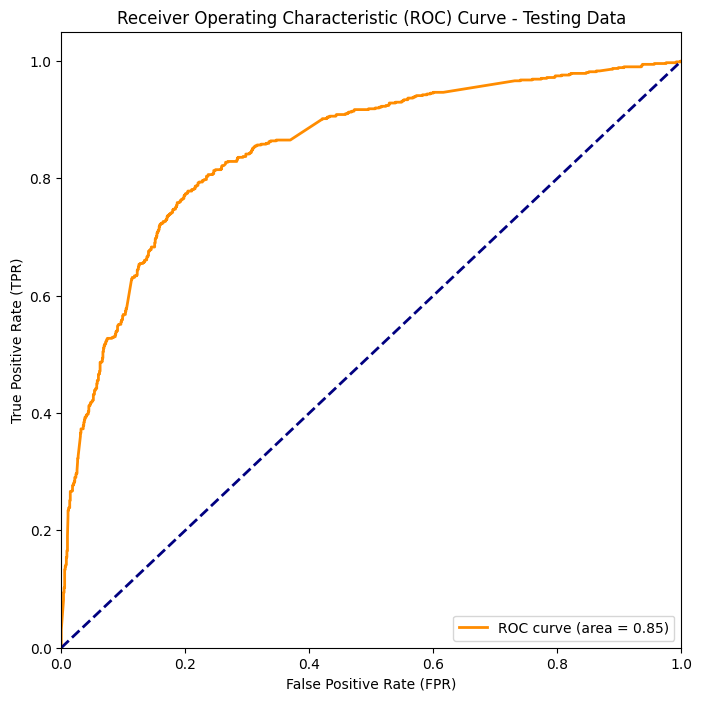

0.8497364221115249

In [265]:
# F1-Score
#------------------------------------------------------Model Tuning
# parameter grid for hyperparameter tuning of logistic regression
parameter_grid = {'penalty':['l1', 'l2', 'elasticnet', None], 
               'dual':[True, False], 
               'C':[0.3,0.5,0.7], 
               'class_weight':[None, 'balanced'], 
               'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

# Logistic regression model
logistic_regression = LogisticRegression(n_jobs = -1, max_iter = 500, warm_start = True)

# Initialize Cross-Validator
grid_search = GridSearchCV(logistic_regression, parameter_grid, cv=5, scoring='f1')

# Fit the Cross-Validator to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

print()
print('Training model evaluation...')
evaluate_model(best_model, X_train_resampled, y_train_resampled)
# Plotting ROC
draw_ROC(best_model, X_train_resampled, y_train_resampled, True)

print()
print('testing model evaluation...')
evaluate_model(best_model, X_test, y_test)
# Plotting ROC
draw_ROC(best_model, X_test, y_test, False)

In [266]:
pd.DataFrame({'Features':X_train_resampled.columns,'Coefficients':best_model.coef_[0]}).sort_values(by = ['Coefficients'], ascending = False, key = lambda x:abs(x))

Features  Coefficients
7               lead_origin_Lead Add Form      2.908783
5                last_notable_activity_IV     -2.456680
6     lead_origin_Landing Page Submission     -0.582265
8                 lead_origin_Lead Import      0.542680
4                          lead_source_IV     -0.539435
0  a_free_copy_of_mastering_the_interview     -0.505126
3                    page_views_per_visit     -0.084789
1                             totalvisits      0.020690
2             total_time_spent_on_website      0.002015

### 5.2.2 Normalizing the data before modelling

In [267]:
# Normalizing the dataset
normalizer = MinMaxScaler()

# Normalising the training data
X_tr_scaled = normalizer.fit_transform(X_train)
# Normalising the testing data
X_ts_scaled = normalizer.transform(X_test)

In [268]:
# Mapping feature names
X_tr_scaled = pd.DataFrame(columns = X_train.columns, data = X_tr_scaled)
X_ts_scaled = pd.DataFrame(columns = X_test.columns, data = X_ts_scaled)

In [269]:
# Performing oversampling on the training data

#------------------------------------------------------OverSampling
# Initialization
smote = SMOTE(random_state=RANDOM_SEED)
# Resampling
X_train_resampled, y_train_resampled = smote.fit_resample(X_tr_scaled, y_train)

Best Hyperparameters: {'C': 0.3, 'class_weight': None, 'dual': True, 'penalty': 'l2', 'solver': 'liblinear'}

Training model evaluation...
The accuracy score is : 0.79
The recall score is : 0.78
The f1-score is : 0.79


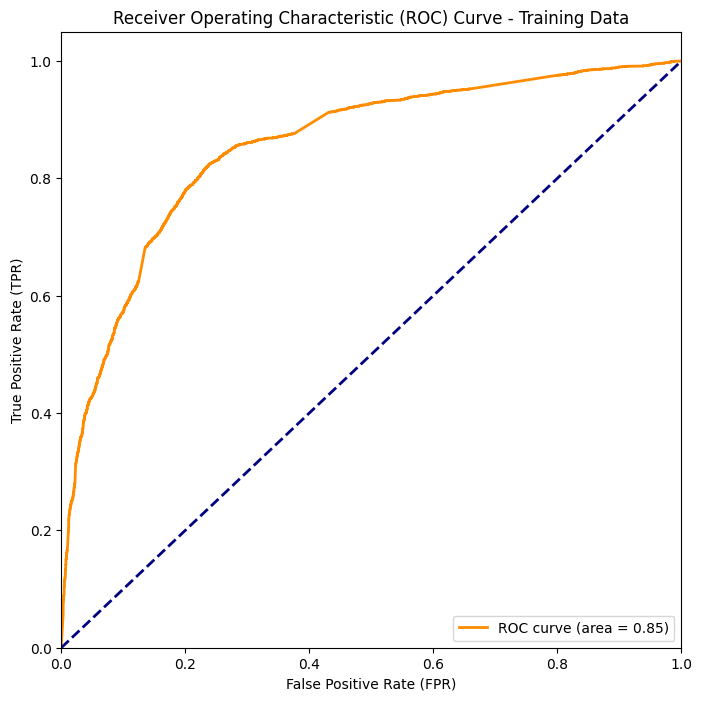


testing model evaluation...
The accuracy score is : 0.79
The recall score is : 0.79
The f1-score is : 0.75


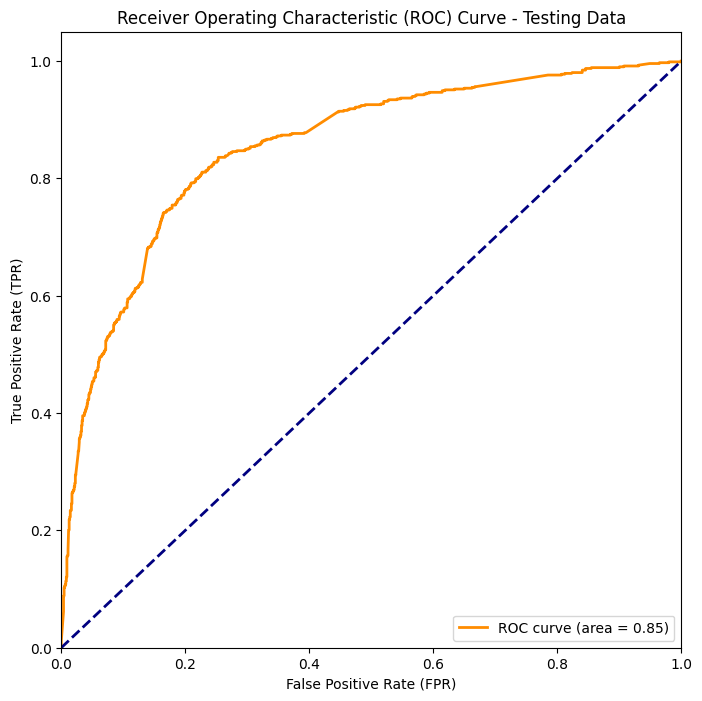

0.8531536438911274

In [270]:
# F1-Score
#------------------------------------------------------Model Tuning
# parameter grid for hyperparameter tuning of logistic regression
parameter_grid = {'penalty':['l1', 'l2', 'elasticnet', None], 
               'dual':[True, False], 
               'C':[0.3,0.5,0.7], 
               'class_weight':[None, 'balanced'], 
               'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

# Logistic regression model
logistic_regression = LogisticRegression(n_jobs = -1, max_iter = 500, warm_start = True)

# Initialize Cross-Validator
grid_search = GridSearchCV(logistic_regression, parameter_grid, cv=5, scoring='f1')

# Fit the Cross-Validator to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


# Evaluate the best model on the test set
best_model_normalized = grid_search.best_estimator_

print()
print('Training model evaluation...')
evaluate_model(best_model_normalized, X_train_resampled, y_train_resampled)
# Plotting ROC
draw_ROC(best_model_normalized, X_train_resampled, y_train_resampled, True)

print()
print('testing model evaluation...')
evaluate_model(best_model_normalized, X_ts_scaled, y_test)
# Plotting ROC
draw_ROC(best_model_normalized, X_ts_scaled, y_test, False)

In [271]:
pd.DataFrame({'Features':X_train_resampled.columns,'Coefficients':best_model.coef_[0]}).sort_values(by = ['Coefficients'], ascending = False, key = lambda x:abs(x))

Features  Coefficients
7               lead_origin_Lead Add Form      2.908783
5                last_notable_activity_IV     -2.456680
6     lead_origin_Landing Page Submission     -0.582265
8                 lead_origin_Lead Import      0.542680
4                          lead_source_IV     -0.539435
0  a_free_copy_of_mastering_the_interview     -0.505126
3                    page_views_per_visit     -0.084789
1                             totalvisits      0.020690
2             total_time_spent_on_website      0.002015

##### Observations:
- The test performance improved in terms of recall after normalizing the data
- This non normalized version can be treated as the final model

### 5.2.3 Model Evaluation

In [272]:
# The finalised model
final_model = best_model_normalized

# New Scaled Features
X_train = X_tr_scaled.copy()
X_test = X_ts_scaled.copy()

In [273]:
# Training data evaluation

# Calculating the prediction probabilities
training_data_prediction_probs = final_model.predict_proba(X_train)[:,1]
# Making predictions
training_data_preditions = final_model.predict(X_train)
# Creating the prediction dataset
training_data_predictions = pd.DataFrame({'lead_number':X_train.index.values, 
                                          'converted':y_train.values.reshape(1,-1)[0], 
                                          'converted_predictions':training_data_preditions, 
                                          'converted_prediction_probabilities':training_data_prediction_probs})
training_data_predictions

lead_number  converted  converted_predictions  \
0               0          0                      0   
1               1          1                      1   
2               2          1                      1   
3               3          0                      1   
4               4          0                      0   
...           ...        ...                    ...   
7254         7254          0                      0   
7255         7255          1                      0   
7256         7256          1                      0   
7257         7257          0                      0   
7258         7258          0                      0   

      converted_prediction_probabilities  
0                               0.174266  
1                               0.928458  
2                               0.952095  
3                               0.620575  
4                               0.265444  
...                                  ...  
7254                            0.174266  
7255                            0.356271  
7256                            0.467334  
7257                            0.226587  
7258                            0.132337  

[7259 rows x 4 columns]

In [274]:
# Cunfusion Matrix
confusion = confusion_matrix(training_data_predictions.converted, training_data_predictions.converted_predictions)

# Extracting the components of the confusion matrix
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print(f'Confusion Matrix : \n{confusion}')
print()
print(f'True Positives : {TP}\nTrue Negatives : {TN}\nFalse Positives : {FP}\nFalse Negatives : {FN}')

Confusion Matrix : 
[[3610  927]
 [ 613 2109]]

True Positives : 2109
True Negatives : 3610
False Positives : 927
False Negatives : 613


In [275]:
# Performance metrics
print(f'Model Training Accuracy           :   {accuracy_score(training_data_predictions.converted, training_data_predictions.converted_predictions):.02}')
print(f'Model Training Recall             :   {recall_score(training_data_predictions.converted, training_data_predictions.converted_predictions):.02}')
print(f'Model Training F-1 Score          :   {f1_score(training_data_predictions.converted, training_data_predictions.converted_predictions):.02}')
print(f'Model Sensitivity                 :   {TP/float(TP+FN):.02}')
print(f'Model Specificity                 :   {TN/float(TN+FP):.02}')
print(f'Model False Positive Rate         :   {FP/float(TN+FP):.02}')
print(f'Model Positive Predictive Value   :   {TP/float(TP+FP):.02}')
print(f'Model Negative Predictive Value   :   {TN/float(TN+FN):.02}')

Model Training Accuracy           :   0.79
Model Training Recall             :   0.77
Model Training F-1 Score          :   0.73
Model Sensitivity                 :   0.77
Model Specificity                 :   0.8
Model False Positive Rate         :   0.2
Model Positive Predictive Value   :   0.69
Model Negative Predictive Value   :   0.85


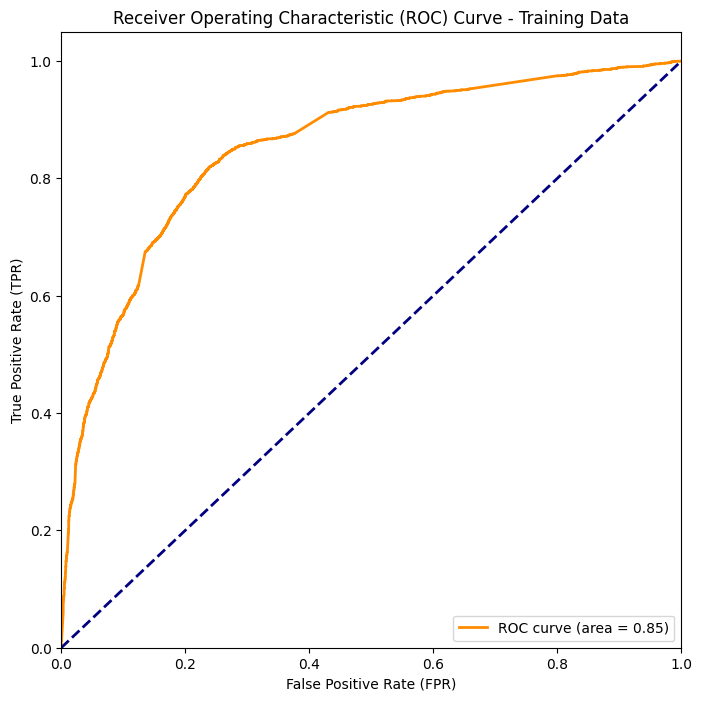

0.8512424255330933

In [276]:
# Plottig the ROC curve
draw_ROC(final_model, X_train, y_train)

In [277]:
probabilities = [float(x)/10 for x in range(10)]
for i in probabilities:
    training_data_predictions[i] = training_data_predictions.converted_prediction_probabilities.map(lambda x: 1 if x > i else 0)
training_data_predictions

lead_number  converted  converted_predictions  \
0               0          0                      0   
1               1          1                      1   
2               2          1                      1   
3               3          0                      1   
4               4          0                      0   
...           ...        ...                    ...   
7254         7254          0                      0   
7255         7255          1                      0   
7256         7256          1                      0   
7257         7257          0                      0   
7258         7258          0                      0   

      converted_prediction_probabilities  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
0                               0.174266    1    1    0    0    0    0    0   
1                               0.928458    1    1    1    1    1    1    1   
2                               0.952095    1    1    1    1    1    1    1   
3                               0.620575    1    1    1    1    1    1    1   
4                               0.265444    1    1    1    0    0    0    0   
...                                  ...  ...  ...  ...  ...  ...  ...  ...   
7254                            0.174266    1    1    0    0    0    0    0   
7255                            0.356271    1    1    1    1    0    0    0   
7256                            0.467334    1    1    1    1    1    0    0   
7257                            0.226587    1    1    1    0    0    0    0   
7258                            0.132337    1    1    0    0    0    0    0   

      0.7  0.8  0.9  
0       0    0    0  
1       1    1    1  
2       1    1    1  
3       0    0    0  
4       0    0    0  
...   ...  ...  ...  
7254    0    0    0  
7255    0    0    0  
7256    0    0    0  
7257    0    0    0  
7258    0    0    0  

[7259 rows x 14 columns]

In [278]:
# Identifying the best possible cutoff threshold value

# Cut-off dataframe
cutoff_df = pd.DataFrame(columns = ['prob','accuracy','sensi','speci'])

# probability ranges
probabilities = [float(x)/10 for x in range(10)]

for i in probabilities:
    confusion_matrix_ = confusion_matrix(training_data_predictions.converted, training_data_predictions[i] )
    total_=sum(sum(confusion_matrix_))
    accuracy = (confusion_matrix_[0,0]+confusion_matrix_[1,1])/total_
    
    speci = confusion_matrix_[0,0]/(confusion_matrix_[0,0]+confusion_matrix_[0,1])
    sensi = confusion_matrix_[1,1]/(confusion_matrix_[1,0]+confusion_matrix_[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
cutoff_df

prob  accuracy     sensi     speci
0.0   0.0  0.374983  1.000000  0.000000
0.1   0.1  0.382422  0.999265  0.012343
0.2   0.2  0.616614  0.939750  0.422746
0.3   0.3  0.745833  0.865540  0.674014
0.4   0.4  0.777380  0.830639  0.745426
0.5   0.5  0.787850  0.774798  0.795680
0.6   0.6  0.792533  0.681117  0.859378
0.7   0.7  0.769527  0.519471  0.919550
0.8   0.8  0.751894  0.411830  0.955918
0.9   0.9  0.708775  0.252755  0.982367

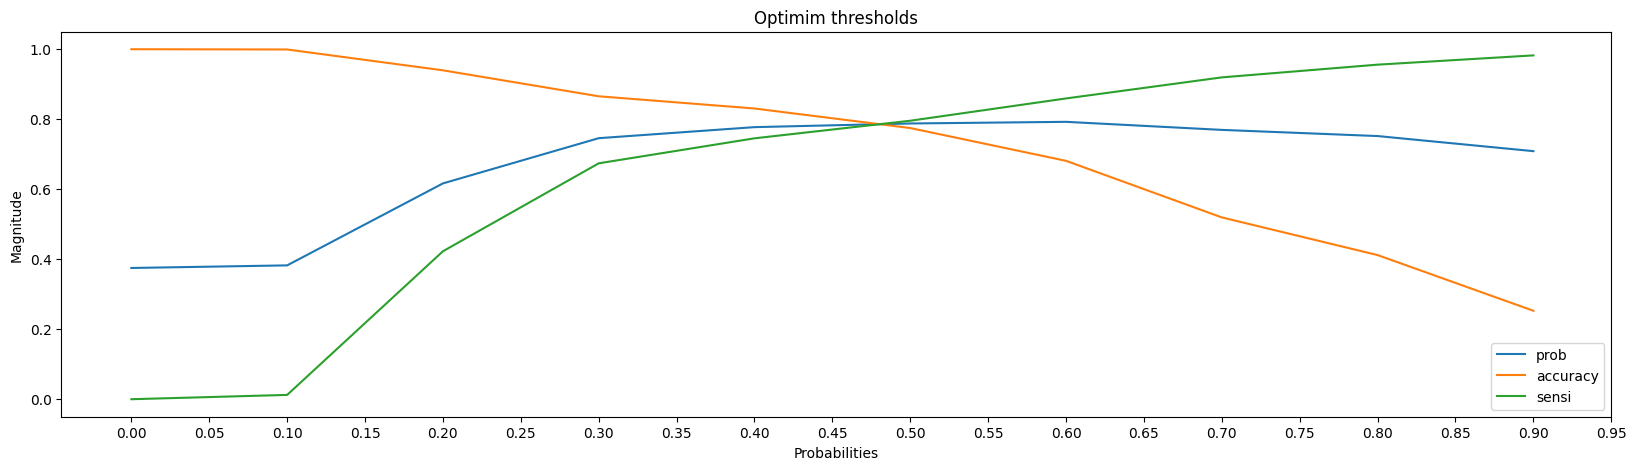

In [279]:
plt.figure(figsize = (20,5))
plt.plot(cutoff_df.drop(columns = ['prob']))
plt.title('Optimim thresholds')
plt.ylabel('Magnitude')
plt.xlabel('Probabilities')
plt.xticks([i/100 for i in range(0,100, 5)], rotation = 0)
plt.legend(cutoff_df.columns)
plt.show()

##### Observations:
- From the above graph 0.45 seems to be the optimal threshold for our use case

In [280]:
# Configuring the optimal threshold value to 0.45
OPTIMAL_THRESHOLD = 0.45

# Generating the final predictions feature for the training predictions data
training_data_predictions['final_predictions'] = training_data_predictions.converted_prediction_probabilities.map( lambda x: 1 if x > OPTIMAL_THRESHOLD else 0)
# Generating the Lead Score feature
training_data_predictions['lead_score'] = training_data_predictions.converted_prediction_probabilities.map(lambda x : round(x*100, 2))

training_data_predictions.head()

lead_number  converted  converted_predictions  \
0            0          0                      0   
1            1          1                      1   
2            2          1                      1   
3            3          0                      1   
4            4          0                      0   

   converted_prediction_probabilities  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  \
0                            0.174266    1    1    0    0    0    0    0    0   
1                            0.928458    1    1    1    1    1    1    1    1   
2                            0.952095    1    1    1    1    1    1    1    1   
3                            0.620575    1    1    1    1    1    1    1    0   
4                            0.265444    1    1    1    0    0    0    0    0   

   0.8  0.9  final_predictions  lead_score  
0    0    0                  0       17.43  
1    1    1                  1       92.85  
2    1    1                  1       95.21  
3    0    0                  1       62.06  
4    0    0                  0       26.54

### 5.2.4 Final model with new `optimal_threshold` evaluation

In [281]:
# Cunfusion Matrix
confusion = confusion_matrix(training_data_predictions.converted, training_data_predictions.final_predictions)

# Extracting the components of the confusion matrix
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print(f'Confusion Matrix : \n{confusion}')
print()
print(f'True Positives : {TP}\nTrue Negatives : {TN}\nFalse Positives : {FP}\nFalse Negatives : {FN}')

Confusion Matrix : 
[[3484 1053]
 [ 514 2208]]

True Positives : 2208
True Negatives : 3484
False Positives : 1053
False Negatives : 514


In [282]:
# Performance metrics
print(f'Model Training Accuracy           :   {accuracy_score(training_data_predictions.converted, training_data_predictions.final_predictions):.02}')
print(f'Model Training Recall             :   {recall_score(training_data_predictions.converted, training_data_predictions.final_predictions):.02}')
print(f'Model Training F-1 Score          :   {f1_score(training_data_predictions.converted, training_data_predictions.final_predictions):.02}')
print(f'Model Sensitivity                 :   {TP/float(TP+FN):.02}')
print(f'Model Specificity                 :   {TN/float(TN+FP):.02}')
print(f'Model False Positive Rate         :   {FP/float(TN+FP):.02}')
print(f'Model Positive Predictive Value   :   {TP/float(TP+FP):.02}')
print(f'Model Negative Predictive Value   :   {TN/float(TN+FN):.02}')

Model Training Accuracy           :   0.78
Model Training Recall             :   0.81
Model Training F-1 Score          :   0.74
Model Sensitivity                 :   0.81
Model Specificity                 :   0.77
Model False Positive Rate         :   0.23
Model Positive Predictive Value   :   0.68
Model Negative Predictive Value   :   0.87


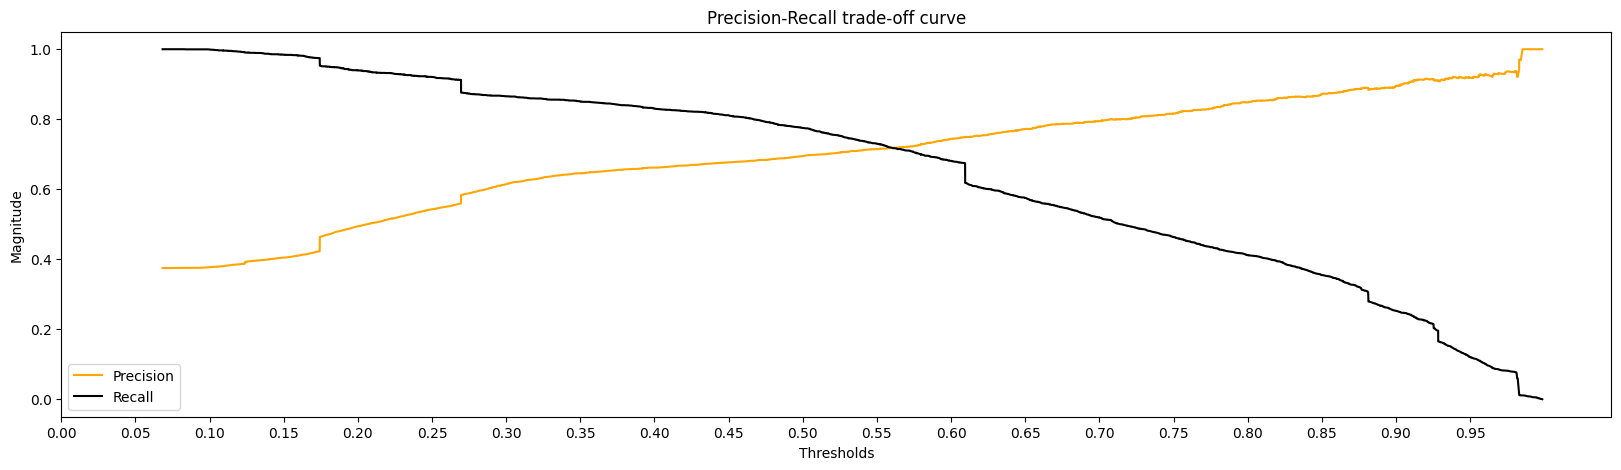

In [283]:
# Precision-Recall Tradeoff curve
precisions, recalls, thresholds = precision_recall_curve(training_data_predictions.converted, training_data_predictions.converted_prediction_probabilities)

plt.figure(figsize = (20,5))
plt.plot(thresholds, precisions[:-1], "orange")
plt.plot(thresholds, recalls[:-1], "black")

plt.title('Precision-Recall trade-off curve')
plt.ylabel('Magnitude')
plt.xlabel('Thresholds')
plt.xticks([i/100 for i in range(0,100, 5)], rotation = 0)
plt.legend(['Precision','Recall'])
plt.show()

### 5.2.5 Final Model Test Predictions

In [284]:
# Getting the same features as X_train
X_test = X_test[X_train.columns]
X_test.head(3)

a_free_copy_of_mastering_the_interview  totalvisits  \
0                                     1.0     0.003984   
1                                     1.0     0.007968   
2                                     0.0     0.027888   

   total_time_spent_on_website  page_views_per_visit  lead_source_IV  \
0                     0.155370              0.018182        0.634551   
1                     0.335387              0.036364        0.634551   
2                     0.050616              0.063636        0.634551   

   last_notable_activity_IV  lead_origin_Landing Page Submission  \
0                  0.892584                                  1.0   
1                  0.742444                                  1.0   
2                  0.742444                                  1.0   

   lead_origin_Lead Add Form  lead_origin_Lead Import  
0                        0.0                      0.0  
1                        0.0                      0.0  
2                        0.0                      0.0

In [285]:
# Making predictions
y_test_predictions = final_model.predict_proba(X_test)
y_test_predictions = y_test_predictions[:,1]
y_test_predictions

array([0.17565943, 0.44239927, 0.21026233, ..., 0.17426644, 0.44189183,
       0.86886096])

In [286]:
# Generating test predictions dataset
test_predictions = y_test.copy()
test_predictions['converted_prediction_probabilities'] = y_test_predictions
test_predictions['final_predictions'] = test_predictions.converted_prediction_probabilities.map(lambda x : 1 if x>OPTIMAL_THRESHOLD else 0)
test_predictions

converted  converted_prediction_probabilities  final_predictions
lead_number                                                                  
647606               0                            0.175659                  0
595214               1                            0.442399                  0
620255               0                            0.210262                  0
615704               1                            0.456963                  1
588834               0                            0.174266                  0
...                ...                                 ...                ...
616453               0                            0.224706                  0
586837               0                            0.174266                  0
608055               0                            0.174266                  0
582943               0                            0.441892                  0
607643               0                            0.868861                  1

[1815 rows x 3 columns]

In [287]:
# Cunfusion Matrix
confusion = confusion_matrix(test_predictions.converted, test_predictions.final_predictions)

# Extracting the components of the confusion matrix
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print(f'Confusion Matrix : \n{confusion}')
print()
print(f'True Positives : {TP}\nTrue Negatives : {TN}\nFalse Positives : {FP}\nFalse Negatives : {FN}')

Confusion Matrix : 
[[839 263]
 [129 584]]

True Positives : 584
True Negatives : 839
False Positives : 263
False Negatives : 129


In [288]:
# Performance metrics
print(f'Model Training Accuracy           :   {accuracy_score(test_predictions.converted, test_predictions.final_predictions):.02}')
print(f'Model Training Recall             :   {recall_score(test_predictions.converted, test_predictions.final_predictions):.02}')
print(f'Model Training F-1 Score          :   {f1_score(test_predictions.converted, test_predictions.final_predictions):.02}')
print(f'Model Sensitivity                 :   {TP/float(TP+FN):.02}')
print(f'Model Specificity                 :   {TN/float(TN+FP):.02}')
print(f'Model False Positive Rate         :   {FP/float(TN+FP):.02}')
print(f'Model Positive Predictive Value   :   {TP/float(TP+FP):.02}')
print(f'Model Negative Predictive Value   :   {TN/float(TN+FN):.02}')

Model Training Accuracy           :   0.78
Model Training Recall             :   0.82
Model Training F-1 Score          :   0.75
Model Sensitivity                 :   0.82
Model Specificity                 :   0.76
Model False Positive Rate         :   0.24
Model Positive Predictive Value   :   0.69
Model Negative Predictive Value   :   0.87


In [289]:
# Generating lead_score
test_predictions['lead_score'] = test_predictions.converted_prediction_probabilities.map(lambda x : round(x*100, 2))
test_predictions.head(3)

converted  converted_prediction_probabilities  final_predictions  \
lead_number                                                                     
647606               0                            0.175659                  0   
595214               1                            0.442399                  0   
620255               0                            0.210262                  0   

             lead_score  
lead_number              
647606            17.57  
595214            44.24  
620255            21.03

In [290]:
# Identifying the top leads
# Setting a threshold of 0.75 for identifying the top leads
top_leads = test_predictions[test_predictions.lead_score>75]
top_leads

converted  converted_prediction_probabilities  final_predictions  \
lead_number                                                                     
621213               1                            0.885144                  1   
657686               1                            0.876349                  1   
598891               1                            0.823374                  1   
595137               1                            0.855787                  1   
594884               1                            0.913062                  1   
...                ...                                 ...                ...   
606559               1                            0.829315                  1   
591418               1                            0.982104                  1   
640717               1                            0.844456                  1   
606526               1                            0.770042                  1   
607643               0                            0.868861                  1   

             lead_score  
lead_number              
621213            88.51  
657686            87.63  
598891            82.34  
595137            85.58  
594884            91.31  
...                 ...  
606559            82.93  
591418            98.21  
640717            84.45  
606526            77.00  
607643            86.89  

[426 rows x 4 columns]

In [291]:
# The lead_numbers of the members to be contatcted are
topleads_id = top_leads.index
print(topleads_id)

Index([621213, 657686, 598891, 595137, 594884, 655522, 617920, 620505, 602438,
       603586,
       ...
       645810, 607221, 653525, 644111, 608489, 606559, 591418, 640717, 606526,
       607643],
      dtype='int64', name='lead_number', length=426)


In [292]:
# Features importances
features_importances = pd.DataFrame({'Features': X_test.columns, 'Co-efficients':final_model.coef_[0]})
features_importances = features_importances.sort_values(by = 'Co-efficients', ascending = False, key = lambda x : abs(x)).reset_index(drop = True)
features_importances

Features  Co-efficients
0             total_time_spent_on_website       4.292616
1               lead_origin_Lead Add Form       4.008085
2                last_notable_activity_IV      -3.722286
3                    page_views_per_visit      -1.006439
4                          lead_source_IV       0.674592
5                 lead_origin_Lead Import       0.557842
6     lead_origin_Landing Page Submission      -0.413281
7                             totalvisits       0.325201
8  a_free_copy_of_mastering_the_interview      -0.151469

# 6. Conclusion:
- lead originating from `Lead Add Forms` should be prioritized
- `last notable activities` should be taken into consideration
- lead originating from `Landing Page Submission` should be prioritized
- lead originating from `Lead Import` should be prioritized